In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import scipy
warnings.filterwarnings('ignore')

import sklearn.linear_model as lm
import sklearn.ensemble as en

import torch
import os
import sys
sys.path.append(os.path.abspath('../python'))

import train_arvae
import verify_causal_model

# DGP + Synthetic Control

$y_i(0) = \mu_i \lambda_t + \delta_t + \epsilon_{i,t}$ \
$y_i(1) = \alpha_{i,t} + y_i(0)$

In [10]:
def gen_data( n_donor=10, T=20, T0=12, noise=1 ):
    lmbda = np.random.normal(0,1,size=(T,1))
    delta = np.random.normal(0,1,size=(T,1))
    mu = np.random.normal(0,1,size=(1+n_donor,1))
    epsilon = np.random.normal(0,1,size=(T,1+n_donor))
    y0 = np.matmul(lmbda,mu.T) + np.matmul(delta,np.ones((1,1+n_donor))) + epsilon
    y1 = y0
    intervention = np.zeros((T,1+n_donor))
    intervention[T0:T,0] = 1
    y = intervention*y1 + (1-intervention)*y0
    return y,intervention,y1,y0

def synthetic_control( y, T0 ):
    y_target = y[:,0]
    y_donors = y[:,1:]
    ypre_target = y[:T0,0]
    ypre_donors = y[:T0,1:]
    m_lasso = lm.LassoCV().fit(ypre_donors,ypre_target)
    y_target_lasso = m_lasso.predict(y_donors)
    effect = y_target - y_target_lasso
    return effect, y_target, y_target_lasso

In [13]:
n_donor=10 
T=20
T0=12
noise=1 
y,intervention,y1,y0 = gen_data( n_donor=n_donor, T=T, T0=T0, noise=noise )

In [17]:
effect, y_target, y_target_lasso = synthetic_control( y, T0 )

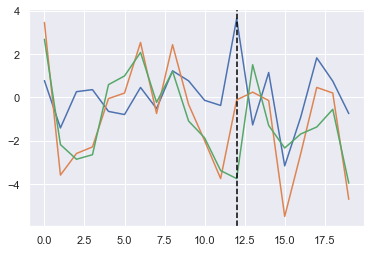

In [18]:
plt.plot(effect)
plt.plot(y_target)
plt.plot(y_target_lasso)
plt.axvline(T0,c='black',ls='--')

# Credence

In [21]:
B = 100
for i in range(B):
    y,intervention,y1,y0 = gen_data( n_donor=n_donor, T=T, T0=T0, noise=noise )
    y_donors = ( y[:,1:] - np.mean(y[:,1:]) ) / np.std(y[:,1:])
    if i==0:
        data = y_donors.reshape(T,1,n_donor)
    else:
        data = np.concatenate((data,y_donors.reshape(T,1,n_donor)),axis=1)

data_2d = train_arvae.convert_to_2d(data)

In [23]:
print(f"Shape: {data_2d.shape}")
print(f"\nMean of raw data: {np.mean(data_2d):.3f}")
print(f"Std. dev of raw data: {np.std(data_2d):.3f}")

Shape: (100, 200)

Mean of raw data: 0.000
Std. dev of raw data: 1.000


In [24]:
hyper_params = {}
hyper_params['epochs'] = 5000
hyper_params['latent_dim'] = 2 #Z
hyper_params['hidden_dims'] = [16,8]
hyper_params['kld_weight'] = 5e-08
vae_model, runner = train_arvae.train(data_2d, hyper_params, output_checkpoint_path='ar_vae_coverage_2d.ckpt')

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name          | Type       | Params
---------------------------------------------
0 | encoder       | Sequential | 3.4 K 
1 | fc_mu         | Linear     | 18    
2 | fc_var        | Linear     | 18    
3 | decoder_input | Linear     | 24    
4 | decoder       | Sequential | 144   
5 | final_layer   | Sequential | 3.4 K 
---------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)


Loss Before Training
{'loss': tensor(1.0783, grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(1.0734, grad_fn=<MseLossBackward>), 'KLD_Loss': tensor(0.0992, grad_fn=<MeanBackward0>), 'KLD_weight': 0.05}


Validation sanity check: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0816), 'kld_loss': tensor(0.0992), 'reconstruction_loss': tensor(1.0767)}


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0587), 'kld_loss': tensor(0.0942), 'reconstruction_loss': tensor(1.0540)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0401), 'kld_loss': tensor(0.0883), 'reconstruction_loss': tensor(1.0357)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0339), 'kld_loss': tensor(0.0811), 'reconstruction_loss': tensor(1.0298)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0324), 'kld_loss': tensor(0.0723), 'reconstruction_loss': tensor(1.0288)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0241), 'kld_loss': tensor(0.0620), 'reconstruction_loss': tensor(1.0210)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0180), 'kld_loss': tensor(0.0510), 'reconstruction_loss': tensor(1.0155)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0143), 'kld_loss': tensor(0.0409), 'reconstruction_loss': tensor(1.0122)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0099), 'kld_loss': tensor(0.0341), 'reconstruction_loss': tensor(1.0082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0050), 'kld_loss': tensor(0.0331), 'reconstruction_loss': tensor(1.0033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0038), 'kld_loss': tensor(0.0373), 'reconstruction_loss': tensor(1.0019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0026), 'kld_loss': tensor(0.0424), 'reconstruction_loss': tensor(1.0005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9995), 'kld_loss': tensor(0.0435), 'reconstruction_loss': tensor(0.9973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9988), 'kld_loss': tensor(0.0401), 'reconstruction_loss': tensor(0.9968)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9982), 'kld_loss': tensor(0.0338), 'reconstruction_loss': tensor(0.9966)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9966), 'kld_loss': tensor(0.0269), 'reconstruction_loss': tensor(0.9952)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9944), 'kld_loss': tensor(0.0214), 'reconstruction_loss': tensor(0.9933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9943), 'kld_loss': tensor(0.0175), 'reconstruction_loss': tensor(0.9934)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9934), 'kld_loss': tensor(0.0151), 'reconstruction_loss': tensor(0.9926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9918), 'kld_loss': tensor(0.0137), 'reconstruction_loss': tensor(0.9911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9932), 'kld_loss': tensor(0.0128), 'reconstruction_loss': tensor(0.9926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9917), 'kld_loss': tensor(0.0121), 'reconstruction_loss': tensor(0.9911)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9911), 'kld_loss': tensor(0.0114), 'reconstruction_loss': tensor(0.9905)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9905), 'kld_loss': tensor(0.0106), 'reconstruction_loss': tensor(0.9900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9907), 'kld_loss': tensor(0.0098), 'reconstruction_loss': tensor(0.9903)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9900), 'kld_loss': tensor(0.0090), 'reconstruction_loss': tensor(0.9895)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9893), 'kld_loss': tensor(0.0083), 'reconstruction_loss': tensor(0.9889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9885), 'kld_loss': tensor(0.0078), 'reconstruction_loss': tensor(0.9881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9884), 'kld_loss': tensor(0.0075), 'reconstruction_loss': tensor(0.9880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9884), 'kld_loss': tensor(0.0072), 'reconstruction_loss': tensor(0.9881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9883), 'kld_loss': tensor(0.0071), 'reconstruction_loss': tensor(0.9880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9886), 'kld_loss': tensor(0.0067), 'reconstruction_loss': tensor(0.9882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9878), 'kld_loss': tensor(0.0063), 'reconstruction_loss': tensor(0.9875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9887), 'kld_loss': tensor(0.0057), 'reconstruction_loss': tensor(0.9884)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9876), 'kld_loss': tensor(0.0051), 'reconstruction_loss': tensor(0.9873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9882), 'kld_loss': tensor(0.0043), 'reconstruction_loss': tensor(0.9880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9873), 'kld_loss': tensor(0.0037), 'reconstruction_loss': tensor(0.9871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0031), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9875), 'kld_loss': tensor(0.0027), 'reconstruction_loss': tensor(0.9874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9879), 'kld_loss': tensor(0.0025), 'reconstruction_loss': tensor(0.9878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9882), 'kld_loss': tensor(0.0023), 'reconstruction_loss': tensor(0.9881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0022), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9875), 'kld_loss': tensor(0.0021), 'reconstruction_loss': tensor(0.9874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.0021), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9870), 'kld_loss': tensor(0.0020), 'reconstruction_loss': tensor(0.9869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9877), 'kld_loss': tensor(0.0018), 'reconstruction_loss': tensor(0.9876)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9872), 'kld_loss': tensor(0.0017), 'reconstruction_loss': tensor(0.9871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0017), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0017), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9870), 'kld_loss': tensor(0.0017), 'reconstruction_loss': tensor(0.9869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0018), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0017), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.0017), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9872), 'kld_loss': tensor(0.0016), 'reconstruction_loss': tensor(0.9871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9870), 'kld_loss': tensor(0.0015), 'reconstruction_loss': tensor(0.9869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9870), 'kld_loss': tensor(0.0013), 'reconstruction_loss': tensor(0.9870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0012), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0011), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.0011), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9870), 'kld_loss': tensor(0.0010), 'reconstruction_loss': tensor(0.9870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0010), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9872), 'kld_loss': tensor(0.0010), 'reconstruction_loss': tensor(0.9871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9873), 'kld_loss': tensor(0.0009), 'reconstruction_loss': tensor(0.9872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.0009), 'reconstruction_loss': tensor(0.9869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9859), 'kld_loss': tensor(0.0009), 'reconstruction_loss': tensor(0.9859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9862), 'kld_loss': tensor(0.0009), 'reconstruction_loss': tensor(0.9862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0009), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0009), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0009), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0009), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0008), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0008), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0007), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0007), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.0007), 'reconstruction_loss': tensor(0.9869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0006), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0006), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0006), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9872), 'kld_loss': tensor(0.0005), 'reconstruction_loss': tensor(0.9871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0005), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0005), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9862), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9862), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(9.3828e-05), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(9.3776e-05), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9862), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(9.7463e-05), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(8.6578e-05), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(8.0616e-05), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(7.8569e-05), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(7.8834e-05), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(8.0847e-05), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(8.6444e-05), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(9.4820e-05), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(9.4553e-05), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(9.0509e-05), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(9.1224e-05), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(9.6151e-05), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(9.4333e-05), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(8.2337e-05), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(7.9676e-05), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(7.7999e-05), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(8.0193e-05), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(9.2048e-05), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(9.8554e-05), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(9.8725e-05), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(9.6581e-05), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(8.7765e-05), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(8.0571e-05), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(7.6220e-05), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(7.5844e-05), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(8.1726e-05), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(9.4763e-05), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(9.7205e-05), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(9.3597e-05), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(8.9341e-05), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(8.3884e-05), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(7.8699e-05), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(7.4293e-05), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(7.0982e-05), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(6.9463e-05), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(6.9619e-05), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(7.1806e-05), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(7.6165e-05), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(8.3267e-05), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(9.3707e-05), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(9.9924e-05), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(9.8492e-05), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9862), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(9.8169e-05), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(9.2121e-05), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(8.6535e-05), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(8.3178e-05), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(8.3294e-05), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(8.5422e-05), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(9.0052e-05), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(9.6407e-05), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9862), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0005), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0001), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9862), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9862), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0005), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0006), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0007), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0008), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0009), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0010), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0010), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0010), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0010), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0009), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0008), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0007), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0006), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0005), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9870), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0002), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0003), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.0004), 'reconstruction_loss': tensor(0.9869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0005), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0005), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0006), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0006), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0007), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0008), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0009), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0010), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0011), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0012), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9870), 'kld_loss': tensor(0.0012), 'reconstruction_loss': tensor(0.9869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.0012), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0011), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0010), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0010), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9862), 'kld_loss': tensor(0.0010), 'reconstruction_loss': tensor(0.9862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9870), 'kld_loss': tensor(0.0010), 'reconstruction_loss': tensor(0.9870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9872), 'kld_loss': tensor(0.0010), 'reconstruction_loss': tensor(0.9871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9876), 'kld_loss': tensor(0.0010), 'reconstruction_loss': tensor(0.9875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9871), 'kld_loss': tensor(0.0011), 'reconstruction_loss': tensor(0.9871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0012), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0014), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0015), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9862), 'kld_loss': tensor(0.0017), 'reconstruction_loss': tensor(0.9861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9870), 'kld_loss': tensor(0.0021), 'reconstruction_loss': tensor(0.9869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9874), 'kld_loss': tensor(0.0025), 'reconstruction_loss': tensor(0.9872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9862), 'kld_loss': tensor(0.0028), 'reconstruction_loss': tensor(0.9861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0029), 'reconstruction_loss': tensor(0.9862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0028), 'reconstruction_loss': tensor(0.9861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9859), 'kld_loss': tensor(0.0027), 'reconstruction_loss': tensor(0.9858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0026), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0025), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0026), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0028), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9858), 'kld_loss': tensor(0.0029), 'reconstruction_loss': tensor(0.9857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9872), 'kld_loss': tensor(0.0029), 'reconstruction_loss': tensor(0.9871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.0028), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9862), 'kld_loss': tensor(0.0028), 'reconstruction_loss': tensor(0.9861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9876), 'kld_loss': tensor(0.0029), 'reconstruction_loss': tensor(0.9875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0030), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.0032), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0033), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9872), 'kld_loss': tensor(0.0033), 'reconstruction_loss': tensor(0.9871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0033), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0034), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0034), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0035), 'reconstruction_loss': tensor(0.9862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9862), 'kld_loss': tensor(0.0036), 'reconstruction_loss': tensor(0.9860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9862), 'kld_loss': tensor(0.0037), 'reconstruction_loss': tensor(0.9860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0038), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0038), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9862), 'kld_loss': tensor(0.0037), 'reconstruction_loss': tensor(0.9860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9870), 'kld_loss': tensor(0.0038), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0040), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9871), 'kld_loss': tensor(0.0045), 'reconstruction_loss': tensor(0.9869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0054), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9847), 'kld_loss': tensor(0.0069), 'reconstruction_loss': tensor(0.9844)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9870), 'kld_loss': tensor(0.0086), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0099), 'reconstruction_loss': tensor(0.9860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9884), 'kld_loss': tensor(0.0102), 'reconstruction_loss': tensor(0.9879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.0095), 'reconstruction_loss': tensor(0.9859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.0086), 'reconstruction_loss': tensor(0.9860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0077), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.0070), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(0.0068), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9876), 'kld_loss': tensor(0.0070), 'reconstruction_loss': tensor(0.9873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.0073), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9861), 'kld_loss': tensor(0.0079), 'reconstruction_loss': tensor(0.9857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9857), 'kld_loss': tensor(0.0083), 'reconstruction_loss': tensor(0.9853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9853), 'kld_loss': tensor(0.0088), 'reconstruction_loss': tensor(0.9848)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9859), 'kld_loss': tensor(0.0090), 'reconstruction_loss': tensor(0.9854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0091), 'reconstruction_loss': tensor(0.9858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.0089), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9860), 'kld_loss': tensor(0.0085), 'reconstruction_loss': tensor(0.9856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0080), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9851), 'kld_loss': tensor(0.0076), 'reconstruction_loss': tensor(0.9847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0075), 'reconstruction_loss': tensor(0.9859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9882), 'kld_loss': tensor(0.0079), 'reconstruction_loss': tensor(0.9878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9874), 'kld_loss': tensor(0.0096), 'reconstruction_loss': tensor(0.9870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9859), 'kld_loss': tensor(0.0119), 'reconstruction_loss': tensor(0.9853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9874), 'kld_loss': tensor(0.0139), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9872), 'kld_loss': tensor(0.0153), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.0155), 'reconstruction_loss': tensor(0.9859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9876), 'kld_loss': tensor(0.0156), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9860), 'kld_loss': tensor(0.0163), 'reconstruction_loss': tensor(0.9852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9856), 'kld_loss': tensor(0.0173), 'reconstruction_loss': tensor(0.9847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9846), 'kld_loss': tensor(0.0182), 'reconstruction_loss': tensor(0.9837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9876), 'kld_loss': tensor(0.0179), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9857), 'kld_loss': tensor(0.0170), 'reconstruction_loss': tensor(0.9849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9872), 'kld_loss': tensor(0.0171), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9855), 'kld_loss': tensor(0.0168), 'reconstruction_loss': tensor(0.9847)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9879), 'kld_loss': tensor(0.0168), 'reconstruction_loss': tensor(0.9870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9848), 'kld_loss': tensor(0.0185), 'reconstruction_loss': tensor(0.9839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9874), 'kld_loss': tensor(0.0230), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9860), 'kld_loss': tensor(0.0300), 'reconstruction_loss': tensor(0.9845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9850), 'kld_loss': tensor(0.0303), 'reconstruction_loss': tensor(0.9834)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9855), 'kld_loss': tensor(0.0282), 'reconstruction_loss': tensor(0.9841)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9839), 'kld_loss': tensor(0.0269), 'reconstruction_loss': tensor(0.9826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.0322), 'reconstruction_loss': tensor(0.9853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9871), 'kld_loss': tensor(0.0394), 'reconstruction_loss': tensor(0.9851)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9875), 'kld_loss': tensor(0.0415), 'reconstruction_loss': tensor(0.9854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9862), 'kld_loss': tensor(0.0450), 'reconstruction_loss': tensor(0.9840)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9844), 'kld_loss': tensor(0.0436), 'reconstruction_loss': tensor(0.9822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9850), 'kld_loss': tensor(0.0468), 'reconstruction_loss': tensor(0.9827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9856), 'kld_loss': tensor(0.0553), 'reconstruction_loss': tensor(0.9829)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9852), 'kld_loss': tensor(0.0509), 'reconstruction_loss': tensor(0.9826)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9834), 'kld_loss': tensor(0.0449), 'reconstruction_loss': tensor(0.9812)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9885), 'kld_loss': tensor(0.0476), 'reconstruction_loss': tensor(0.9861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9889), 'kld_loss': tensor(0.0606), 'reconstruction_loss': tensor(0.9859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9843), 'kld_loss': tensor(0.0730), 'reconstruction_loss': tensor(0.9807)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9851), 'kld_loss': tensor(0.0546), 'reconstruction_loss': tensor(0.9824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9883), 'kld_loss': tensor(0.0527), 'reconstruction_loss': tensor(0.9856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9843), 'kld_loss': tensor(0.0612), 'reconstruction_loss': tensor(0.9812)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9839), 'kld_loss': tensor(0.0686), 'reconstruction_loss': tensor(0.9804)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9854), 'kld_loss': tensor(0.0543), 'reconstruction_loss': tensor(0.9827)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9860), 'kld_loss': tensor(0.0467), 'reconstruction_loss': tensor(0.9837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9836), 'kld_loss': tensor(0.0488), 'reconstruction_loss': tensor(0.9812)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9832), 'kld_loss': tensor(0.0624), 'reconstruction_loss': tensor(0.9801)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9880), 'kld_loss': tensor(0.0999), 'reconstruction_loss': tensor(0.9830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9853), 'kld_loss': tensor(0.0825), 'reconstruction_loss': tensor(0.9812)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.0627), 'reconstruction_loss': tensor(0.9832)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9855), 'kld_loss': tensor(0.0630), 'reconstruction_loss': tensor(0.9824)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9819), 'kld_loss': tensor(0.0743), 'reconstruction_loss': tensor(0.9782)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9846), 'kld_loss': tensor(0.1100), 'reconstruction_loss': tensor(0.9791)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9905), 'kld_loss': tensor(0.1488), 'reconstruction_loss': tensor(0.9830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9817), 'kld_loss': tensor(0.1466), 'reconstruction_loss': tensor(0.9744)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9902), 'kld_loss': tensor(0.1151), 'reconstruction_loss': tensor(0.9845)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9856), 'kld_loss': tensor(0.0974), 'reconstruction_loss': tensor(0.9807)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9854), 'kld_loss': tensor(0.1247), 'reconstruction_loss': tensor(0.9792)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9817), 'kld_loss': tensor(0.1498), 'reconstruction_loss': tensor(0.9742)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9858), 'kld_loss': tensor(0.1606), 'reconstruction_loss': tensor(0.9778)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9901), 'kld_loss': tensor(0.1366), 'reconstruction_loss': tensor(0.9833)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9841), 'kld_loss': tensor(0.1098), 'reconstruction_loss': tensor(0.9786)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9838), 'kld_loss': tensor(0.1032), 'reconstruction_loss': tensor(0.9786)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.1098), 'reconstruction_loss': tensor(0.9809)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9876), 'kld_loss': tensor(0.1297), 'reconstruction_loss': tensor(0.9811)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9850), 'kld_loss': tensor(0.1484), 'reconstruction_loss': tensor(0.9775)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9875), 'kld_loss': tensor(0.1539), 'reconstruction_loss': tensor(0.9798)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9842), 'kld_loss': tensor(0.1520), 'reconstruction_loss': tensor(0.9766)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9833), 'kld_loss': tensor(0.1591), 'reconstruction_loss': tensor(0.9754)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9809), 'kld_loss': tensor(0.1700), 'reconstruction_loss': tensor(0.9724)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9829), 'kld_loss': tensor(0.1980), 'reconstruction_loss': tensor(0.9730)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9834), 'kld_loss': tensor(0.2192), 'reconstruction_loss': tensor(0.9724)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9854), 'kld_loss': tensor(0.2223), 'reconstruction_loss': tensor(0.9742)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9857), 'kld_loss': tensor(0.2375), 'reconstruction_loss': tensor(0.9738)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.2576), 'reconstruction_loss': tensor(0.9740)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9837), 'kld_loss': tensor(0.2533), 'reconstruction_loss': tensor(0.9711)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9826), 'kld_loss': tensor(0.2359), 'reconstruction_loss': tensor(0.9708)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9822), 'kld_loss': tensor(0.2068), 'reconstruction_loss': tensor(0.9719)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9798), 'kld_loss': tensor(0.2121), 'reconstruction_loss': tensor(0.9691)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9846), 'kld_loss': tensor(0.2919), 'reconstruction_loss': tensor(0.9700)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9854), 'kld_loss': tensor(0.2956), 'reconstruction_loss': tensor(0.9707)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9851), 'kld_loss': tensor(0.2546), 'reconstruction_loss': tensor(0.9724)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9844), 'kld_loss': tensor(0.2649), 'reconstruction_loss': tensor(0.9711)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9835), 'kld_loss': tensor(0.3095), 'reconstruction_loss': tensor(0.9680)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9835), 'kld_loss': tensor(0.2988), 'reconstruction_loss': tensor(0.9685)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9845), 'kld_loss': tensor(0.2887), 'reconstruction_loss': tensor(0.9701)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9859), 'kld_loss': tensor(0.2784), 'reconstruction_loss': tensor(0.9720)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9818), 'kld_loss': tensor(0.2669), 'reconstruction_loss': tensor(0.9684)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9859), 'kld_loss': tensor(0.2477), 'reconstruction_loss': tensor(0.9735)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9885), 'kld_loss': tensor(0.2339), 'reconstruction_loss': tensor(0.9768)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9838), 'kld_loss': tensor(0.2320), 'reconstruction_loss': tensor(0.9722)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9846), 'kld_loss': tensor(0.2251), 'reconstruction_loss': tensor(0.9733)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9848), 'kld_loss': tensor(0.2562), 'reconstruction_loss': tensor(0.9719)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9822), 'kld_loss': tensor(0.2763), 'reconstruction_loss': tensor(0.9684)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9850), 'kld_loss': tensor(0.2776), 'reconstruction_loss': tensor(0.9711)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9833), 'kld_loss': tensor(0.2793), 'reconstruction_loss': tensor(0.9694)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9842), 'kld_loss': tensor(0.2806), 'reconstruction_loss': tensor(0.9702)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9820), 'kld_loss': tensor(0.2760), 'reconstruction_loss': tensor(0.9682)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9851), 'kld_loss': tensor(0.2394), 'reconstruction_loss': tensor(0.9731)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9792), 'kld_loss': tensor(0.2224), 'reconstruction_loss': tensor(0.9681)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9830), 'kld_loss': tensor(0.2072), 'reconstruction_loss': tensor(0.9727)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9824), 'kld_loss': tensor(0.2068), 'reconstruction_loss': tensor(0.9720)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9912), 'kld_loss': tensor(0.2253), 'reconstruction_loss': tensor(0.9799)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.2657), 'reconstruction_loss': tensor(0.9730)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9913), 'kld_loss': tensor(0.2956), 'reconstruction_loss': tensor(0.9765)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9817), 'kld_loss': tensor(0.3110), 'reconstruction_loss': tensor(0.9662)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9819), 'kld_loss': tensor(0.2716), 'reconstruction_loss': tensor(0.9683)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9817), 'kld_loss': tensor(0.2218), 'reconstruction_loss': tensor(0.9707)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.2088), 'reconstruction_loss': tensor(0.9761)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9834), 'kld_loss': tensor(0.2197), 'reconstruction_loss': tensor(0.9724)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9850), 'kld_loss': tensor(0.2356), 'reconstruction_loss': tensor(0.9732)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.2450), 'reconstruction_loss': tensor(0.9742)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9844), 'kld_loss': tensor(0.2514), 'reconstruction_loss': tensor(0.9718)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9833), 'kld_loss': tensor(0.2604), 'reconstruction_loss': tensor(0.9703)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9814), 'kld_loss': tensor(0.2681), 'reconstruction_loss': tensor(0.9680)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9793), 'kld_loss': tensor(0.2768), 'reconstruction_loss': tensor(0.9654)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9811), 'kld_loss': tensor(0.2861), 'reconstruction_loss': tensor(0.9668)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9836), 'kld_loss': tensor(0.2872), 'reconstruction_loss': tensor(0.9692)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9815), 'kld_loss': tensor(0.2830), 'reconstruction_loss': tensor(0.9673)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9810), 'kld_loss': tensor(0.2720), 'reconstruction_loss': tensor(0.9674)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9822), 'kld_loss': tensor(0.2587), 'reconstruction_loss': tensor(0.9693)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9786), 'kld_loss': tensor(0.2317), 'reconstruction_loss': tensor(0.9670)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9830), 'kld_loss': tensor(0.2292), 'reconstruction_loss': tensor(0.9716)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9811), 'kld_loss': tensor(0.2234), 'reconstruction_loss': tensor(0.9700)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9809), 'kld_loss': tensor(0.2319), 'reconstruction_loss': tensor(0.9693)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9936), 'kld_loss': tensor(0.2496), 'reconstruction_loss': tensor(0.9811)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9842), 'kld_loss': tensor(0.2999), 'reconstruction_loss': tensor(0.9692)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9859), 'kld_loss': tensor(0.3364), 'reconstruction_loss': tensor(0.9690)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9854), 'kld_loss': tensor(0.3075), 'reconstruction_loss': tensor(0.9700)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9807), 'kld_loss': tensor(0.2724), 'reconstruction_loss': tensor(0.9671)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9896), 'kld_loss': tensor(0.2427), 'reconstruction_loss': tensor(0.9774)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9813), 'kld_loss': tensor(0.2310), 'reconstruction_loss': tensor(0.9697)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9821), 'kld_loss': tensor(0.2379), 'reconstruction_loss': tensor(0.9702)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9833), 'kld_loss': tensor(0.2500), 'reconstruction_loss': tensor(0.9708)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9772), 'kld_loss': tensor(0.2714), 'reconstruction_loss': tensor(0.9636)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9829), 'kld_loss': tensor(0.2866), 'reconstruction_loss': tensor(0.9686)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9780), 'kld_loss': tensor(0.3013), 'reconstruction_loss': tensor(0.9629)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9775), 'kld_loss': tensor(0.3077), 'reconstruction_loss': tensor(0.9621)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9871), 'kld_loss': tensor(0.2960), 'reconstruction_loss': tensor(0.9723)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9880), 'kld_loss': tensor(0.2775), 'reconstruction_loss': tensor(0.9742)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9889), 'kld_loss': tensor(0.2574), 'reconstruction_loss': tensor(0.9760)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9789), 'kld_loss': tensor(0.2516), 'reconstruction_loss': tensor(0.9664)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9847), 'kld_loss': tensor(0.2698), 'reconstruction_loss': tensor(0.9712)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9854), 'kld_loss': tensor(0.2940), 'reconstruction_loss': tensor(0.9707)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9823), 'kld_loss': tensor(0.2903), 'reconstruction_loss': tensor(0.9678)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9794), 'kld_loss': tensor(0.2819), 'reconstruction_loss': tensor(0.9653)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9812), 'kld_loss': tensor(0.2707), 'reconstruction_loss': tensor(0.9676)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9839), 'kld_loss': tensor(0.2575), 'reconstruction_loss': tensor(0.9710)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9832), 'kld_loss': tensor(0.2463), 'reconstruction_loss': tensor(0.9709)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9807), 'kld_loss': tensor(0.2584), 'reconstruction_loss': tensor(0.9678)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9791), 'kld_loss': tensor(0.2765), 'reconstruction_loss': tensor(0.9653)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9808), 'kld_loss': tensor(0.3029), 'reconstruction_loss': tensor(0.9656)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9779), 'kld_loss': tensor(0.3119), 'reconstruction_loss': tensor(0.9623)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9824), 'kld_loss': tensor(0.3017), 'reconstruction_loss': tensor(0.9673)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9812), 'kld_loss': tensor(0.2765), 'reconstruction_loss': tensor(0.9674)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9840), 'kld_loss': tensor(0.2696), 'reconstruction_loss': tensor(0.9706)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9830), 'kld_loss': tensor(0.2744), 'reconstruction_loss': tensor(0.9692)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9805), 'kld_loss': tensor(0.2859), 'reconstruction_loss': tensor(0.9662)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9808), 'kld_loss': tensor(0.3053), 'reconstruction_loss': tensor(0.9656)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9790), 'kld_loss': tensor(0.3136), 'reconstruction_loss': tensor(0.9634)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9790), 'kld_loss': tensor(0.3028), 'reconstruction_loss': tensor(0.9639)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9813), 'kld_loss': tensor(0.2769), 'reconstruction_loss': tensor(0.9674)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9825), 'kld_loss': tensor(0.2443), 'reconstruction_loss': tensor(0.9703)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9771), 'kld_loss': tensor(0.2338), 'reconstruction_loss': tensor(0.9655)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9859), 'kld_loss': tensor(0.2543), 'reconstruction_loss': tensor(0.9732)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9767), 'kld_loss': tensor(0.2768), 'reconstruction_loss': tensor(0.9629)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9830), 'kld_loss': tensor(0.2837), 'reconstruction_loss': tensor(0.9688)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9773), 'kld_loss': tensor(0.2883), 'reconstruction_loss': tensor(0.9629)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9829), 'kld_loss': tensor(0.2767), 'reconstruction_loss': tensor(0.9690)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9798), 'kld_loss': tensor(0.2687), 'reconstruction_loss': tensor(0.9664)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9824), 'kld_loss': tensor(0.2810), 'reconstruction_loss': tensor(0.9684)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9845), 'kld_loss': tensor(0.2826), 'reconstruction_loss': tensor(0.9703)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9802), 'kld_loss': tensor(0.2846), 'reconstruction_loss': tensor(0.9660)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9811), 'kld_loss': tensor(0.2791), 'reconstruction_loss': tensor(0.9671)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9812), 'kld_loss': tensor(0.2788), 'reconstruction_loss': tensor(0.9672)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9826), 'kld_loss': tensor(0.2850), 'reconstruction_loss': tensor(0.9683)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9835), 'kld_loss': tensor(0.2926), 'reconstruction_loss': tensor(0.9689)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9806), 'kld_loss': tensor(0.2913), 'reconstruction_loss': tensor(0.9661)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9792), 'kld_loss': tensor(0.2874), 'reconstruction_loss': tensor(0.9648)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9790), 'kld_loss': tensor(0.2923), 'reconstruction_loss': tensor(0.9644)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.2843), 'reconstruction_loss': tensor(0.9721)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9779), 'kld_loss': tensor(0.2772), 'reconstruction_loss': tensor(0.9641)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9809), 'kld_loss': tensor(0.2703), 'reconstruction_loss': tensor(0.9674)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9828), 'kld_loss': tensor(0.2702), 'reconstruction_loss': tensor(0.9693)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9801), 'kld_loss': tensor(0.2866), 'reconstruction_loss': tensor(0.9658)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9860), 'kld_loss': tensor(0.3067), 'reconstruction_loss': tensor(0.9706)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9749), 'kld_loss': tensor(0.3256), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9802), 'kld_loss': tensor(0.3374), 'reconstruction_loss': tensor(0.9633)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9846), 'kld_loss': tensor(0.3241), 'reconstruction_loss': tensor(0.9684)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9767), 'kld_loss': tensor(0.3081), 'reconstruction_loss': tensor(0.9613)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9748), 'kld_loss': tensor(0.2893), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9789), 'kld_loss': tensor(0.2736), 'reconstruction_loss': tensor(0.9652)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9809), 'kld_loss': tensor(0.2666), 'reconstruction_loss': tensor(0.9676)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9807), 'kld_loss': tensor(0.2672), 'reconstruction_loss': tensor(0.9674)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9762), 'kld_loss': tensor(0.2674), 'reconstruction_loss': tensor(0.9628)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9839), 'kld_loss': tensor(0.2823), 'reconstruction_loss': tensor(0.9697)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9901), 'kld_loss': tensor(0.2950), 'reconstruction_loss': tensor(0.9753)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9843), 'kld_loss': tensor(0.3051), 'reconstruction_loss': tensor(0.9690)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.2992), 'reconstruction_loss': tensor(0.9719)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9809), 'kld_loss': tensor(0.2871), 'reconstruction_loss': tensor(0.9666)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9788), 'kld_loss': tensor(0.2814), 'reconstruction_loss': tensor(0.9647)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.2814), 'reconstruction_loss': tensor(0.9724)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9797), 'kld_loss': tensor(0.2772), 'reconstruction_loss': tensor(0.9659)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9805), 'kld_loss': tensor(0.2762), 'reconstruction_loss': tensor(0.9666)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9788), 'kld_loss': tensor(0.2884), 'reconstruction_loss': tensor(0.9644)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9774), 'kld_loss': tensor(0.2903), 'reconstruction_loss': tensor(0.9629)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9822), 'kld_loss': tensor(0.2856), 'reconstruction_loss': tensor(0.9679)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9832), 'kld_loss': tensor(0.2835), 'reconstruction_loss': tensor(0.9690)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9795), 'kld_loss': tensor(0.2814), 'reconstruction_loss': tensor(0.9654)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9774), 'kld_loss': tensor(0.2765), 'reconstruction_loss': tensor(0.9636)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9783), 'kld_loss': tensor(0.2766), 'reconstruction_loss': tensor(0.9644)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9820), 'kld_loss': tensor(0.2691), 'reconstruction_loss': tensor(0.9686)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9752), 'kld_loss': tensor(0.2770), 'reconstruction_loss': tensor(0.9613)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9759), 'kld_loss': tensor(0.2844), 'reconstruction_loss': tensor(0.9617)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9749), 'kld_loss': tensor(0.2941), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9792), 'kld_loss': tensor(0.3074), 'reconstruction_loss': tensor(0.9638)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9826), 'kld_loss': tensor(0.3171), 'reconstruction_loss': tensor(0.9668)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9846), 'kld_loss': tensor(0.3107), 'reconstruction_loss': tensor(0.9691)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9830), 'kld_loss': tensor(0.2876), 'reconstruction_loss': tensor(0.9686)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9808), 'kld_loss': tensor(0.2711), 'reconstruction_loss': tensor(0.9673)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9810), 'kld_loss': tensor(0.2685), 'reconstruction_loss': tensor(0.9676)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9790), 'kld_loss': tensor(0.2678), 'reconstruction_loss': tensor(0.9656)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(0.2823), 'reconstruction_loss': tensor(0.9724)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9768), 'kld_loss': tensor(0.2980), 'reconstruction_loss': tensor(0.9619)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9827), 'kld_loss': tensor(0.3155), 'reconstruction_loss': tensor(0.9670)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9852), 'kld_loss': tensor(0.3158), 'reconstruction_loss': tensor(0.9694)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9827), 'kld_loss': tensor(0.2961), 'reconstruction_loss': tensor(0.9679)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9790), 'kld_loss': tensor(0.2767), 'reconstruction_loss': tensor(0.9652)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9875), 'kld_loss': tensor(0.2635), 'reconstruction_loss': tensor(0.9743)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9787), 'kld_loss': tensor(0.2689), 'reconstruction_loss': tensor(0.9652)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9848), 'kld_loss': tensor(0.2789), 'reconstruction_loss': tensor(0.9708)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9781), 'kld_loss': tensor(0.2829), 'reconstruction_loss': tensor(0.9640)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9823), 'kld_loss': tensor(0.2888), 'reconstruction_loss': tensor(0.9678)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9854), 'kld_loss': tensor(0.3024), 'reconstruction_loss': tensor(0.9703)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9813), 'kld_loss': tensor(0.3141), 'reconstruction_loss': tensor(0.9656)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9837), 'kld_loss': tensor(0.3215), 'reconstruction_loss': tensor(0.9677)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9810), 'kld_loss': tensor(0.3233), 'reconstruction_loss': tensor(0.9648)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9807), 'kld_loss': tensor(0.3178), 'reconstruction_loss': tensor(0.9648)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9821), 'kld_loss': tensor(0.3109), 'reconstruction_loss': tensor(0.9666)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9841), 'kld_loss': tensor(0.3078), 'reconstruction_loss': tensor(0.9688)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9800), 'kld_loss': tensor(0.2968), 'reconstruction_loss': tensor(0.9652)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9834), 'kld_loss': tensor(0.2943), 'reconstruction_loss': tensor(0.9687)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9829), 'kld_loss': tensor(0.2953), 'reconstruction_loss': tensor(0.9682)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9831), 'kld_loss': tensor(0.2936), 'reconstruction_loss': tensor(0.9685)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9811), 'kld_loss': tensor(0.2833), 'reconstruction_loss': tensor(0.9670)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9758), 'kld_loss': tensor(0.2681), 'reconstruction_loss': tensor(0.9624)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9826), 'kld_loss': tensor(0.2626), 'reconstruction_loss': tensor(0.9695)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9856), 'kld_loss': tensor(0.2641), 'reconstruction_loss': tensor(0.9724)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9813), 'kld_loss': tensor(0.2722), 'reconstruction_loss': tensor(0.9677)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9792), 'kld_loss': tensor(0.2839), 'reconstruction_loss': tensor(0.9650)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9852), 'kld_loss': tensor(0.2833), 'reconstruction_loss': tensor(0.9711)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9799), 'kld_loss': tensor(0.2916), 'reconstruction_loss': tensor(0.9653)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9783), 'kld_loss': tensor(0.3041), 'reconstruction_loss': tensor(0.9631)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9820), 'kld_loss': tensor(0.3090), 'reconstruction_loss': tensor(0.9666)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9767), 'kld_loss': tensor(0.3102), 'reconstruction_loss': tensor(0.9612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9805), 'kld_loss': tensor(0.3174), 'reconstruction_loss': tensor(0.9647)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9803), 'kld_loss': tensor(0.3178), 'reconstruction_loss': tensor(0.9644)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9838), 'kld_loss': tensor(0.3032), 'reconstruction_loss': tensor(0.9686)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9831), 'kld_loss': tensor(0.2897), 'reconstruction_loss': tensor(0.9686)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9811), 'kld_loss': tensor(0.2853), 'reconstruction_loss': tensor(0.9669)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9770), 'kld_loss': tensor(0.2858), 'reconstruction_loss': tensor(0.9627)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9772), 'kld_loss': tensor(0.2891), 'reconstruction_loss': tensor(0.9628)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9811), 'kld_loss': tensor(0.2997), 'reconstruction_loss': tensor(0.9661)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9792), 'kld_loss': tensor(0.3120), 'reconstruction_loss': tensor(0.9636)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9818), 'kld_loss': tensor(0.3165), 'reconstruction_loss': tensor(0.9660)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9838), 'kld_loss': tensor(0.3109), 'reconstruction_loss': tensor(0.9682)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9839), 'kld_loss': tensor(0.2985), 'reconstruction_loss': tensor(0.9690)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9817), 'kld_loss': tensor(0.2851), 'reconstruction_loss': tensor(0.9675)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9817), 'kld_loss': tensor(0.2827), 'reconstruction_loss': tensor(0.9676)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(0.2887), 'reconstruction_loss': tensor(0.9721)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9818), 'kld_loss': tensor(0.3095), 'reconstruction_loss': tensor(0.9663)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9804), 'kld_loss': tensor(0.3178), 'reconstruction_loss': tensor(0.9645)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9836), 'kld_loss': tensor(0.3212), 'reconstruction_loss': tensor(0.9675)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9862), 'kld_loss': tensor(0.3098), 'reconstruction_loss': tensor(0.9707)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9823), 'kld_loss': tensor(0.2983), 'reconstruction_loss': tensor(0.9674)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9784), 'kld_loss': tensor(0.2853), 'reconstruction_loss': tensor(0.9642)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9761), 'kld_loss': tensor(0.2723), 'reconstruction_loss': tensor(0.9624)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9853), 'kld_loss': tensor(0.2625), 'reconstruction_loss': tensor(0.9722)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9829), 'kld_loss': tensor(0.2644), 'reconstruction_loss': tensor(0.9697)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9808), 'kld_loss': tensor(0.2745), 'reconstruction_loss': tensor(0.9670)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9833), 'kld_loss': tensor(0.2909), 'reconstruction_loss': tensor(0.9687)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9840), 'kld_loss': tensor(0.3140), 'reconstruction_loss': tensor(0.9683)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9805), 'kld_loss': tensor(0.3260), 'reconstruction_loss': tensor(0.9642)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9762), 'kld_loss': tensor(0.3328), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9808), 'kld_loss': tensor(0.3338), 'reconstruction_loss': tensor(0.9641)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9842), 'kld_loss': tensor(0.3260), 'reconstruction_loss': tensor(0.9679)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9767), 'kld_loss': tensor(0.3158), 'reconstruction_loss': tensor(0.9609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9801), 'kld_loss': tensor(0.3155), 'reconstruction_loss': tensor(0.9643)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9759), 'kld_loss': tensor(0.3139), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9763), 'kld_loss': tensor(0.3066), 'reconstruction_loss': tensor(0.9610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9755), 'kld_loss': tensor(0.2967), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9824), 'kld_loss': tensor(0.2962), 'reconstruction_loss': tensor(0.9676)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9759), 'kld_loss': tensor(0.3006), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9831), 'kld_loss': tensor(0.3123), 'reconstruction_loss': tensor(0.9675)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9851), 'kld_loss': tensor(0.3301), 'reconstruction_loss': tensor(0.9686)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9758), 'kld_loss': tensor(0.3387), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9822), 'kld_loss': tensor(0.3438), 'reconstruction_loss': tensor(0.9650)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9823), 'kld_loss': tensor(0.3393), 'reconstruction_loss': tensor(0.9654)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9830), 'kld_loss': tensor(0.3242), 'reconstruction_loss': tensor(0.9668)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9765), 'kld_loss': tensor(0.3036), 'reconstruction_loss': tensor(0.9613)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9810), 'kld_loss': tensor(0.2956), 'reconstruction_loss': tensor(0.9662)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9788), 'kld_loss': tensor(0.2961), 'reconstruction_loss': tensor(0.9640)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9805), 'kld_loss': tensor(0.3023), 'reconstruction_loss': tensor(0.9654)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9803), 'kld_loss': tensor(0.3167), 'reconstruction_loss': tensor(0.9644)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9739), 'kld_loss': tensor(0.3268), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9829), 'kld_loss': tensor(0.3386), 'reconstruction_loss': tensor(0.9660)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9833), 'kld_loss': tensor(0.3560), 'reconstruction_loss': tensor(0.9655)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9762), 'kld_loss': tensor(0.3638), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9837), 'kld_loss': tensor(0.3570), 'reconstruction_loss': tensor(0.9658)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9793), 'kld_loss': tensor(0.3565), 'reconstruction_loss': tensor(0.9615)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9804), 'kld_loss': tensor(0.3499), 'reconstruction_loss': tensor(0.9629)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9825), 'kld_loss': tensor(0.3430), 'reconstruction_loss': tensor(0.9653)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9774), 'kld_loss': tensor(0.3438), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9835), 'kld_loss': tensor(0.3503), 'reconstruction_loss': tensor(0.9660)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9843), 'kld_loss': tensor(0.3592), 'reconstruction_loss': tensor(0.9663)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9767), 'kld_loss': tensor(0.3512), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9763), 'kld_loss': tensor(0.3481), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9854), 'kld_loss': tensor(0.3452), 'reconstruction_loss': tensor(0.9682)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(0.3504), 'reconstruction_loss': tensor(0.9688)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9808), 'kld_loss': tensor(0.3593), 'reconstruction_loss': tensor(0.9629)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9841), 'kld_loss': tensor(0.3684), 'reconstruction_loss': tensor(0.9656)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9752), 'kld_loss': tensor(0.3693), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9806), 'kld_loss': tensor(0.3539), 'reconstruction_loss': tensor(0.9629)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9826), 'kld_loss': tensor(0.3345), 'reconstruction_loss': tensor(0.9659)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9853), 'kld_loss': tensor(0.3224), 'reconstruction_loss': tensor(0.9691)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9771), 'kld_loss': tensor(0.3229), 'reconstruction_loss': tensor(0.9610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9766), 'kld_loss': tensor(0.3341), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9797), 'kld_loss': tensor(0.3451), 'reconstruction_loss': tensor(0.9625)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9780), 'kld_loss': tensor(0.3617), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9788), 'kld_loss': tensor(0.3828), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9814), 'kld_loss': tensor(0.4013), 'reconstruction_loss': tensor(0.9613)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9846), 'kld_loss': tensor(0.3955), 'reconstruction_loss': tensor(0.9648)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9767), 'kld_loss': tensor(0.3846), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9727), 'kld_loss': tensor(0.3700), 'reconstruction_loss': tensor(0.9542)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9802), 'kld_loss': tensor(0.3558), 'reconstruction_loss': tensor(0.9624)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9801), 'kld_loss': tensor(0.3374), 'reconstruction_loss': tensor(0.9632)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9804), 'kld_loss': tensor(0.3319), 'reconstruction_loss': tensor(0.9638)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9768), 'kld_loss': tensor(0.3403), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9871), 'kld_loss': tensor(0.3444), 'reconstruction_loss': tensor(0.9698)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(0.3433), 'reconstruction_loss': tensor(0.9692)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9822), 'kld_loss': tensor(0.3450), 'reconstruction_loss': tensor(0.9649)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9797), 'kld_loss': tensor(0.3360), 'reconstruction_loss': tensor(0.9629)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9827), 'kld_loss': tensor(0.3340), 'reconstruction_loss': tensor(0.9660)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9775), 'kld_loss': tensor(0.3352), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9794), 'kld_loss': tensor(0.3432), 'reconstruction_loss': tensor(0.9622)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9828), 'kld_loss': tensor(0.3546), 'reconstruction_loss': tensor(0.9650)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9789), 'kld_loss': tensor(0.3626), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9804), 'kld_loss': tensor(0.3687), 'reconstruction_loss': tensor(0.9620)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9822), 'kld_loss': tensor(0.3586), 'reconstruction_loss': tensor(0.9643)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9789), 'kld_loss': tensor(0.3368), 'reconstruction_loss': tensor(0.9620)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(0.3237), 'reconstruction_loss': tensor(0.9705)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9839), 'kld_loss': tensor(0.3120), 'reconstruction_loss': tensor(0.9683)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9830), 'kld_loss': tensor(0.3133), 'reconstruction_loss': tensor(0.9674)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9736), 'kld_loss': tensor(0.3196), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9871), 'kld_loss': tensor(0.3329), 'reconstruction_loss': tensor(0.9705)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9790), 'kld_loss': tensor(0.3428), 'reconstruction_loss': tensor(0.9619)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9778), 'kld_loss': tensor(0.3420), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9792), 'kld_loss': tensor(0.3556), 'reconstruction_loss': tensor(0.9614)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9820), 'kld_loss': tensor(0.3684), 'reconstruction_loss': tensor(0.9636)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9804), 'kld_loss': tensor(0.3778), 'reconstruction_loss': tensor(0.9615)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9804), 'kld_loss': tensor(0.3848), 'reconstruction_loss': tensor(0.9611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9800), 'kld_loss': tensor(0.3759), 'reconstruction_loss': tensor(0.9612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9795), 'kld_loss': tensor(0.3685), 'reconstruction_loss': tensor(0.9610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9803), 'kld_loss': tensor(0.3633), 'reconstruction_loss': tensor(0.9621)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9770), 'kld_loss': tensor(0.3578), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9825), 'kld_loss': tensor(0.3620), 'reconstruction_loss': tensor(0.9644)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9764), 'kld_loss': tensor(0.3721), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9779), 'kld_loss': tensor(0.3794), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9810), 'kld_loss': tensor(0.3870), 'reconstruction_loss': tensor(0.9616)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9801), 'kld_loss': tensor(0.3963), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9802), 'kld_loss': tensor(0.3984), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9808), 'kld_loss': tensor(0.3995), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9820), 'kld_loss': tensor(0.3925), 'reconstruction_loss': tensor(0.9624)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9804), 'kld_loss': tensor(0.3872), 'reconstruction_loss': tensor(0.9611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9817), 'kld_loss': tensor(0.3726), 'reconstruction_loss': tensor(0.9631)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9816), 'kld_loss': tensor(0.3621), 'reconstruction_loss': tensor(0.9634)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9804), 'kld_loss': tensor(0.3548), 'reconstruction_loss': tensor(0.9626)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9832), 'kld_loss': tensor(0.3522), 'reconstruction_loss': tensor(0.9656)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9819), 'kld_loss': tensor(0.3507), 'reconstruction_loss': tensor(0.9644)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9827), 'kld_loss': tensor(0.3550), 'reconstruction_loss': tensor(0.9650)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9819), 'kld_loss': tensor(0.3694), 'reconstruction_loss': tensor(0.9634)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9760), 'kld_loss': tensor(0.3790), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9789), 'kld_loss': tensor(0.3884), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9796), 'kld_loss': tensor(0.3995), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9767), 'kld_loss': tensor(0.4031), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9812), 'kld_loss': tensor(0.4027), 'reconstruction_loss': tensor(0.9610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9827), 'kld_loss': tensor(0.4018), 'reconstruction_loss': tensor(0.9627)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9759), 'kld_loss': tensor(0.3858), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9785), 'kld_loss': tensor(0.3705), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9807), 'kld_loss': tensor(0.3696), 'reconstruction_loss': tensor(0.9622)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9767), 'kld_loss': tensor(0.3581), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9768), 'kld_loss': tensor(0.3442), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9808), 'kld_loss': tensor(0.3457), 'reconstruction_loss': tensor(0.9635)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9813), 'kld_loss': tensor(0.3529), 'reconstruction_loss': tensor(0.9636)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9735), 'kld_loss': tensor(0.3722), 'reconstruction_loss': tensor(0.9549)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9733), 'kld_loss': tensor(0.3942), 'reconstruction_loss': tensor(0.9536)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9814), 'kld_loss': tensor(0.4103), 'reconstruction_loss': tensor(0.9609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9738), 'kld_loss': tensor(0.4141), 'reconstruction_loss': tensor(0.9531)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9858), 'kld_loss': tensor(0.4165), 'reconstruction_loss': tensor(0.9649)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9877), 'kld_loss': tensor(0.4156), 'reconstruction_loss': tensor(0.9669)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9760), 'kld_loss': tensor(0.4083), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9797), 'kld_loss': tensor(0.3971), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9772), 'kld_loss': tensor(0.3862), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9767), 'kld_loss': tensor(0.3848), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9819), 'kld_loss': tensor(0.4033), 'reconstruction_loss': tensor(0.9617)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9784), 'kld_loss': tensor(0.4198), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9767), 'kld_loss': tensor(0.4240), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9838), 'kld_loss': tensor(0.4258), 'reconstruction_loss': tensor(0.9625)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9816), 'kld_loss': tensor(0.4132), 'reconstruction_loss': tensor(0.9610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9752), 'kld_loss': tensor(0.4029), 'reconstruction_loss': tensor(0.9551)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9746), 'kld_loss': tensor(0.4036), 'reconstruction_loss': tensor(0.9544)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9805), 'kld_loss': tensor(0.4108), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9761), 'kld_loss': tensor(0.4219), 'reconstruction_loss': tensor(0.9550)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9779), 'kld_loss': tensor(0.4308), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9814), 'kld_loss': tensor(0.4466), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9773), 'kld_loss': tensor(0.4496), 'reconstruction_loss': tensor(0.9548)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9805), 'kld_loss': tensor(0.4588), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9823), 'kld_loss': tensor(0.4476), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9811), 'kld_loss': tensor(0.4284), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9725), 'kld_loss': tensor(0.4019), 'reconstruction_loss': tensor(0.9524)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9780), 'kld_loss': tensor(0.3879), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9753), 'kld_loss': tensor(0.3717), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9815), 'kld_loss': tensor(0.3650), 'reconstruction_loss': tensor(0.9632)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9752), 'kld_loss': tensor(0.3564), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9789), 'kld_loss': tensor(0.3472), 'reconstruction_loss': tensor(0.9615)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9791), 'kld_loss': tensor(0.3472), 'reconstruction_loss': tensor(0.9617)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9800), 'kld_loss': tensor(0.3539), 'reconstruction_loss': tensor(0.9623)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9872), 'kld_loss': tensor(0.3664), 'reconstruction_loss': tensor(0.9689)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9821), 'kld_loss': tensor(0.3821), 'reconstruction_loss': tensor(0.9630)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9784), 'kld_loss': tensor(0.4050), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9754), 'kld_loss': tensor(0.4190), 'reconstruction_loss': tensor(0.9544)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9777), 'kld_loss': tensor(0.4255), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9803), 'kld_loss': tensor(0.4281), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9794), 'kld_loss': tensor(0.4227), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9774), 'kld_loss': tensor(0.4138), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9790), 'kld_loss': tensor(0.3989), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9780), 'kld_loss': tensor(0.3841), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9768), 'kld_loss': tensor(0.3754), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9827), 'kld_loss': tensor(0.3696), 'reconstruction_loss': tensor(0.9642)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9792), 'kld_loss': tensor(0.3787), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9797), 'kld_loss': tensor(0.3922), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9833), 'kld_loss': tensor(0.4113), 'reconstruction_loss': tensor(0.9628)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9823), 'kld_loss': tensor(0.4335), 'reconstruction_loss': tensor(0.9606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9805), 'kld_loss': tensor(0.4504), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9850), 'kld_loss': tensor(0.4543), 'reconstruction_loss': tensor(0.9623)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9776), 'kld_loss': tensor(0.4332), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9753), 'kld_loss': tensor(0.4114), 'reconstruction_loss': tensor(0.9547)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9829), 'kld_loss': tensor(0.3931), 'reconstruction_loss': tensor(0.9632)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9856), 'kld_loss': tensor(0.3693), 'reconstruction_loss': tensor(0.9672)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9771), 'kld_loss': tensor(0.3533), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9796), 'kld_loss': tensor(0.3492), 'reconstruction_loss': tensor(0.9621)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9815), 'kld_loss': tensor(0.3593), 'reconstruction_loss': tensor(0.9636)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9789), 'kld_loss': tensor(0.3803), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9804), 'kld_loss': tensor(0.4117), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9811), 'kld_loss': tensor(0.4357), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9755), 'kld_loss': tensor(0.4456), 'reconstruction_loss': tensor(0.9532)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9774), 'kld_loss': tensor(0.4455), 'reconstruction_loss': tensor(0.9551)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9768), 'kld_loss': tensor(0.4307), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9758), 'kld_loss': tensor(0.4125), 'reconstruction_loss': tensor(0.9551)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9775), 'kld_loss': tensor(0.4012), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9822), 'kld_loss': tensor(0.3997), 'reconstruction_loss': tensor(0.9622)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9770), 'kld_loss': tensor(0.3974), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9794), 'kld_loss': tensor(0.4077), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9839), 'kld_loss': tensor(0.4115), 'reconstruction_loss': tensor(0.9634)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9791), 'kld_loss': tensor(0.4173), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9782), 'kld_loss': tensor(0.4201), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9746), 'kld_loss': tensor(0.4357), 'reconstruction_loss': tensor(0.9528)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9818), 'kld_loss': tensor(0.4464), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9871), 'kld_loss': tensor(0.4480), 'reconstruction_loss': tensor(0.9647)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9762), 'kld_loss': tensor(0.4552), 'reconstruction_loss': tensor(0.9534)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9791), 'kld_loss': tensor(0.4474), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9782), 'kld_loss': tensor(0.4335), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9737), 'kld_loss': tensor(0.4219), 'reconstruction_loss': tensor(0.9526)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9754), 'kld_loss': tensor(0.4117), 'reconstruction_loss': tensor(0.9548)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9767), 'kld_loss': tensor(0.4051), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9823), 'kld_loss': tensor(0.3940), 'reconstruction_loss': tensor(0.9626)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9788), 'kld_loss': tensor(0.3844), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9785), 'kld_loss': tensor(0.3809), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9734), 'kld_loss': tensor(0.3908), 'reconstruction_loss': tensor(0.9538)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9805), 'kld_loss': tensor(0.4091), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9786), 'kld_loss': tensor(0.4259), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9740), 'kld_loss': tensor(0.4411), 'reconstruction_loss': tensor(0.9520)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9853), 'kld_loss': tensor(0.4595), 'reconstruction_loss': tensor(0.9623)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9821), 'kld_loss': tensor(0.4594), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9773), 'kld_loss': tensor(0.4472), 'reconstruction_loss': tensor(0.9549)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9786), 'kld_loss': tensor(0.4242), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9844), 'kld_loss': tensor(0.4029), 'reconstruction_loss': tensor(0.9643)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9799), 'kld_loss': tensor(0.4030), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9784), 'kld_loss': tensor(0.4129), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9731), 'kld_loss': tensor(0.4137), 'reconstruction_loss': tensor(0.9524)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9767), 'kld_loss': tensor(0.4336), 'reconstruction_loss': tensor(0.9550)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9759), 'kld_loss': tensor(0.4489), 'reconstruction_loss': tensor(0.9534)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9761), 'kld_loss': tensor(0.4566), 'reconstruction_loss': tensor(0.9533)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9769), 'kld_loss': tensor(0.4494), 'reconstruction_loss': tensor(0.9544)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9720), 'kld_loss': tensor(0.4546), 'reconstruction_loss': tensor(0.9493)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9750), 'kld_loss': tensor(0.4519), 'reconstruction_loss': tensor(0.9525)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9814), 'kld_loss': tensor(0.4376), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9741), 'kld_loss': tensor(0.4340), 'reconstruction_loss': tensor(0.9524)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(0.4297), 'reconstruction_loss': tensor(0.9654)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9787), 'kld_loss': tensor(0.4294), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9806), 'kld_loss': tensor(0.4355), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9792), 'kld_loss': tensor(0.4443), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9786), 'kld_loss': tensor(0.4549), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9842), 'kld_loss': tensor(0.4672), 'reconstruction_loss': tensor(0.9609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9761), 'kld_loss': tensor(0.4695), 'reconstruction_loss': tensor(0.9527)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9746), 'kld_loss': tensor(0.4644), 'reconstruction_loss': tensor(0.9514)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9713), 'kld_loss': tensor(0.4546), 'reconstruction_loss': tensor(0.9486)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9797), 'kld_loss': tensor(0.4433), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9813), 'kld_loss': tensor(0.4359), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9730), 'kld_loss': tensor(0.4409), 'reconstruction_loss': tensor(0.9509)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9787), 'kld_loss': tensor(0.4480), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9806), 'kld_loss': tensor(0.4636), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9768), 'kld_loss': tensor(0.4805), 'reconstruction_loss': tensor(0.9527)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9809), 'kld_loss': tensor(0.4967), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9774), 'kld_loss': tensor(0.4957), 'reconstruction_loss': tensor(0.9526)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9763), 'kld_loss': tensor(0.5008), 'reconstruction_loss': tensor(0.9513)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9791), 'kld_loss': tensor(0.4877), 'reconstruction_loss': tensor(0.9547)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9722), 'kld_loss': tensor(0.4690), 'reconstruction_loss': tensor(0.9488)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9727), 'kld_loss': tensor(0.4589), 'reconstruction_loss': tensor(0.9498)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9739), 'kld_loss': tensor(0.4395), 'reconstruction_loss': tensor(0.9519)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9807), 'kld_loss': tensor(0.4240), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9768), 'kld_loss': tensor(0.4186), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9742), 'kld_loss': tensor(0.4244), 'reconstruction_loss': tensor(0.9530)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9706), 'kld_loss': tensor(0.4346), 'reconstruction_loss': tensor(0.9489)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9743), 'kld_loss': tensor(0.4507), 'reconstruction_loss': tensor(0.9518)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9772), 'kld_loss': tensor(0.4786), 'reconstruction_loss': tensor(0.9533)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9766), 'kld_loss': tensor(0.5132), 'reconstruction_loss': tensor(0.9510)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9797), 'kld_loss': tensor(0.5423), 'reconstruction_loss': tensor(0.9526)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9790), 'kld_loss': tensor(0.5477), 'reconstruction_loss': tensor(0.9516)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9784), 'kld_loss': tensor(0.5355), 'reconstruction_loss': tensor(0.9516)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9758), 'kld_loss': tensor(0.4996), 'reconstruction_loss': tensor(0.9508)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9778), 'kld_loss': tensor(0.4512), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9757), 'kld_loss': tensor(0.4265), 'reconstruction_loss': tensor(0.9544)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9767), 'kld_loss': tensor(0.4246), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9694), 'kld_loss': tensor(0.4251), 'reconstruction_loss': tensor(0.9481)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9750), 'kld_loss': tensor(0.4346), 'reconstruction_loss': tensor(0.9533)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9750), 'kld_loss': tensor(0.4550), 'reconstruction_loss': tensor(0.9523)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9804), 'kld_loss': tensor(0.4765), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9718), 'kld_loss': tensor(0.5024), 'reconstruction_loss': tensor(0.9467)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9775), 'kld_loss': tensor(0.5279), 'reconstruction_loss': tensor(0.9512)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9766), 'kld_loss': tensor(0.5303), 'reconstruction_loss': tensor(0.9501)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9763), 'kld_loss': tensor(0.5315), 'reconstruction_loss': tensor(0.9497)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9815), 'kld_loss': tensor(0.5465), 'reconstruction_loss': tensor(0.9541)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9757), 'kld_loss': tensor(0.5389), 'reconstruction_loss': tensor(0.9487)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9825), 'kld_loss': tensor(0.5220), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9754), 'kld_loss': tensor(0.5033), 'reconstruction_loss': tensor(0.9503)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9757), 'kld_loss': tensor(0.4769), 'reconstruction_loss': tensor(0.9519)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9701), 'kld_loss': tensor(0.4777), 'reconstruction_loss': tensor(0.9462)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9801), 'kld_loss': tensor(0.4683), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9794), 'kld_loss': tensor(0.4670), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9807), 'kld_loss': tensor(0.4730), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9722), 'kld_loss': tensor(0.4957), 'reconstruction_loss': tensor(0.9474)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9801), 'kld_loss': tensor(0.5090), 'reconstruction_loss': tensor(0.9547)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9731), 'kld_loss': tensor(0.5118), 'reconstruction_loss': tensor(0.9476)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9761), 'kld_loss': tensor(0.4980), 'reconstruction_loss': tensor(0.9512)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9734), 'kld_loss': tensor(0.4775), 'reconstruction_loss': tensor(0.9495)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9759), 'kld_loss': tensor(0.4613), 'reconstruction_loss': tensor(0.9529)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9729), 'kld_loss': tensor(0.4483), 'reconstruction_loss': tensor(0.9505)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9755), 'kld_loss': tensor(0.4475), 'reconstruction_loss': tensor(0.9531)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9708), 'kld_loss': tensor(0.4656), 'reconstruction_loss': tensor(0.9475)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9785), 'kld_loss': tensor(0.4832), 'reconstruction_loss': tensor(0.9544)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9747), 'kld_loss': tensor(0.4938), 'reconstruction_loss': tensor(0.9500)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9830), 'kld_loss': tensor(0.5086), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9836), 'kld_loss': tensor(0.5267), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9758), 'kld_loss': tensor(0.5453), 'reconstruction_loss': tensor(0.9486)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9766), 'kld_loss': tensor(0.5425), 'reconstruction_loss': tensor(0.9494)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9733), 'kld_loss': tensor(0.5200), 'reconstruction_loss': tensor(0.9473)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9793), 'kld_loss': tensor(0.4897), 'reconstruction_loss': tensor(0.9548)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9794), 'kld_loss': tensor(0.4681), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9796), 'kld_loss': tensor(0.4720), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9741), 'kld_loss': tensor(0.4856), 'reconstruction_loss': tensor(0.9498)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9789), 'kld_loss': tensor(0.5037), 'reconstruction_loss': tensor(0.9537)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9730), 'kld_loss': tensor(0.5189), 'reconstruction_loss': tensor(0.9471)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9769), 'kld_loss': tensor(0.5248), 'reconstruction_loss': tensor(0.9507)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9741), 'kld_loss': tensor(0.5073), 'reconstruction_loss': tensor(0.9487)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9778), 'kld_loss': tensor(0.4868), 'reconstruction_loss': tensor(0.9534)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9742), 'kld_loss': tensor(0.4681), 'reconstruction_loss': tensor(0.9508)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9777), 'kld_loss': tensor(0.4544), 'reconstruction_loss': tensor(0.9550)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9786), 'kld_loss': tensor(0.4539), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9780), 'kld_loss': tensor(0.4670), 'reconstruction_loss': tensor(0.9546)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9698), 'kld_loss': tensor(0.4860), 'reconstruction_loss': tensor(0.9455)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9807), 'kld_loss': tensor(0.5177), 'reconstruction_loss': tensor(0.9548)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9715), 'kld_loss': tensor(0.5287), 'reconstruction_loss': tensor(0.9451)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9787), 'kld_loss': tensor(0.5339), 'reconstruction_loss': tensor(0.9520)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9729), 'kld_loss': tensor(0.5263), 'reconstruction_loss': tensor(0.9466)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9781), 'kld_loss': tensor(0.5019), 'reconstruction_loss': tensor(0.9530)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9703), 'kld_loss': tensor(0.4877), 'reconstruction_loss': tensor(0.9460)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9749), 'kld_loss': tensor(0.4889), 'reconstruction_loss': tensor(0.9504)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9720), 'kld_loss': tensor(0.5028), 'reconstruction_loss': tensor(0.9469)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9761), 'kld_loss': tensor(0.5064), 'reconstruction_loss': tensor(0.9508)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9685), 'kld_loss': tensor(0.5160), 'reconstruction_loss': tensor(0.9427)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9737), 'kld_loss': tensor(0.5312), 'reconstruction_loss': tensor(0.9471)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9759), 'kld_loss': tensor(0.5393), 'reconstruction_loss': tensor(0.9489)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9754), 'kld_loss': tensor(0.5239), 'reconstruction_loss': tensor(0.9492)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9732), 'kld_loss': tensor(0.5202), 'reconstruction_loss': tensor(0.9472)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9769), 'kld_loss': tensor(0.5087), 'reconstruction_loss': tensor(0.9515)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9766), 'kld_loss': tensor(0.5063), 'reconstruction_loss': tensor(0.9513)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9783), 'kld_loss': tensor(0.5136), 'reconstruction_loss': tensor(0.9527)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9764), 'kld_loss': tensor(0.5230), 'reconstruction_loss': tensor(0.9502)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9715), 'kld_loss': tensor(0.5435), 'reconstruction_loss': tensor(0.9443)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9748), 'kld_loss': tensor(0.5404), 'reconstruction_loss': tensor(0.9478)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9740), 'kld_loss': tensor(0.5311), 'reconstruction_loss': tensor(0.9475)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9691), 'kld_loss': tensor(0.5292), 'reconstruction_loss': tensor(0.9426)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9731), 'kld_loss': tensor(0.5361), 'reconstruction_loss': tensor(0.9463)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9716), 'kld_loss': tensor(0.5283), 'reconstruction_loss': tensor(0.9451)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9777), 'kld_loss': tensor(0.5192), 'reconstruction_loss': tensor(0.9517)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9663), 'kld_loss': tensor(0.5124), 'reconstruction_loss': tensor(0.9406)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9749), 'kld_loss': tensor(0.5017), 'reconstruction_loss': tensor(0.9498)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9781), 'kld_loss': tensor(0.5075), 'reconstruction_loss': tensor(0.9527)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9750), 'kld_loss': tensor(0.5048), 'reconstruction_loss': tensor(0.9497)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9758), 'kld_loss': tensor(0.5082), 'reconstruction_loss': tensor(0.9504)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9827), 'kld_loss': tensor(0.5264), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9746), 'kld_loss': tensor(0.5391), 'reconstruction_loss': tensor(0.9476)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9713), 'kld_loss': tensor(0.5345), 'reconstruction_loss': tensor(0.9446)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9741), 'kld_loss': tensor(0.5251), 'reconstruction_loss': tensor(0.9478)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9688), 'kld_loss': tensor(0.5180), 'reconstruction_loss': tensor(0.9429)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9762), 'kld_loss': tensor(0.5067), 'reconstruction_loss': tensor(0.9508)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9746), 'kld_loss': tensor(0.5069), 'reconstruction_loss': tensor(0.9493)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9777), 'kld_loss': tensor(0.5066), 'reconstruction_loss': tensor(0.9524)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9787), 'kld_loss': tensor(0.5139), 'reconstruction_loss': tensor(0.9530)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9691), 'kld_loss': tensor(0.5477), 'reconstruction_loss': tensor(0.9417)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9759), 'kld_loss': tensor(0.5774), 'reconstruction_loss': tensor(0.9470)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9686), 'kld_loss': tensor(0.6203), 'reconstruction_loss': tensor(0.9376)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9706), 'kld_loss': tensor(0.6425), 'reconstruction_loss': tensor(0.9385)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9751), 'kld_loss': tensor(0.6311), 'reconstruction_loss': tensor(0.9435)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9759), 'kld_loss': tensor(0.6323), 'reconstruction_loss': tensor(0.9443)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9705), 'kld_loss': tensor(0.6225), 'reconstruction_loss': tensor(0.9393)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9716), 'kld_loss': tensor(0.6145), 'reconstruction_loss': tensor(0.9409)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9751), 'kld_loss': tensor(0.6139), 'reconstruction_loss': tensor(0.9444)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9769), 'kld_loss': tensor(0.6174), 'reconstruction_loss': tensor(0.9460)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9732), 'kld_loss': tensor(0.6235), 'reconstruction_loss': tensor(0.9420)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9773), 'kld_loss': tensor(0.6140), 'reconstruction_loss': tensor(0.9466)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9757), 'kld_loss': tensor(0.6165), 'reconstruction_loss': tensor(0.9449)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9721), 'kld_loss': tensor(0.6079), 'reconstruction_loss': tensor(0.9417)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9683), 'kld_loss': tensor(0.5846), 'reconstruction_loss': tensor(0.9391)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9787), 'kld_loss': tensor(0.5607), 'reconstruction_loss': tensor(0.9506)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9758), 'kld_loss': tensor(0.5460), 'reconstruction_loss': tensor(0.9485)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9740), 'kld_loss': tensor(0.5399), 'reconstruction_loss': tensor(0.9470)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9707), 'kld_loss': tensor(0.5351), 'reconstruction_loss': tensor(0.9440)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9787), 'kld_loss': tensor(0.5196), 'reconstruction_loss': tensor(0.9527)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9743), 'kld_loss': tensor(0.5125), 'reconstruction_loss': tensor(0.9487)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9716), 'kld_loss': tensor(0.5173), 'reconstruction_loss': tensor(0.9458)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9730), 'kld_loss': tensor(0.5227), 'reconstruction_loss': tensor(0.9469)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9733), 'kld_loss': tensor(0.5392), 'reconstruction_loss': tensor(0.9464)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9721), 'kld_loss': tensor(0.5624), 'reconstruction_loss': tensor(0.9440)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9744), 'kld_loss': tensor(0.5612), 'reconstruction_loss': tensor(0.9463)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9688), 'kld_loss': tensor(0.5703), 'reconstruction_loss': tensor(0.9403)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9723), 'kld_loss': tensor(0.5851), 'reconstruction_loss': tensor(0.9430)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9719), 'kld_loss': tensor(0.6059), 'reconstruction_loss': tensor(0.9416)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9746), 'kld_loss': tensor(0.6151), 'reconstruction_loss': tensor(0.9438)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9725), 'kld_loss': tensor(0.6222), 'reconstruction_loss': tensor(0.9414)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9756), 'kld_loss': tensor(0.6064), 'reconstruction_loss': tensor(0.9453)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9736), 'kld_loss': tensor(0.5896), 'reconstruction_loss': tensor(0.9441)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9721), 'kld_loss': tensor(0.5649), 'reconstruction_loss': tensor(0.9438)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9738), 'kld_loss': tensor(0.5358), 'reconstruction_loss': tensor(0.9470)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9759), 'kld_loss': tensor(0.5129), 'reconstruction_loss': tensor(0.9502)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9766), 'kld_loss': tensor(0.5086), 'reconstruction_loss': tensor(0.9512)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9740), 'kld_loss': tensor(0.5205), 'reconstruction_loss': tensor(0.9480)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9728), 'kld_loss': tensor(0.5368), 'reconstruction_loss': tensor(0.9459)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9783), 'kld_loss': tensor(0.5687), 'reconstruction_loss': tensor(0.9499)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9729), 'kld_loss': tensor(0.6040), 'reconstruction_loss': tensor(0.9427)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9760), 'kld_loss': tensor(0.6351), 'reconstruction_loss': tensor(0.9443)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9701), 'kld_loss': tensor(0.6556), 'reconstruction_loss': tensor(0.9373)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9704), 'kld_loss': tensor(0.6396), 'reconstruction_loss': tensor(0.9384)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9700), 'kld_loss': tensor(0.6055), 'reconstruction_loss': tensor(0.9398)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9707), 'kld_loss': tensor(0.5655), 'reconstruction_loss': tensor(0.9424)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9790), 'kld_loss': tensor(0.5167), 'reconstruction_loss': tensor(0.9531)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9721), 'kld_loss': tensor(0.4908), 'reconstruction_loss': tensor(0.9476)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9704), 'kld_loss': tensor(0.4856), 'reconstruction_loss': tensor(0.9461)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9701), 'kld_loss': tensor(0.5067), 'reconstruction_loss': tensor(0.9448)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9705), 'kld_loss': tensor(0.5473), 'reconstruction_loss': tensor(0.9432)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9763), 'kld_loss': tensor(0.5781), 'reconstruction_loss': tensor(0.9474)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9749), 'kld_loss': tensor(0.6040), 'reconstruction_loss': tensor(0.9447)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9688), 'kld_loss': tensor(0.5985), 'reconstruction_loss': tensor(0.9389)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9720), 'kld_loss': tensor(0.5755), 'reconstruction_loss': tensor(0.9432)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9762), 'kld_loss': tensor(0.5515), 'reconstruction_loss': tensor(0.9486)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9772), 'kld_loss': tensor(0.5400), 'reconstruction_loss': tensor(0.9502)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9727), 'kld_loss': tensor(0.5352), 'reconstruction_loss': tensor(0.9459)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9749), 'kld_loss': tensor(0.5474), 'reconstruction_loss': tensor(0.9475)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9743), 'kld_loss': tensor(0.5546), 'reconstruction_loss': tensor(0.9465)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9682), 'kld_loss': tensor(0.5665), 'reconstruction_loss': tensor(0.9399)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9788), 'kld_loss': tensor(0.5782), 'reconstruction_loss': tensor(0.9499)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9733), 'kld_loss': tensor(0.5817), 'reconstruction_loss': tensor(0.9443)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9682), 'kld_loss': tensor(0.5695), 'reconstruction_loss': tensor(0.9397)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9727), 'kld_loss': tensor(0.5766), 'reconstruction_loss': tensor(0.9439)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9730), 'kld_loss': tensor(0.5820), 'reconstruction_loss': tensor(0.9439)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9764), 'kld_loss': tensor(0.5841), 'reconstruction_loss': tensor(0.9472)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9757), 'kld_loss': tensor(0.5847), 'reconstruction_loss': tensor(0.9465)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9694), 'kld_loss': tensor(0.5671), 'reconstruction_loss': tensor(0.9410)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9725), 'kld_loss': tensor(0.5709), 'reconstruction_loss': tensor(0.9440)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9727), 'kld_loss': tensor(0.5824), 'reconstruction_loss': tensor(0.9435)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9672), 'kld_loss': tensor(0.6020), 'reconstruction_loss': tensor(0.9371)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9687), 'kld_loss': tensor(0.6255), 'reconstruction_loss': tensor(0.9374)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9778), 'kld_loss': tensor(0.6393), 'reconstruction_loss': tensor(0.9458)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9733), 'kld_loss': tensor(0.6332), 'reconstruction_loss': tensor(0.9416)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9695), 'kld_loss': tensor(0.6359), 'reconstruction_loss': tensor(0.9378)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9733), 'kld_loss': tensor(0.6432), 'reconstruction_loss': tensor(0.9412)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9701), 'kld_loss': tensor(0.6390), 'reconstruction_loss': tensor(0.9381)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9679), 'kld_loss': tensor(0.6257), 'reconstruction_loss': tensor(0.9366)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9656), 'kld_loss': tensor(0.5912), 'reconstruction_loss': tensor(0.9360)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9690), 'kld_loss': tensor(0.5616), 'reconstruction_loss': tensor(0.9409)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9750), 'kld_loss': tensor(0.5492), 'reconstruction_loss': tensor(0.9475)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9666), 'kld_loss': tensor(0.5526), 'reconstruction_loss': tensor(0.9389)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9703), 'kld_loss': tensor(0.5643), 'reconstruction_loss': tensor(0.9421)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9674), 'kld_loss': tensor(0.5670), 'reconstruction_loss': tensor(0.9390)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9711), 'kld_loss': tensor(0.5871), 'reconstruction_loss': tensor(0.9417)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9744), 'kld_loss': tensor(0.6113), 'reconstruction_loss': tensor(0.9438)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9692), 'kld_loss': tensor(0.6212), 'reconstruction_loss': tensor(0.9382)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9704), 'kld_loss': tensor(0.6257), 'reconstruction_loss': tensor(0.9391)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9674), 'kld_loss': tensor(0.6122), 'reconstruction_loss': tensor(0.9368)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9732), 'kld_loss': tensor(0.6022), 'reconstruction_loss': tensor(0.9430)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9729), 'kld_loss': tensor(0.5931), 'reconstruction_loss': tensor(0.9432)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9699), 'kld_loss': tensor(0.5771), 'reconstruction_loss': tensor(0.9411)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9693), 'kld_loss': tensor(0.5752), 'reconstruction_loss': tensor(0.9406)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9707), 'kld_loss': tensor(0.5811), 'reconstruction_loss': tensor(0.9416)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9731), 'kld_loss': tensor(0.5938), 'reconstruction_loss': tensor(0.9434)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9709), 'kld_loss': tensor(0.6185), 'reconstruction_loss': tensor(0.9400)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9734), 'kld_loss': tensor(0.6541), 'reconstruction_loss': tensor(0.9407)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9800), 'kld_loss': tensor(0.6791), 'reconstruction_loss': tensor(0.9461)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9749), 'kld_loss': tensor(0.6843), 'reconstruction_loss': tensor(0.9407)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9813), 'kld_loss': tensor(0.6740), 'reconstruction_loss': tensor(0.9476)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9696), 'kld_loss': tensor(0.6393), 'reconstruction_loss': tensor(0.9376)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9677), 'kld_loss': tensor(0.6110), 'reconstruction_loss': tensor(0.9371)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9671), 'kld_loss': tensor(0.5933), 'reconstruction_loss': tensor(0.9374)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9736), 'kld_loss': tensor(0.5836), 'reconstruction_loss': tensor(0.9444)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9726), 'kld_loss': tensor(0.5931), 'reconstruction_loss': tensor(0.9430)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9757), 'kld_loss': tensor(0.6131), 'reconstruction_loss': tensor(0.9451)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9805), 'kld_loss': tensor(0.6340), 'reconstruction_loss': tensor(0.9488)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9769), 'kld_loss': tensor(0.6437), 'reconstruction_loss': tensor(0.9447)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9778), 'kld_loss': tensor(0.6506), 'reconstruction_loss': tensor(0.9453)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9694), 'kld_loss': tensor(0.6454), 'reconstruction_loss': tensor(0.9371)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9677), 'kld_loss': tensor(0.6136), 'reconstruction_loss': tensor(0.9370)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9686), 'kld_loss': tensor(0.5765), 'reconstruction_loss': tensor(0.9398)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9743), 'kld_loss': tensor(0.5460), 'reconstruction_loss': tensor(0.9470)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9735), 'kld_loss': tensor(0.5249), 'reconstruction_loss': tensor(0.9473)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9726), 'kld_loss': tensor(0.5192), 'reconstruction_loss': tensor(0.9466)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9750), 'kld_loss': tensor(0.5262), 'reconstruction_loss': tensor(0.9487)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9774), 'kld_loss': tensor(0.5367), 'reconstruction_loss': tensor(0.9506)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9758), 'kld_loss': tensor(0.5589), 'reconstruction_loss': tensor(0.9479)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9727), 'kld_loss': tensor(0.5884), 'reconstruction_loss': tensor(0.9432)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9720), 'kld_loss': tensor(0.6142), 'reconstruction_loss': tensor(0.9413)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9711), 'kld_loss': tensor(0.6179), 'reconstruction_loss': tensor(0.9402)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9635), 'kld_loss': tensor(0.6224), 'reconstruction_loss': tensor(0.9323)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9706), 'kld_loss': tensor(0.6182), 'reconstruction_loss': tensor(0.9397)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9730), 'kld_loss': tensor(0.6098), 'reconstruction_loss': tensor(0.9425)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9691), 'kld_loss': tensor(0.6036), 'reconstruction_loss': tensor(0.9389)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9689), 'kld_loss': tensor(0.5901), 'reconstruction_loss': tensor(0.9394)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9686), 'kld_loss': tensor(0.5834), 'reconstruction_loss': tensor(0.9394)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9726), 'kld_loss': tensor(0.5881), 'reconstruction_loss': tensor(0.9431)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9694), 'kld_loss': tensor(0.6071), 'reconstruction_loss': tensor(0.9390)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9691), 'kld_loss': tensor(0.6196), 'reconstruction_loss': tensor(0.9382)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9746), 'kld_loss': tensor(0.6206), 'reconstruction_loss': tensor(0.9436)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9671), 'kld_loss': tensor(0.6077), 'reconstruction_loss': tensor(0.9367)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9685), 'kld_loss': tensor(0.6069), 'reconstruction_loss': tensor(0.9381)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9740), 'kld_loss': tensor(0.6020), 'reconstruction_loss': tensor(0.9439)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9687), 'kld_loss': tensor(0.6009), 'reconstruction_loss': tensor(0.9387)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9673), 'kld_loss': tensor(0.6081), 'reconstruction_loss': tensor(0.9369)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9658), 'kld_loss': tensor(0.6192), 'reconstruction_loss': tensor(0.9349)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9708), 'kld_loss': tensor(0.6311), 'reconstruction_loss': tensor(0.9392)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9679), 'kld_loss': tensor(0.6402), 'reconstruction_loss': tensor(0.9359)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9700), 'kld_loss': tensor(0.6392), 'reconstruction_loss': tensor(0.9381)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9690), 'kld_loss': tensor(0.6272), 'reconstruction_loss': tensor(0.9376)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9666), 'kld_loss': tensor(0.6255), 'reconstruction_loss': tensor(0.9353)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9718), 'kld_loss': tensor(0.6162), 'reconstruction_loss': tensor(0.9410)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9642), 'kld_loss': tensor(0.6057), 'reconstruction_loss': tensor(0.9340)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9669), 'kld_loss': tensor(0.5859), 'reconstruction_loss': tensor(0.9376)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9711), 'kld_loss': tensor(0.5627), 'reconstruction_loss': tensor(0.9430)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9714), 'kld_loss': tensor(0.5515), 'reconstruction_loss': tensor(0.9438)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9710), 'kld_loss': tensor(0.5512), 'reconstruction_loss': tensor(0.9435)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9712), 'kld_loss': tensor(0.5683), 'reconstruction_loss': tensor(0.9428)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9708), 'kld_loss': tensor(0.5991), 'reconstruction_loss': tensor(0.9408)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9779), 'kld_loss': tensor(0.6350), 'reconstruction_loss': tensor(0.9462)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9674), 'kld_loss': tensor(0.6468), 'reconstruction_loss': tensor(0.9351)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9746), 'kld_loss': tensor(0.6528), 'reconstruction_loss': tensor(0.9420)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9703), 'kld_loss': tensor(0.6475), 'reconstruction_loss': tensor(0.9379)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9750), 'kld_loss': tensor(0.6460), 'reconstruction_loss': tensor(0.9427)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9693), 'kld_loss': tensor(0.6322), 'reconstruction_loss': tensor(0.9377)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9763), 'kld_loss': tensor(0.6143), 'reconstruction_loss': tensor(0.9456)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9679), 'kld_loss': tensor(0.5974), 'reconstruction_loss': tensor(0.9380)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9715), 'kld_loss': tensor(0.5839), 'reconstruction_loss': tensor(0.9423)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9663), 'kld_loss': tensor(0.5820), 'reconstruction_loss': tensor(0.9372)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9713), 'kld_loss': tensor(0.5871), 'reconstruction_loss': tensor(0.9419)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9811), 'kld_loss': tensor(0.5885), 'reconstruction_loss': tensor(0.9517)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9709), 'kld_loss': tensor(0.5801), 'reconstruction_loss': tensor(0.9419)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9687), 'kld_loss': tensor(0.5804), 'reconstruction_loss': tensor(0.9397)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9658), 'kld_loss': tensor(0.5973), 'reconstruction_loss': tensor(0.9359)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9740), 'kld_loss': tensor(0.6000), 'reconstruction_loss': tensor(0.9440)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9670), 'kld_loss': tensor(0.6129), 'reconstruction_loss': tensor(0.9363)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9707), 'kld_loss': tensor(0.6093), 'reconstruction_loss': tensor(0.9402)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9704), 'kld_loss': tensor(0.5968), 'reconstruction_loss': tensor(0.9406)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9785), 'kld_loss': tensor(0.5795), 'reconstruction_loss': tensor(0.9495)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9695), 'kld_loss': tensor(0.5705), 'reconstruction_loss': tensor(0.9410)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9713), 'kld_loss': tensor(0.5608), 'reconstruction_loss': tensor(0.9433)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9628), 'kld_loss': tensor(0.5560), 'reconstruction_loss': tensor(0.9350)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9696), 'kld_loss': tensor(0.5673), 'reconstruction_loss': tensor(0.9412)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9731), 'kld_loss': tensor(0.5761), 'reconstruction_loss': tensor(0.9443)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9657), 'kld_loss': tensor(0.5745), 'reconstruction_loss': tensor(0.9370)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9708), 'kld_loss': tensor(0.5897), 'reconstruction_loss': tensor(0.9413)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9711), 'kld_loss': tensor(0.5980), 'reconstruction_loss': tensor(0.9412)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9703), 'kld_loss': tensor(0.6062), 'reconstruction_loss': tensor(0.9400)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9731), 'kld_loss': tensor(0.6078), 'reconstruction_loss': tensor(0.9428)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9690), 'kld_loss': tensor(0.6045), 'reconstruction_loss': tensor(0.9388)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9731), 'kld_loss': tensor(0.6051), 'reconstruction_loss': tensor(0.9429)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9664), 'kld_loss': tensor(0.6090), 'reconstruction_loss': tensor(0.9360)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9757), 'kld_loss': tensor(0.6088), 'reconstruction_loss': tensor(0.9452)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9670), 'kld_loss': tensor(0.6103), 'reconstruction_loss': tensor(0.9365)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9659), 'kld_loss': tensor(0.6176), 'reconstruction_loss': tensor(0.9350)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9745), 'kld_loss': tensor(0.6183), 'reconstruction_loss': tensor(0.9436)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9760), 'kld_loss': tensor(0.6238), 'reconstruction_loss': tensor(0.9448)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9708), 'kld_loss': tensor(0.6224), 'reconstruction_loss': tensor(0.9397)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9758), 'kld_loss': tensor(0.6122), 'reconstruction_loss': tensor(0.9452)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9725), 'kld_loss': tensor(0.6094), 'reconstruction_loss': tensor(0.9420)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9721), 'kld_loss': tensor(0.6206), 'reconstruction_loss': tensor(0.9411)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9705), 'kld_loss': tensor(0.6441), 'reconstruction_loss': tensor(0.9383)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9692), 'kld_loss': tensor(0.6717), 'reconstruction_loss': tensor(0.9356)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9710), 'kld_loss': tensor(0.6998), 'reconstruction_loss': tensor(0.9360)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9661), 'kld_loss': tensor(0.6981), 'reconstruction_loss': tensor(0.9312)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9695), 'kld_loss': tensor(0.6689), 'reconstruction_loss': tensor(0.9361)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9738), 'kld_loss': tensor(0.6375), 'reconstruction_loss': tensor(0.9419)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9670), 'kld_loss': tensor(0.6021), 'reconstruction_loss': tensor(0.9369)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9724), 'kld_loss': tensor(0.5708), 'reconstruction_loss': tensor(0.9439)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9706), 'kld_loss': tensor(0.5496), 'reconstruction_loss': tensor(0.9431)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9684), 'kld_loss': tensor(0.5390), 'reconstruction_loss': tensor(0.9414)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9709), 'kld_loss': tensor(0.5450), 'reconstruction_loss': tensor(0.9437)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9689), 'kld_loss': tensor(0.5658), 'reconstruction_loss': tensor(0.9406)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9742), 'kld_loss': tensor(0.5922), 'reconstruction_loss': tensor(0.9446)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9615), 'kld_loss': tensor(0.6111), 'reconstruction_loss': tensor(0.9309)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9711), 'kld_loss': tensor(0.6198), 'reconstruction_loss': tensor(0.9401)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9732), 'kld_loss': tensor(0.6142), 'reconstruction_loss': tensor(0.9425)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9692), 'kld_loss': tensor(0.6040), 'reconstruction_loss': tensor(0.9390)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9689), 'kld_loss': tensor(0.5945), 'reconstruction_loss': tensor(0.9392)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9689), 'kld_loss': tensor(0.5894), 'reconstruction_loss': tensor(0.9394)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9692), 'kld_loss': tensor(0.5976), 'reconstruction_loss': tensor(0.9393)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9670), 'kld_loss': tensor(0.6111), 'reconstruction_loss': tensor(0.9364)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9698), 'kld_loss': tensor(0.6271), 'reconstruction_loss': tensor(0.9384)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9657), 'kld_loss': tensor(0.6390), 'reconstruction_loss': tensor(0.9337)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9715), 'kld_loss': tensor(0.6404), 'reconstruction_loss': tensor(0.9395)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9681), 'kld_loss': tensor(0.6322), 'reconstruction_loss': tensor(0.9365)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9733), 'kld_loss': tensor(0.6365), 'reconstruction_loss': tensor(0.9415)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9734), 'kld_loss': tensor(0.6462), 'reconstruction_loss': tensor(0.9410)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9679), 'kld_loss': tensor(0.6523), 'reconstruction_loss': tensor(0.9353)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9638), 'kld_loss': tensor(0.6566), 'reconstruction_loss': tensor(0.9310)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9638), 'kld_loss': tensor(0.6594), 'reconstruction_loss': tensor(0.9308)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9668), 'kld_loss': tensor(0.6615), 'reconstruction_loss': tensor(0.9338)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9657), 'kld_loss': tensor(0.6644), 'reconstruction_loss': tensor(0.9325)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9651), 'kld_loss': tensor(0.6791), 'reconstruction_loss': tensor(0.9311)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9715), 'kld_loss': tensor(0.6904), 'reconstruction_loss': tensor(0.9370)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9689), 'kld_loss': tensor(0.6989), 'reconstruction_loss': tensor(0.9340)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9714), 'kld_loss': tensor(0.6952), 'reconstruction_loss': tensor(0.9367)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9700), 'kld_loss': tensor(0.6827), 'reconstruction_loss': tensor(0.9359)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9736), 'kld_loss': tensor(0.6725), 'reconstruction_loss': tensor(0.9400)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9653), 'kld_loss': tensor(0.6664), 'reconstruction_loss': tensor(0.9320)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9685), 'kld_loss': tensor(0.6515), 'reconstruction_loss': tensor(0.9360)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9683), 'kld_loss': tensor(0.6284), 'reconstruction_loss': tensor(0.9369)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9681), 'kld_loss': tensor(0.6097), 'reconstruction_loss': tensor(0.9376)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9674), 'kld_loss': tensor(0.5996), 'reconstruction_loss': tensor(0.9375)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9677), 'kld_loss': tensor(0.5935), 'reconstruction_loss': tensor(0.9380)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9672), 'kld_loss': tensor(0.5999), 'reconstruction_loss': tensor(0.9372)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9690), 'kld_loss': tensor(0.6035), 'reconstruction_loss': tensor(0.9389)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9662), 'kld_loss': tensor(0.6142), 'reconstruction_loss': tensor(0.9354)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9685), 'kld_loss': tensor(0.6294), 'reconstruction_loss': tensor(0.9371)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9682), 'kld_loss': tensor(0.6419), 'reconstruction_loss': tensor(0.9361)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9674), 'kld_loss': tensor(0.6654), 'reconstruction_loss': tensor(0.9341)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9720), 'kld_loss': tensor(0.6601), 'reconstruction_loss': tensor(0.9390)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9668), 'kld_loss': tensor(0.6519), 'reconstruction_loss': tensor(0.9342)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9682), 'kld_loss': tensor(0.6360), 'reconstruction_loss': tensor(0.9364)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9643), 'kld_loss': tensor(0.6155), 'reconstruction_loss': tensor(0.9335)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9645), 'kld_loss': tensor(0.6111), 'reconstruction_loss': tensor(0.9340)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9653), 'kld_loss': tensor(0.6145), 'reconstruction_loss': tensor(0.9345)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9750), 'kld_loss': tensor(0.6231), 'reconstruction_loss': tensor(0.9438)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9678), 'kld_loss': tensor(0.6377), 'reconstruction_loss': tensor(0.9359)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9638), 'kld_loss': tensor(0.6452), 'reconstruction_loss': tensor(0.9315)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9704), 'kld_loss': tensor(0.6418), 'reconstruction_loss': tensor(0.9383)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9738), 'kld_loss': tensor(0.6380), 'reconstruction_loss': tensor(0.9419)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9698), 'kld_loss': tensor(0.6497), 'reconstruction_loss': tensor(0.9373)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9705), 'kld_loss': tensor(0.6614), 'reconstruction_loss': tensor(0.9374)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9689), 'kld_loss': tensor(0.6551), 'reconstruction_loss': tensor(0.9361)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9693), 'kld_loss': tensor(0.6431), 'reconstruction_loss': tensor(0.9371)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9723), 'kld_loss': tensor(0.6340), 'reconstruction_loss': tensor(0.9406)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9659), 'kld_loss': tensor(0.6219), 'reconstruction_loss': tensor(0.9348)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9653), 'kld_loss': tensor(0.6135), 'reconstruction_loss': tensor(0.9346)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9694), 'kld_loss': tensor(0.6047), 'reconstruction_loss': tensor(0.9391)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9705), 'kld_loss': tensor(0.6166), 'reconstruction_loss': tensor(0.9396)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9646), 'kld_loss': tensor(0.6283), 'reconstruction_loss': tensor(0.9332)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9690), 'kld_loss': tensor(0.6451), 'reconstruction_loss': tensor(0.9367)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9692), 'kld_loss': tensor(0.6651), 'reconstruction_loss': tensor(0.9359)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9632), 'kld_loss': tensor(0.6730), 'reconstruction_loss': tensor(0.9295)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9677), 'kld_loss': tensor(0.6597), 'reconstruction_loss': tensor(0.9347)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9679), 'kld_loss': tensor(0.6414), 'reconstruction_loss': tensor(0.9359)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9684), 'kld_loss': tensor(0.6245), 'reconstruction_loss': tensor(0.9371)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9725), 'kld_loss': tensor(0.6127), 'reconstruction_loss': tensor(0.9418)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9683), 'kld_loss': tensor(0.6051), 'reconstruction_loss': tensor(0.9380)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9639), 'kld_loss': tensor(0.6098), 'reconstruction_loss': tensor(0.9334)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9647), 'kld_loss': tensor(0.6184), 'reconstruction_loss': tensor(0.9338)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9666), 'kld_loss': tensor(0.6301), 'reconstruction_loss': tensor(0.9351)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9692), 'kld_loss': tensor(0.6509), 'reconstruction_loss': tensor(0.9367)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9654), 'kld_loss': tensor(0.6739), 'reconstruction_loss': tensor(0.9317)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9754), 'kld_loss': tensor(0.6839), 'reconstruction_loss': tensor(0.9412)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9691), 'kld_loss': tensor(0.6717), 'reconstruction_loss': tensor(0.9355)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9667), 'kld_loss': tensor(0.6535), 'reconstruction_loss': tensor(0.9340)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9637), 'kld_loss': tensor(0.6339), 'reconstruction_loss': tensor(0.9320)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(0.6215), 'reconstruction_loss': tensor(0.9301)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9646), 'kld_loss': tensor(0.6091), 'reconstruction_loss': tensor(0.9341)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9638), 'kld_loss': tensor(0.6136), 'reconstruction_loss': tensor(0.9331)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9680), 'kld_loss': tensor(0.6196), 'reconstruction_loss': tensor(0.9370)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(0.6306), 'reconstruction_loss': tensor(0.9316)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9707), 'kld_loss': tensor(0.6433), 'reconstruction_loss': tensor(0.9385)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9651), 'kld_loss': tensor(0.6432), 'reconstruction_loss': tensor(0.9329)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9688), 'kld_loss': tensor(0.6412), 'reconstruction_loss': tensor(0.9367)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(0.6318), 'reconstruction_loss': tensor(0.9288)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(0.6218), 'reconstruction_loss': tensor(0.9299)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9672), 'kld_loss': tensor(0.6229), 'reconstruction_loss': tensor(0.9361)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9670), 'kld_loss': tensor(0.6138), 'reconstruction_loss': tensor(0.9364)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9721), 'kld_loss': tensor(0.5995), 'reconstruction_loss': tensor(0.9421)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9689), 'kld_loss': tensor(0.6016), 'reconstruction_loss': tensor(0.9389)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9710), 'kld_loss': tensor(0.6178), 'reconstruction_loss': tensor(0.9401)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9658), 'kld_loss': tensor(0.6446), 'reconstruction_loss': tensor(0.9335)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9685), 'kld_loss': tensor(0.6760), 'reconstruction_loss': tensor(0.9347)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9695), 'kld_loss': tensor(0.7014), 'reconstruction_loss': tensor(0.9344)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9666), 'kld_loss': tensor(0.7122), 'reconstruction_loss': tensor(0.9310)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9684), 'kld_loss': tensor(0.7090), 'reconstruction_loss': tensor(0.9330)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9739), 'kld_loss': tensor(0.7050), 'reconstruction_loss': tensor(0.9387)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9650), 'kld_loss': tensor(0.6797), 'reconstruction_loss': tensor(0.9310)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9661), 'kld_loss': tensor(0.6525), 'reconstruction_loss': tensor(0.9335)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9655), 'kld_loss': tensor(0.6285), 'reconstruction_loss': tensor(0.9341)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9708), 'kld_loss': tensor(0.6202), 'reconstruction_loss': tensor(0.9398)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9725), 'kld_loss': tensor(0.6180), 'reconstruction_loss': tensor(0.9416)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9736), 'kld_loss': tensor(0.6292), 'reconstruction_loss': tensor(0.9421)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9679), 'kld_loss': tensor(0.6596), 'reconstruction_loss': tensor(0.9349)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9693), 'kld_loss': tensor(0.6848), 'reconstruction_loss': tensor(0.9351)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9692), 'kld_loss': tensor(0.7021), 'reconstruction_loss': tensor(0.9341)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9702), 'kld_loss': tensor(0.7047), 'reconstruction_loss': tensor(0.9350)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(0.6953), 'reconstruction_loss': tensor(0.9262)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9654), 'kld_loss': tensor(0.6807), 'reconstruction_loss': tensor(0.9314)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9667), 'kld_loss': tensor(0.6617), 'reconstruction_loss': tensor(0.9336)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9647), 'kld_loss': tensor(0.6476), 'reconstruction_loss': tensor(0.9323)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9678), 'kld_loss': tensor(0.6320), 'reconstruction_loss': tensor(0.9362)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9651), 'kld_loss': tensor(0.6196), 'reconstruction_loss': tensor(0.9341)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9699), 'kld_loss': tensor(0.6037), 'reconstruction_loss': tensor(0.9397)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(0.5983), 'reconstruction_loss': tensor(0.9302)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9678), 'kld_loss': tensor(0.5957), 'reconstruction_loss': tensor(0.9381)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9741), 'kld_loss': tensor(0.6082), 'reconstruction_loss': tensor(0.9437)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9686), 'kld_loss': tensor(0.6215), 'reconstruction_loss': tensor(0.9375)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9666), 'kld_loss': tensor(0.6267), 'reconstruction_loss': tensor(0.9353)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9640), 'kld_loss': tensor(0.6312), 'reconstruction_loss': tensor(0.9325)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(0.6292), 'reconstruction_loss': tensor(0.9298)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9683), 'kld_loss': tensor(0.6151), 'reconstruction_loss': tensor(0.9375)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(0.6026), 'reconstruction_loss': tensor(0.9305)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9638), 'kld_loss': tensor(0.5905), 'reconstruction_loss': tensor(0.9342)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9643), 'kld_loss': tensor(0.5977), 'reconstruction_loss': tensor(0.9344)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9697), 'kld_loss': tensor(0.6142), 'reconstruction_loss': tensor(0.9390)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9647), 'kld_loss': tensor(0.6331), 'reconstruction_loss': tensor(0.9330)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9697), 'kld_loss': tensor(0.6650), 'reconstruction_loss': tensor(0.9364)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9768), 'kld_loss': tensor(0.6707), 'reconstruction_loss': tensor(0.9433)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9706), 'kld_loss': tensor(0.6733), 'reconstruction_loss': tensor(0.9369)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9629), 'kld_loss': tensor(0.6716), 'reconstruction_loss': tensor(0.9293)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9693), 'kld_loss': tensor(0.6636), 'reconstruction_loss': tensor(0.9361)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9695), 'kld_loss': tensor(0.6501), 'reconstruction_loss': tensor(0.9370)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9663), 'kld_loss': tensor(0.6481), 'reconstruction_loss': tensor(0.9339)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9636), 'kld_loss': tensor(0.6448), 'reconstruction_loss': tensor(0.9314)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9745), 'kld_loss': tensor(0.6468), 'reconstruction_loss': tensor(0.9422)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9689), 'kld_loss': tensor(0.6659), 'reconstruction_loss': tensor(0.9356)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9615), 'kld_loss': tensor(0.6883), 'reconstruction_loss': tensor(0.9271)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9747), 'kld_loss': tensor(0.7035), 'reconstruction_loss': tensor(0.9395)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9732), 'kld_loss': tensor(0.7145), 'reconstruction_loss': tensor(0.9375)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9658), 'kld_loss': tensor(0.7136), 'reconstruction_loss': tensor(0.9301)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9701), 'kld_loss': tensor(0.7015), 'reconstruction_loss': tensor(0.9350)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9647), 'kld_loss': tensor(0.6830), 'reconstruction_loss': tensor(0.9305)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9680), 'kld_loss': tensor(0.6695), 'reconstruction_loss': tensor(0.9345)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9673), 'kld_loss': tensor(0.6593), 'reconstruction_loss': tensor(0.9343)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9634), 'kld_loss': tensor(0.6607), 'reconstruction_loss': tensor(0.9304)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9763), 'kld_loss': tensor(0.6690), 'reconstruction_loss': tensor(0.9429)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9686), 'kld_loss': tensor(0.6764), 'reconstruction_loss': tensor(0.9348)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9730), 'kld_loss': tensor(0.6814), 'reconstruction_loss': tensor(0.9390)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9628), 'kld_loss': tensor(0.6793), 'reconstruction_loss': tensor(0.9288)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9640), 'kld_loss': tensor(0.6738), 'reconstruction_loss': tensor(0.9303)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9778), 'kld_loss': tensor(0.6546), 'reconstruction_loss': tensor(0.9451)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9707), 'kld_loss': tensor(0.6297), 'reconstruction_loss': tensor(0.9392)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9752), 'kld_loss': tensor(0.6024), 'reconstruction_loss': tensor(0.9451)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9733), 'kld_loss': tensor(0.5847), 'reconstruction_loss': tensor(0.9440)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9674), 'kld_loss': tensor(0.5818), 'reconstruction_loss': tensor(0.9383)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9694), 'kld_loss': tensor(0.5881), 'reconstruction_loss': tensor(0.9400)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9742), 'kld_loss': tensor(0.6033), 'reconstruction_loss': tensor(0.9440)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9620), 'kld_loss': tensor(0.6322), 'reconstruction_loss': tensor(0.9304)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9676), 'kld_loss': tensor(0.6563), 'reconstruction_loss': tensor(0.9348)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9742), 'kld_loss': tensor(0.6737), 'reconstruction_loss': tensor(0.9405)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9622), 'kld_loss': tensor(0.6759), 'reconstruction_loss': tensor(0.9285)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9713), 'kld_loss': tensor(0.6766), 'reconstruction_loss': tensor(0.9375)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9648), 'kld_loss': tensor(0.6729), 'reconstruction_loss': tensor(0.9311)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9695), 'kld_loss': tensor(0.6738), 'reconstruction_loss': tensor(0.9358)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9644), 'kld_loss': tensor(0.6832), 'reconstruction_loss': tensor(0.9302)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9731), 'kld_loss': tensor(0.6896), 'reconstruction_loss': tensor(0.9386)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9700), 'kld_loss': tensor(0.6851), 'reconstruction_loss': tensor(0.9357)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9758), 'kld_loss': tensor(0.6882), 'reconstruction_loss': tensor(0.9414)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9694), 'kld_loss': tensor(0.6945), 'reconstruction_loss': tensor(0.9347)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9659), 'kld_loss': tensor(0.6992), 'reconstruction_loss': tensor(0.9309)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9704), 'kld_loss': tensor(0.6984), 'reconstruction_loss': tensor(0.9355)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9701), 'kld_loss': tensor(0.6939), 'reconstruction_loss': tensor(0.9354)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9651), 'kld_loss': tensor(0.6879), 'reconstruction_loss': tensor(0.9307)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9645), 'kld_loss': tensor(0.6708), 'reconstruction_loss': tensor(0.9309)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9650), 'kld_loss': tensor(0.6532), 'reconstruction_loss': tensor(0.9323)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9683), 'kld_loss': tensor(0.6473), 'reconstruction_loss': tensor(0.9359)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9621), 'kld_loss': tensor(0.6523), 'reconstruction_loss': tensor(0.9294)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9674), 'kld_loss': tensor(0.6587), 'reconstruction_loss': tensor(0.9344)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9644), 'kld_loss': tensor(0.6582), 'reconstruction_loss': tensor(0.9315)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9674), 'kld_loss': tensor(0.6565), 'reconstruction_loss': tensor(0.9346)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9700), 'kld_loss': tensor(0.6558), 'reconstruction_loss': tensor(0.9372)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9630), 'kld_loss': tensor(0.6667), 'reconstruction_loss': tensor(0.9296)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9683), 'kld_loss': tensor(0.6605), 'reconstruction_loss': tensor(0.9353)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9692), 'kld_loss': tensor(0.6446), 'reconstruction_loss': tensor(0.9369)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9639), 'kld_loss': tensor(0.6318), 'reconstruction_loss': tensor(0.9323)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9678), 'kld_loss': tensor(0.6309), 'reconstruction_loss': tensor(0.9363)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9684), 'kld_loss': tensor(0.6471), 'reconstruction_loss': tensor(0.9361)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(0.6636), 'reconstruction_loss': tensor(0.9279)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9670), 'kld_loss': tensor(0.6889), 'reconstruction_loss': tensor(0.9326)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9690), 'kld_loss': tensor(0.6980), 'reconstruction_loss': tensor(0.9341)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9672), 'kld_loss': tensor(0.7014), 'reconstruction_loss': tensor(0.9321)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9629), 'kld_loss': tensor(0.6964), 'reconstruction_loss': tensor(0.9281)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9708), 'kld_loss': tensor(0.6957), 'reconstruction_loss': tensor(0.9360)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9661), 'kld_loss': tensor(0.6887), 'reconstruction_loss': tensor(0.9316)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9711), 'kld_loss': tensor(0.6829), 'reconstruction_loss': tensor(0.9369)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9659), 'kld_loss': tensor(0.6897), 'reconstruction_loss': tensor(0.9314)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9694), 'kld_loss': tensor(0.6915), 'reconstruction_loss': tensor(0.9348)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9698), 'kld_loss': tensor(0.6847), 'reconstruction_loss': tensor(0.9356)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9673), 'kld_loss': tensor(0.6751), 'reconstruction_loss': tensor(0.9336)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9640), 'kld_loss': tensor(0.6568), 'reconstruction_loss': tensor(0.9311)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9643), 'kld_loss': tensor(0.6278), 'reconstruction_loss': tensor(0.9330)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9634), 'kld_loss': tensor(0.6142), 'reconstruction_loss': tensor(0.9327)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9651), 'kld_loss': tensor(0.6189), 'reconstruction_loss': tensor(0.9342)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9705), 'kld_loss': tensor(0.6323), 'reconstruction_loss': tensor(0.9389)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9689), 'kld_loss': tensor(0.6546), 'reconstruction_loss': tensor(0.9361)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9684), 'kld_loss': tensor(0.6894), 'reconstruction_loss': tensor(0.9339)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9694), 'kld_loss': tensor(0.7078), 'reconstruction_loss': tensor(0.9341)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9644), 'kld_loss': tensor(0.7100), 'reconstruction_loss': tensor(0.9289)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9640), 'kld_loss': tensor(0.6947), 'reconstruction_loss': tensor(0.9292)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9664), 'kld_loss': tensor(0.6733), 'reconstruction_loss': tensor(0.9327)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9662), 'kld_loss': tensor(0.6541), 'reconstruction_loss': tensor(0.9335)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9702), 'kld_loss': tensor(0.6493), 'reconstruction_loss': tensor(0.9377)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9653), 'kld_loss': tensor(0.6567), 'reconstruction_loss': tensor(0.9325)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9702), 'kld_loss': tensor(0.6670), 'reconstruction_loss': tensor(0.9368)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9703), 'kld_loss': tensor(0.6822), 'reconstruction_loss': tensor(0.9362)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9664), 'kld_loss': tensor(0.6905), 'reconstruction_loss': tensor(0.9319)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9708), 'kld_loss': tensor(0.7034), 'reconstruction_loss': tensor(0.9356)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9636), 'kld_loss': tensor(0.7039), 'reconstruction_loss': tensor(0.9284)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9627), 'kld_loss': tensor(0.6968), 'reconstruction_loss': tensor(0.9278)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9660), 'kld_loss': tensor(0.6972), 'reconstruction_loss': tensor(0.9312)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(0.6923), 'reconstruction_loss': tensor(0.9285)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9645), 'kld_loss': tensor(0.7046), 'reconstruction_loss': tensor(0.9292)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9668), 'kld_loss': tensor(0.7140), 'reconstruction_loss': tensor(0.9311)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9646), 'kld_loss': tensor(0.6971), 'reconstruction_loss': tensor(0.9297)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9632), 'kld_loss': tensor(0.6806), 'reconstruction_loss': tensor(0.9291)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9632), 'kld_loss': tensor(0.6680), 'reconstruction_loss': tensor(0.9298)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9686), 'kld_loss': tensor(0.6610), 'reconstruction_loss': tensor(0.9355)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9650), 'kld_loss': tensor(0.6737), 'reconstruction_loss': tensor(0.9313)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9709), 'kld_loss': tensor(0.6955), 'reconstruction_loss': tensor(0.9361)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9663), 'kld_loss': tensor(0.7215), 'reconstruction_loss': tensor(0.9303)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9682), 'kld_loss': tensor(0.7401), 'reconstruction_loss': tensor(0.9312)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9755), 'kld_loss': tensor(0.7637), 'reconstruction_loss': tensor(0.9373)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9736), 'kld_loss': tensor(0.7666), 'reconstruction_loss': tensor(0.9353)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9666), 'kld_loss': tensor(0.7431), 'reconstruction_loss': tensor(0.9295)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9671), 'kld_loss': tensor(0.7100), 'reconstruction_loss': tensor(0.9316)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9679), 'kld_loss': tensor(0.6835), 'reconstruction_loss': tensor(0.9337)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9754), 'kld_loss': tensor(0.6685), 'reconstruction_loss': tensor(0.9420)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9691), 'kld_loss': tensor(0.6688), 'reconstruction_loss': tensor(0.9357)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9667), 'kld_loss': tensor(0.6747), 'reconstruction_loss': tensor(0.9330)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9673), 'kld_loss': tensor(0.6936), 'reconstruction_loss': tensor(0.9326)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9637), 'kld_loss': tensor(0.7123), 'reconstruction_loss': tensor(0.9281)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9723), 'kld_loss': tensor(0.7249), 'reconstruction_loss': tensor(0.9361)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9678), 'kld_loss': tensor(0.7155), 'reconstruction_loss': tensor(0.9320)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9648), 'kld_loss': tensor(0.6982), 'reconstruction_loss': tensor(0.9299)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9657), 'kld_loss': tensor(0.6799), 'reconstruction_loss': tensor(0.9317)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9633), 'kld_loss': tensor(0.6713), 'reconstruction_loss': tensor(0.9298)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9690), 'kld_loss': tensor(0.6749), 'reconstruction_loss': tensor(0.9352)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9652), 'kld_loss': tensor(0.6747), 'reconstruction_loss': tensor(0.9314)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9662), 'kld_loss': tensor(0.6778), 'reconstruction_loss': tensor(0.9323)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9664), 'kld_loss': tensor(0.6821), 'reconstruction_loss': tensor(0.9323)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9660), 'kld_loss': tensor(0.6846), 'reconstruction_loss': tensor(0.9318)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.6839), 'reconstruction_loss': tensor(0.9274)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9729), 'kld_loss': tensor(0.6925), 'reconstruction_loss': tensor(0.9382)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9615), 'kld_loss': tensor(0.7058), 'reconstruction_loss': tensor(0.9262)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9629), 'kld_loss': tensor(0.7067), 'reconstruction_loss': tensor(0.9276)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9628), 'kld_loss': tensor(0.6960), 'reconstruction_loss': tensor(0.9280)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9678), 'kld_loss': tensor(0.6880), 'reconstruction_loss': tensor(0.9334)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9656), 'kld_loss': tensor(0.6854), 'reconstruction_loss': tensor(0.9314)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9664), 'kld_loss': tensor(0.6873), 'reconstruction_loss': tensor(0.9321)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9720), 'kld_loss': tensor(0.7003), 'reconstruction_loss': tensor(0.9370)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(0.7138), 'reconstruction_loss': tensor(0.9257)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9617), 'kld_loss': tensor(0.7211), 'reconstruction_loss': tensor(0.9257)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9709), 'kld_loss': tensor(0.7238), 'reconstruction_loss': tensor(0.9347)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9683), 'kld_loss': tensor(0.7274), 'reconstruction_loss': tensor(0.9319)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9689), 'kld_loss': tensor(0.7314), 'reconstruction_loss': tensor(0.9323)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9668), 'kld_loss': tensor(0.7218), 'reconstruction_loss': tensor(0.9307)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9649), 'kld_loss': tensor(0.7025), 'reconstruction_loss': tensor(0.9298)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9665), 'kld_loss': tensor(0.6779), 'reconstruction_loss': tensor(0.9326)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9683), 'kld_loss': tensor(0.6549), 'reconstruction_loss': tensor(0.9355)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9637), 'kld_loss': tensor(0.6361), 'reconstruction_loss': tensor(0.9319)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9660), 'kld_loss': tensor(0.6376), 'reconstruction_loss': tensor(0.9341)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9708), 'kld_loss': tensor(0.6421), 'reconstruction_loss': tensor(0.9387)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9624), 'kld_loss': tensor(0.6522), 'reconstruction_loss': tensor(0.9298)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9705), 'kld_loss': tensor(0.6587), 'reconstruction_loss': tensor(0.9376)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9744), 'kld_loss': tensor(0.6747), 'reconstruction_loss': tensor(0.9407)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(0.6856), 'reconstruction_loss': tensor(0.9269)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9686), 'kld_loss': tensor(0.7083), 'reconstruction_loss': tensor(0.9332)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9653), 'kld_loss': tensor(0.7103), 'reconstruction_loss': tensor(0.9298)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(0.6909), 'reconstruction_loss': tensor(0.9260)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(0.6659), 'reconstruction_loss': tensor(0.9233)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9706), 'kld_loss': tensor(0.6599), 'reconstruction_loss': tensor(0.9376)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9663), 'kld_loss': tensor(0.6596), 'reconstruction_loss': tensor(0.9333)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9646), 'kld_loss': tensor(0.6628), 'reconstruction_loss': tensor(0.9314)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9733), 'kld_loss': tensor(0.6840), 'reconstruction_loss': tensor(0.9391)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.7069), 'reconstruction_loss': tensor(0.9226)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9625), 'kld_loss': tensor(0.7255), 'reconstruction_loss': tensor(0.9262)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9636), 'kld_loss': tensor(0.7371), 'reconstruction_loss': tensor(0.9267)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9693), 'kld_loss': tensor(0.7381), 'reconstruction_loss': tensor(0.9324)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9680), 'kld_loss': tensor(0.7311), 'reconstruction_loss': tensor(0.9315)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9660), 'kld_loss': tensor(0.7164), 'reconstruction_loss': tensor(0.9302)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9655), 'kld_loss': tensor(0.7051), 'reconstruction_loss': tensor(0.9302)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9705), 'kld_loss': tensor(0.6909), 'reconstruction_loss': tensor(0.9360)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(0.6764), 'reconstruction_loss': tensor(0.9261)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9638), 'kld_loss': tensor(0.6617), 'reconstruction_loss': tensor(0.9307)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(0.6590), 'reconstruction_loss': tensor(0.9301)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9651), 'kld_loss': tensor(0.6616), 'reconstruction_loss': tensor(0.9320)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9683), 'kld_loss': tensor(0.6779), 'reconstruction_loss': tensor(0.9344)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9653), 'kld_loss': tensor(0.6943), 'reconstruction_loss': tensor(0.9306)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9657), 'kld_loss': tensor(0.7084), 'reconstruction_loss': tensor(0.9303)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9650), 'kld_loss': tensor(0.7135), 'reconstruction_loss': tensor(0.9293)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9717), 'kld_loss': tensor(0.7099), 'reconstruction_loss': tensor(0.9362)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9621), 'kld_loss': tensor(0.7024), 'reconstruction_loss': tensor(0.9270)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9651), 'kld_loss': tensor(0.6943), 'reconstruction_loss': tensor(0.9304)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9747), 'kld_loss': tensor(0.6871), 'reconstruction_loss': tensor(0.9403)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(0.6982), 'reconstruction_loss': tensor(0.9268)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9644), 'kld_loss': tensor(0.7201), 'reconstruction_loss': tensor(0.9284)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9711), 'kld_loss': tensor(0.7430), 'reconstruction_loss': tensor(0.9339)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9666), 'kld_loss': tensor(0.7543), 'reconstruction_loss': tensor(0.9288)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9688), 'kld_loss': tensor(0.7625), 'reconstruction_loss': tensor(0.9307)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(0.7601), 'reconstruction_loss': tensor(0.9251)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9706), 'kld_loss': tensor(0.7462), 'reconstruction_loss': tensor(0.9333)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9660), 'kld_loss': tensor(0.7367), 'reconstruction_loss': tensor(0.9292)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9666), 'kld_loss': tensor(0.7356), 'reconstruction_loss': tensor(0.9298)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9675), 'kld_loss': tensor(0.7401), 'reconstruction_loss': tensor(0.9304)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(0.7490), 'reconstruction_loss': tensor(0.9213)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(0.7616), 'reconstruction_loss': tensor(0.9216)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(0.7747), 'reconstruction_loss': tensor(0.9244)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9671), 'kld_loss': tensor(0.7886), 'reconstruction_loss': tensor(0.9277)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9625), 'kld_loss': tensor(0.7917), 'reconstruction_loss': tensor(0.9230)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9653), 'kld_loss': tensor(0.7862), 'reconstruction_loss': tensor(0.9260)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9640), 'kld_loss': tensor(0.7684), 'reconstruction_loss': tensor(0.9255)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(0.7479), 'reconstruction_loss': tensor(0.9257)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(0.7316), 'reconstruction_loss': tensor(0.9246)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(0.7153), 'reconstruction_loss': tensor(0.9243)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9661), 'kld_loss': tensor(0.7055), 'reconstruction_loss': tensor(0.9308)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9626), 'kld_loss': tensor(0.7002), 'reconstruction_loss': tensor(0.9276)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9656), 'kld_loss': tensor(0.7066), 'reconstruction_loss': tensor(0.9303)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(0.7097), 'reconstruction_loss': tensor(0.9265)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9643), 'kld_loss': tensor(0.7082), 'reconstruction_loss': tensor(0.9289)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9678), 'kld_loss': tensor(0.6923), 'reconstruction_loss': tensor(0.9332)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9648), 'kld_loss': tensor(0.6747), 'reconstruction_loss': tensor(0.9311)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9655), 'kld_loss': tensor(0.6643), 'reconstruction_loss': tensor(0.9323)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(0.6623), 'reconstruction_loss': tensor(0.9255)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9704), 'kld_loss': tensor(0.6710), 'reconstruction_loss': tensor(0.9369)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(0.6832), 'reconstruction_loss': tensor(0.9242)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9617), 'kld_loss': tensor(0.6936), 'reconstruction_loss': tensor(0.9270)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(0.6951), 'reconstruction_loss': tensor(0.9266)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(0.6907), 'reconstruction_loss': tensor(0.9247)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9656), 'kld_loss': tensor(0.6858), 'reconstruction_loss': tensor(0.9313)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(0.6928), 'reconstruction_loss': tensor(0.9265)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(0.7050), 'reconstruction_loss': tensor(0.9257)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9669), 'kld_loss': tensor(0.7174), 'reconstruction_loss': tensor(0.9311)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(0.7283), 'reconstruction_loss': tensor(0.9237)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9620), 'kld_loss': tensor(0.7422), 'reconstruction_loss': tensor(0.9249)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(0.7516), 'reconstruction_loss': tensor(0.9233)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9668), 'kld_loss': tensor(0.7484), 'reconstruction_loss': tensor(0.9294)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9629), 'kld_loss': tensor(0.7503), 'reconstruction_loss': tensor(0.9254)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.7465), 'reconstruction_loss': tensor(0.9243)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9701), 'kld_loss': tensor(0.7397), 'reconstruction_loss': tensor(0.9331)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9674), 'kld_loss': tensor(0.7209), 'reconstruction_loss': tensor(0.9313)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(0.7123), 'reconstruction_loss': tensor(0.9262)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(0.7177), 'reconstruction_loss': tensor(0.9253)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(0.7260), 'reconstruction_loss': tensor(0.9256)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9627), 'kld_loss': tensor(0.7420), 'reconstruction_loss': tensor(0.9256)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9637), 'kld_loss': tensor(0.7498), 'reconstruction_loss': tensor(0.9262)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9672), 'kld_loss': tensor(0.7575), 'reconstruction_loss': tensor(0.9294)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(0.7572), 'reconstruction_loss': tensor(0.9185)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9632), 'kld_loss': tensor(0.7409), 'reconstruction_loss': tensor(0.9261)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9684), 'kld_loss': tensor(0.7144), 'reconstruction_loss': tensor(0.9327)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9730), 'kld_loss': tensor(0.6930), 'reconstruction_loss': tensor(0.9384)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9633), 'kld_loss': tensor(0.6891), 'reconstruction_loss': tensor(0.9288)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9680), 'kld_loss': tensor(0.6857), 'reconstruction_loss': tensor(0.9337)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9641), 'kld_loss': tensor(0.6939), 'reconstruction_loss': tensor(0.9294)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(0.7200), 'reconstruction_loss': tensor(0.9247)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9647), 'kld_loss': tensor(0.7434), 'reconstruction_loss': tensor(0.9275)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9732), 'kld_loss': tensor(0.7767), 'reconstruction_loss': tensor(0.9344)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9666), 'kld_loss': tensor(0.7926), 'reconstruction_loss': tensor(0.9270)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9661), 'kld_loss': tensor(0.7975), 'reconstruction_loss': tensor(0.9262)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(0.7909), 'reconstruction_loss': tensor(0.9211)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9625), 'kld_loss': tensor(0.7854), 'reconstruction_loss': tensor(0.9232)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9635), 'kld_loss': tensor(0.7727), 'reconstruction_loss': tensor(0.9249)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9639), 'kld_loss': tensor(0.7534), 'reconstruction_loss': tensor(0.9262)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.7522), 'reconstruction_loss': tensor(0.9240)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9688), 'kld_loss': tensor(0.7535), 'reconstruction_loss': tensor(0.9311)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9662), 'kld_loss': tensor(0.7582), 'reconstruction_loss': tensor(0.9283)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9653), 'kld_loss': tensor(0.7690), 'reconstruction_loss': tensor(0.9269)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(0.7657), 'reconstruction_loss': tensor(0.9213)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9621), 'kld_loss': tensor(0.7473), 'reconstruction_loss': tensor(0.9247)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9659), 'kld_loss': tensor(0.7265), 'reconstruction_loss': tensor(0.9296)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9641), 'kld_loss': tensor(0.7071), 'reconstruction_loss': tensor(0.9287)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9664), 'kld_loss': tensor(0.7015), 'reconstruction_loss': tensor(0.9313)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9687), 'kld_loss': tensor(0.7039), 'reconstruction_loss': tensor(0.9335)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9658), 'kld_loss': tensor(0.7005), 'reconstruction_loss': tensor(0.9307)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9626), 'kld_loss': tensor(0.6971), 'reconstruction_loss': tensor(0.9277)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.6955), 'reconstruction_loss': tensor(0.9268)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(0.6884), 'reconstruction_loss': tensor(0.9215)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9687), 'kld_loss': tensor(0.6807), 'reconstruction_loss': tensor(0.9347)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(0.6819), 'reconstruction_loss': tensor(0.9263)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9656), 'kld_loss': tensor(0.6905), 'reconstruction_loss': tensor(0.9310)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9649), 'kld_loss': tensor(0.7080), 'reconstruction_loss': tensor(0.9295)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9694), 'kld_loss': tensor(0.7298), 'reconstruction_loss': tensor(0.9329)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9650), 'kld_loss': tensor(0.7389), 'reconstruction_loss': tensor(0.9280)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9638), 'kld_loss': tensor(0.7314), 'reconstruction_loss': tensor(0.9272)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(0.7191), 'reconstruction_loss': tensor(0.9248)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9670), 'kld_loss': tensor(0.7114), 'reconstruction_loss': tensor(0.9315)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(0.7006), 'reconstruction_loss': tensor(0.9246)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9641), 'kld_loss': tensor(0.6965), 'reconstruction_loss': tensor(0.9293)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9691), 'kld_loss': tensor(0.6923), 'reconstruction_loss': tensor(0.9344)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9666), 'kld_loss': tensor(0.6980), 'reconstruction_loss': tensor(0.9316)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9629), 'kld_loss': tensor(0.7167), 'reconstruction_loss': tensor(0.9271)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9633), 'kld_loss': tensor(0.7410), 'reconstruction_loss': tensor(0.9263)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9696), 'kld_loss': tensor(0.7739), 'reconstruction_loss': tensor(0.9309)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9647), 'kld_loss': tensor(0.7941), 'reconstruction_loss': tensor(0.9250)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9692), 'kld_loss': tensor(0.7965), 'reconstruction_loss': tensor(0.9294)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9627), 'kld_loss': tensor(0.7933), 'reconstruction_loss': tensor(0.9230)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9630), 'kld_loss': tensor(0.7644), 'reconstruction_loss': tensor(0.9248)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9628), 'kld_loss': tensor(0.7259), 'reconstruction_loss': tensor(0.9265)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(0.6982), 'reconstruction_loss': tensor(0.9202)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(0.6840), 'reconstruction_loss': tensor(0.9289)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9625), 'kld_loss': tensor(0.6833), 'reconstruction_loss': tensor(0.9284)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(0.6881), 'reconstruction_loss': tensor(0.9255)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9620), 'kld_loss': tensor(0.6999), 'reconstruction_loss': tensor(0.9270)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9696), 'kld_loss': tensor(0.7224), 'reconstruction_loss': tensor(0.9335)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9649), 'kld_loss': tensor(0.7399), 'reconstruction_loss': tensor(0.9279)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9654), 'kld_loss': tensor(0.7381), 'reconstruction_loss': tensor(0.9285)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9632), 'kld_loss': tensor(0.7237), 'reconstruction_loss': tensor(0.9270)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(0.7186), 'reconstruction_loss': tensor(0.9225)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9625), 'kld_loss': tensor(0.7057), 'reconstruction_loss': tensor(0.9272)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9624), 'kld_loss': tensor(0.6913), 'reconstruction_loss': tensor(0.9278)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(0.6852), 'reconstruction_loss': tensor(0.9238)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9670), 'kld_loss': tensor(0.6960), 'reconstruction_loss': tensor(0.9322)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9694), 'kld_loss': tensor(0.7181), 'reconstruction_loss': tensor(0.9335)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9641), 'kld_loss': tensor(0.7259), 'reconstruction_loss': tensor(0.9278)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9748), 'kld_loss': tensor(0.7291), 'reconstruction_loss': tensor(0.9383)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9638), 'kld_loss': tensor(0.7353), 'reconstruction_loss': tensor(0.9270)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(0.7542), 'reconstruction_loss': tensor(0.9210)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(0.7704), 'reconstruction_loss': tensor(0.9228)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9654), 'kld_loss': tensor(0.7750), 'reconstruction_loss': tensor(0.9266)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9638), 'kld_loss': tensor(0.7646), 'reconstruction_loss': tensor(0.9256)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9658), 'kld_loss': tensor(0.7434), 'reconstruction_loss': tensor(0.9286)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(0.7347), 'reconstruction_loss': tensor(0.9263)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9664), 'kld_loss': tensor(0.7323), 'reconstruction_loss': tensor(0.9298)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(0.7377), 'reconstruction_loss': tensor(0.9244)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9624), 'kld_loss': tensor(0.7520), 'reconstruction_loss': tensor(0.9248)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9622), 'kld_loss': tensor(0.7691), 'reconstruction_loss': tensor(0.9237)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9673), 'kld_loss': tensor(0.7893), 'reconstruction_loss': tensor(0.9278)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9662), 'kld_loss': tensor(0.8053), 'reconstruction_loss': tensor(0.9260)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9703), 'kld_loss': tensor(0.8034), 'reconstruction_loss': tensor(0.9301)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9624), 'kld_loss': tensor(0.7871), 'reconstruction_loss': tensor(0.9230)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(0.7564), 'reconstruction_loss': tensor(0.9236)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9644), 'kld_loss': tensor(0.7253), 'reconstruction_loss': tensor(0.9281)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(0.7029), 'reconstruction_loss': tensor(0.9249)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(0.7001), 'reconstruction_loss': tensor(0.9236)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(0.7093), 'reconstruction_loss': tensor(0.9234)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(0.7254), 'reconstruction_loss': tensor(0.9245)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9626), 'kld_loss': tensor(0.7535), 'reconstruction_loss': tensor(0.9249)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(0.7853), 'reconstruction_loss': tensor(0.9168)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9671), 'kld_loss': tensor(0.8149), 'reconstruction_loss': tensor(0.9264)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9623), 'kld_loss': tensor(0.8182), 'reconstruction_loss': tensor(0.9214)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9656), 'kld_loss': tensor(0.7971), 'reconstruction_loss': tensor(0.9258)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9661), 'kld_loss': tensor(0.7637), 'reconstruction_loss': tensor(0.9279)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(0.7353), 'reconstruction_loss': tensor(0.9246)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9720), 'kld_loss': tensor(0.7107), 'reconstruction_loss': tensor(0.9365)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(0.6947), 'reconstruction_loss': tensor(0.9248)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(0.6982), 'reconstruction_loss': tensor(0.9244)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9625), 'kld_loss': tensor(0.7027), 'reconstruction_loss': tensor(0.9273)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(0.7145), 'reconstruction_loss': tensor(0.9256)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(0.7290), 'reconstruction_loss': tensor(0.9254)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9660), 'kld_loss': tensor(0.7390), 'reconstruction_loss': tensor(0.9290)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9655), 'kld_loss': tensor(0.7436), 'reconstruction_loss': tensor(0.9283)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9626), 'kld_loss': tensor(0.7525), 'reconstruction_loss': tensor(0.9249)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9633), 'kld_loss': tensor(0.7501), 'reconstruction_loss': tensor(0.9258)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.7539), 'reconstruction_loss': tensor(0.9240)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9632), 'kld_loss': tensor(0.7516), 'reconstruction_loss': tensor(0.9256)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(0.7553), 'reconstruction_loss': tensor(0.9207)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9623), 'kld_loss': tensor(0.7624), 'reconstruction_loss': tensor(0.9242)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9721), 'kld_loss': tensor(0.7667), 'reconstruction_loss': tensor(0.9338)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9649), 'kld_loss': tensor(0.7734), 'reconstruction_loss': tensor(0.9262)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(0.7858), 'reconstruction_loss': tensor(0.9225)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9697), 'kld_loss': tensor(0.7878), 'reconstruction_loss': tensor(0.9303)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9627), 'kld_loss': tensor(0.7907), 'reconstruction_loss': tensor(0.9232)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(0.7869), 'reconstruction_loss': tensor(0.9217)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(0.7775), 'reconstruction_loss': tensor(0.9216)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9620), 'kld_loss': tensor(0.7615), 'reconstruction_loss': tensor(0.9239)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9626), 'kld_loss': tensor(0.7397), 'reconstruction_loss': tensor(0.9256)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(0.7318), 'reconstruction_loss': tensor(0.9226)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(0.7175), 'reconstruction_loss': tensor(0.9237)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9622), 'kld_loss': tensor(0.7211), 'reconstruction_loss': tensor(0.9262)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9646), 'kld_loss': tensor(0.7373), 'reconstruction_loss': tensor(0.9277)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9689), 'kld_loss': tensor(0.7540), 'reconstruction_loss': tensor(0.9312)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(0.7548), 'reconstruction_loss': tensor(0.9193)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9629), 'kld_loss': tensor(0.7489), 'reconstruction_loss': tensor(0.9255)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9684), 'kld_loss': tensor(0.7444), 'reconstruction_loss': tensor(0.9312)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9649), 'kld_loss': tensor(0.7356), 'reconstruction_loss': tensor(0.9281)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(0.7302), 'reconstruction_loss': tensor(0.9233)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9626), 'kld_loss': tensor(0.7245), 'reconstruction_loss': tensor(0.9264)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(0.7250), 'reconstruction_loss': tensor(0.9221)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(0.7370), 'reconstruction_loss': tensor(0.9263)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9633), 'kld_loss': tensor(0.7450), 'reconstruction_loss': tensor(0.9260)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9668), 'kld_loss': tensor(0.7578), 'reconstruction_loss': tensor(0.9289)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9652), 'kld_loss': tensor(0.7838), 'reconstruction_loss': tensor(0.9260)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9647), 'kld_loss': tensor(0.7974), 'reconstruction_loss': tensor(0.9249)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9653), 'kld_loss': tensor(0.8025), 'reconstruction_loss': tensor(0.9252)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(0.8129), 'reconstruction_loss': tensor(0.9203)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.8154), 'reconstruction_loss': tensor(0.9208)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9623), 'kld_loss': tensor(0.8108), 'reconstruction_loss': tensor(0.9217)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(0.7901), 'reconstruction_loss': tensor(0.9222)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9657), 'kld_loss': tensor(0.7779), 'reconstruction_loss': tensor(0.9268)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(0.7636), 'reconstruction_loss': tensor(0.9237)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9676), 'kld_loss': tensor(0.7564), 'reconstruction_loss': tensor(0.9298)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9700), 'kld_loss': tensor(0.7577), 'reconstruction_loss': tensor(0.9321)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9641), 'kld_loss': tensor(0.7533), 'reconstruction_loss': tensor(0.9265)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9636), 'kld_loss': tensor(0.7460), 'reconstruction_loss': tensor(0.9263)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9674), 'kld_loss': tensor(0.7404), 'reconstruction_loss': tensor(0.9304)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(0.7338), 'reconstruction_loss': tensor(0.9240)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9627), 'kld_loss': tensor(0.7386), 'reconstruction_loss': tensor(0.9258)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(0.7519), 'reconstruction_loss': tensor(0.9216)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9632), 'kld_loss': tensor(0.7697), 'reconstruction_loss': tensor(0.9247)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9705), 'kld_loss': tensor(0.7853), 'reconstruction_loss': tensor(0.9312)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(0.7785), 'reconstruction_loss': tensor(0.9199)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9628), 'kld_loss': tensor(0.7596), 'reconstruction_loss': tensor(0.9248)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(0.7415), 'reconstruction_loss': tensor(0.9229)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(0.7374), 'reconstruction_loss': tensor(0.9222)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(0.7360), 'reconstruction_loss': tensor(0.9225)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(0.7482), 'reconstruction_loss': tensor(0.9228)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(0.7576), 'reconstruction_loss': tensor(0.9230)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(0.7654), 'reconstruction_loss': tensor(0.9183)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9698), 'kld_loss': tensor(0.7751), 'reconstruction_loss': tensor(0.9310)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(0.7800), 'reconstruction_loss': tensor(0.9222)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9620), 'kld_loss': tensor(0.7751), 'reconstruction_loss': tensor(0.9232)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(0.7590), 'reconstruction_loss': tensor(0.9215)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(0.7579), 'reconstruction_loss': tensor(0.9217)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9622), 'kld_loss': tensor(0.7612), 'reconstruction_loss': tensor(0.9241)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9625), 'kld_loss': tensor(0.7587), 'reconstruction_loss': tensor(0.9246)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9621), 'kld_loss': tensor(0.7485), 'reconstruction_loss': tensor(0.9246)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9667), 'kld_loss': tensor(0.7375), 'reconstruction_loss': tensor(0.9298)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9665), 'kld_loss': tensor(0.7300), 'reconstruction_loss': tensor(0.9300)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9642), 'kld_loss': tensor(0.7237), 'reconstruction_loss': tensor(0.9280)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(0.7282), 'reconstruction_loss': tensor(0.9239)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9620), 'kld_loss': tensor(0.7378), 'reconstruction_loss': tensor(0.9251)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9642), 'kld_loss': tensor(0.7557), 'reconstruction_loss': tensor(0.9264)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(0.7770), 'reconstruction_loss': tensor(0.9224)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9683), 'kld_loss': tensor(0.7912), 'reconstruction_loss': tensor(0.9287)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9644), 'kld_loss': tensor(0.7977), 'reconstruction_loss': tensor(0.9245)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(0.7876), 'reconstruction_loss': tensor(0.9202)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9624), 'kld_loss': tensor(0.7679), 'reconstruction_loss': tensor(0.9240)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(0.7521), 'reconstruction_loss': tensor(0.9210)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(0.7280), 'reconstruction_loss': tensor(0.9249)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9702), 'kld_loss': tensor(0.7006), 'reconstruction_loss': tensor(0.9351)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9710), 'kld_loss': tensor(0.6800), 'reconstruction_loss': tensor(0.9370)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9639), 'kld_loss': tensor(0.6815), 'reconstruction_loss': tensor(0.9298)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(0.6940), 'reconstruction_loss': tensor(0.9261)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(0.7077), 'reconstruction_loss': tensor(0.9208)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9665), 'kld_loss': tensor(0.7169), 'reconstruction_loss': tensor(0.9306)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9691), 'kld_loss': tensor(0.7397), 'reconstruction_loss': tensor(0.9322)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9633), 'kld_loss': tensor(0.7625), 'reconstruction_loss': tensor(0.9252)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9646), 'kld_loss': tensor(0.7709), 'reconstruction_loss': tensor(0.9261)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9669), 'kld_loss': tensor(0.7745), 'reconstruction_loss': tensor(0.9282)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(0.7772), 'reconstruction_loss': tensor(0.9186)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(0.7706), 'reconstruction_loss': tensor(0.9190)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9702), 'kld_loss': tensor(0.7564), 'reconstruction_loss': tensor(0.9324)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9629), 'kld_loss': tensor(0.7484), 'reconstruction_loss': tensor(0.9255)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9620), 'kld_loss': tensor(0.7470), 'reconstruction_loss': tensor(0.9246)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(0.7440), 'reconstruction_loss': tensor(0.9214)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(0.7466), 'reconstruction_loss': tensor(0.9191)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9659), 'kld_loss': tensor(0.7483), 'reconstruction_loss': tensor(0.9284)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(0.7456), 'reconstruction_loss': tensor(0.9213)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9664), 'kld_loss': tensor(0.7520), 'reconstruction_loss': tensor(0.9288)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9665), 'kld_loss': tensor(0.7599), 'reconstruction_loss': tensor(0.9285)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9651), 'kld_loss': tensor(0.7707), 'reconstruction_loss': tensor(0.9266)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(0.7679), 'reconstruction_loss': tensor(0.9187)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9633), 'kld_loss': tensor(0.7647), 'reconstruction_loss': tensor(0.9250)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(0.7482), 'reconstruction_loss': tensor(0.9214)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(0.7274), 'reconstruction_loss': tensor(0.9248)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9644), 'kld_loss': tensor(0.7051), 'reconstruction_loss': tensor(0.9291)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9710), 'kld_loss': tensor(0.6822), 'reconstruction_loss': tensor(0.9369)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9626), 'kld_loss': tensor(0.6710), 'reconstruction_loss': tensor(0.9290)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9638), 'kld_loss': tensor(0.6725), 'reconstruction_loss': tensor(0.9302)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.6789), 'reconstruction_loss': tensor(0.9277)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9648), 'kld_loss': tensor(0.6975), 'reconstruction_loss': tensor(0.9300)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(0.7232), 'reconstruction_loss': tensor(0.9235)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(0.7381), 'reconstruction_loss': tensor(0.9188)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(0.7487), 'reconstruction_loss': tensor(0.9202)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9623), 'kld_loss': tensor(0.7486), 'reconstruction_loss': tensor(0.9248)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(0.7378), 'reconstruction_loss': tensor(0.9241)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(0.7239), 'reconstruction_loss': tensor(0.9208)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9635), 'kld_loss': tensor(0.7158), 'reconstruction_loss': tensor(0.9278)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9629), 'kld_loss': tensor(0.7165), 'reconstruction_loss': tensor(0.9270)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9660), 'kld_loss': tensor(0.7252), 'reconstruction_loss': tensor(0.9297)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(0.7328), 'reconstruction_loss': tensor(0.9234)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(0.7463), 'reconstruction_loss': tensor(0.9197)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(0.7655), 'reconstruction_loss': tensor(0.9236)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9632), 'kld_loss': tensor(0.7782), 'reconstruction_loss': tensor(0.9243)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9648), 'kld_loss': tensor(0.7809), 'reconstruction_loss': tensor(0.9258)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(0.7698), 'reconstruction_loss': tensor(0.9193)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9644), 'kld_loss': tensor(0.7593), 'reconstruction_loss': tensor(0.9264)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(0.7422), 'reconstruction_loss': tensor(0.9218)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9630), 'kld_loss': tensor(0.7299), 'reconstruction_loss': tensor(0.9265)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9674), 'kld_loss': tensor(0.7165), 'reconstruction_loss': tensor(0.9316)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9697), 'kld_loss': tensor(0.7185), 'reconstruction_loss': tensor(0.9338)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.7264), 'reconstruction_loss': tensor(0.9199)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(0.7323), 'reconstruction_loss': tensor(0.9194)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9625), 'kld_loss': tensor(0.7426), 'reconstruction_loss': tensor(0.9253)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9707), 'kld_loss': tensor(0.7500), 'reconstruction_loss': tensor(0.9332)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9615), 'kld_loss': tensor(0.7484), 'reconstruction_loss': tensor(0.9240)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(0.7416), 'reconstruction_loss': tensor(0.9220)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.7343), 'reconstruction_loss': tensor(0.9248)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(0.7369), 'reconstruction_loss': tensor(0.9227)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9637), 'kld_loss': tensor(0.7375), 'reconstruction_loss': tensor(0.9268)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9627), 'kld_loss': tensor(0.7508), 'reconstruction_loss': tensor(0.9251)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9673), 'kld_loss': tensor(0.7625), 'reconstruction_loss': tensor(0.9291)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(0.7726), 'reconstruction_loss': tensor(0.9189)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(0.7840), 'reconstruction_loss': tensor(0.9185)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(0.8121), 'reconstruction_loss': tensor(0.9189)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(0.8433), 'reconstruction_loss': tensor(0.9173)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9684), 'kld_loss': tensor(0.8727), 'reconstruction_loss': tensor(0.9248)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9654), 'kld_loss': tensor(0.8858), 'reconstruction_loss': tensor(0.9211)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9652), 'kld_loss': tensor(0.8812), 'reconstruction_loss': tensor(0.9212)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9644), 'kld_loss': tensor(0.8609), 'reconstruction_loss': tensor(0.9214)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(0.8381), 'reconstruction_loss': tensor(0.9177)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(0.8173), 'reconstruction_loss': tensor(0.9151)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9623), 'kld_loss': tensor(0.7946), 'reconstruction_loss': tensor(0.9226)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9678), 'kld_loss': tensor(0.7746), 'reconstruction_loss': tensor(0.9290)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.7622), 'reconstruction_loss': tensor(0.9181)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9651), 'kld_loss': tensor(0.7604), 'reconstruction_loss': tensor(0.9271)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9624), 'kld_loss': tensor(0.7670), 'reconstruction_loss': tensor(0.9240)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(0.7785), 'reconstruction_loss': tensor(0.9184)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(0.7909), 'reconstruction_loss': tensor(0.9179)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9627), 'kld_loss': tensor(0.8007), 'reconstruction_loss': tensor(0.9227)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9621), 'kld_loss': tensor(0.8049), 'reconstruction_loss': tensor(0.9218)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9623), 'kld_loss': tensor(0.7841), 'reconstruction_loss': tensor(0.9231)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9662), 'kld_loss': tensor(0.7320), 'reconstruction_loss': tensor(0.9296)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9693), 'kld_loss': tensor(0.6926), 'reconstruction_loss': tensor(0.9347)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9703), 'kld_loss': tensor(0.6710), 'reconstruction_loss': tensor(0.9367)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(0.6747), 'reconstruction_loss': tensor(0.9236)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9704), 'kld_loss': tensor(0.6937), 'reconstruction_loss': tensor(0.9357)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9670), 'kld_loss': tensor(0.7247), 'reconstruction_loss': tensor(0.9307)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(0.7640), 'reconstruction_loss': tensor(0.9201)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(0.8030), 'reconstruction_loss': tensor(0.9213)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(0.8152), 'reconstruction_loss': tensor(0.9204)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(0.8149), 'reconstruction_loss': tensor(0.9166)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(0.7938), 'reconstruction_loss': tensor(0.9164)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(0.7602), 'reconstruction_loss': tensor(0.9171)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9769), 'kld_loss': tensor(0.7351), 'reconstruction_loss': tensor(0.9402)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9744), 'kld_loss': tensor(0.7213), 'reconstruction_loss': tensor(0.9383)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9688), 'kld_loss': tensor(0.7194), 'reconstruction_loss': tensor(0.9328)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(0.7258), 'reconstruction_loss': tensor(0.9249)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9646), 'kld_loss': tensor(0.7368), 'reconstruction_loss': tensor(0.9277)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(0.7553), 'reconstruction_loss': tensor(0.9241)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(0.7747), 'reconstruction_loss': tensor(0.9208)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(0.7906), 'reconstruction_loss': tensor(0.9165)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(0.7989), 'reconstruction_loss': tensor(0.9210)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(0.8001), 'reconstruction_loss': tensor(0.9184)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(0.7998), 'reconstruction_loss': tensor(0.9200)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(0.7934), 'reconstruction_loss': tensor(0.9169)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(0.7785), 'reconstruction_loss': tensor(0.9163)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9617), 'kld_loss': tensor(0.7747), 'reconstruction_loss': tensor(0.9229)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(0.7717), 'reconstruction_loss': tensor(0.9221)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(0.7710), 'reconstruction_loss': tensor(0.9215)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(0.7692), 'reconstruction_loss': tensor(0.9212)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(0.7733), 'reconstruction_loss': tensor(0.9198)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(0.7852), 'reconstruction_loss': tensor(0.9226)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9644), 'kld_loss': tensor(0.7991), 'reconstruction_loss': tensor(0.9244)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.8185), 'reconstruction_loss': tensor(0.9207)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9630), 'kld_loss': tensor(0.8304), 'reconstruction_loss': tensor(0.9215)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(0.8311), 'reconstruction_loss': tensor(0.9173)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9642), 'kld_loss': tensor(0.8212), 'reconstruction_loss': tensor(0.9231)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9647), 'kld_loss': tensor(0.8205), 'reconstruction_loss': tensor(0.9237)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(0.8219), 'reconstruction_loss': tensor(0.9183)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.8137), 'reconstruction_loss': tensor(0.9209)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(0.8014), 'reconstruction_loss': tensor(0.9211)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(0.7946), 'reconstruction_loss': tensor(0.9211)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(0.7862), 'reconstruction_loss': tensor(0.9198)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(0.7752), 'reconstruction_loss': tensor(0.9208)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(0.7698), 'reconstruction_loss': tensor(0.9223)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9624), 'kld_loss': tensor(0.7789), 'reconstruction_loss': tensor(0.9235)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(0.7952), 'reconstruction_loss': tensor(0.9197)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(0.8151), 'reconstruction_loss': tensor(0.9178)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9690), 'kld_loss': tensor(0.8298), 'reconstruction_loss': tensor(0.9275)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(0.8393), 'reconstruction_loss': tensor(0.9195)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(0.8417), 'reconstruction_loss': tensor(0.9182)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9651), 'kld_loss': tensor(0.8252), 'reconstruction_loss': tensor(0.9239)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(0.8025), 'reconstruction_loss': tensor(0.9181)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9636), 'kld_loss': tensor(0.7837), 'reconstruction_loss': tensor(0.9244)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(0.7717), 'reconstruction_loss': tensor(0.9207)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9638), 'kld_loss': tensor(0.7678), 'reconstruction_loss': tensor(0.9254)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(0.7746), 'reconstruction_loss': tensor(0.9212)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9626), 'kld_loss': tensor(0.7923), 'reconstruction_loss': tensor(0.9230)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9641), 'kld_loss': tensor(0.8195), 'reconstruction_loss': tensor(0.9231)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9634), 'kld_loss': tensor(0.8528), 'reconstruction_loss': tensor(0.9208)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(0.8792), 'reconstruction_loss': tensor(0.9160)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9681), 'kld_loss': tensor(0.8856), 'reconstruction_loss': tensor(0.9238)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(0.8817), 'reconstruction_loss': tensor(0.9159)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9666), 'kld_loss': tensor(0.8596), 'reconstruction_loss': tensor(0.9236)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(0.8290), 'reconstruction_loss': tensor(0.9192)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9625), 'kld_loss': tensor(0.8051), 'reconstruction_loss': tensor(0.9222)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(0.7999), 'reconstruction_loss': tensor(0.9219)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9630), 'kld_loss': tensor(0.8003), 'reconstruction_loss': tensor(0.9230)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9646), 'kld_loss': tensor(0.7958), 'reconstruction_loss': tensor(0.9249)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(0.7975), 'reconstruction_loss': tensor(0.9171)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.8015), 'reconstruction_loss': tensor(0.9178)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(0.8121), 'reconstruction_loss': tensor(0.9185)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(0.8150), 'reconstruction_loss': tensor(0.9185)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(0.8158), 'reconstruction_loss': tensor(0.9179)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(0.8138), 'reconstruction_loss': tensor(0.9181)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(0.7986), 'reconstruction_loss': tensor(0.9189)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(0.7889), 'reconstruction_loss': tensor(0.9191)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9650), 'kld_loss': tensor(0.7816), 'reconstruction_loss': tensor(0.9259)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9627), 'kld_loss': tensor(0.7788), 'reconstruction_loss': tensor(0.9238)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(0.7889), 'reconstruction_loss': tensor(0.9192)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9657), 'kld_loss': tensor(0.7978), 'reconstruction_loss': tensor(0.9258)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(0.7936), 'reconstruction_loss': tensor(0.9214)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(0.7858), 'reconstruction_loss': tensor(0.9178)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(0.7842), 'reconstruction_loss': tensor(0.9166)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9646), 'kld_loss': tensor(0.7828), 'reconstruction_loss': tensor(0.9255)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9648), 'kld_loss': tensor(0.7883), 'reconstruction_loss': tensor(0.9254)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(0.7947), 'reconstruction_loss': tensor(0.9155)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9643), 'kld_loss': tensor(0.7997), 'reconstruction_loss': tensor(0.9243)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9633), 'kld_loss': tensor(0.7952), 'reconstruction_loss': tensor(0.9236)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(0.7839), 'reconstruction_loss': tensor(0.9212)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9647), 'kld_loss': tensor(0.7808), 'reconstruction_loss': tensor(0.9256)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9628), 'kld_loss': tensor(0.7794), 'reconstruction_loss': tensor(0.9238)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(0.7848), 'reconstruction_loss': tensor(0.9202)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9655), 'kld_loss': tensor(0.7917), 'reconstruction_loss': tensor(0.9259)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9617), 'kld_loss': tensor(0.8008), 'reconstruction_loss': tensor(0.9217)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(0.8042), 'reconstruction_loss': tensor(0.9172)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9692), 'kld_loss': tensor(0.8054), 'reconstruction_loss': tensor(0.9289)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(0.8003), 'reconstruction_loss': tensor(0.9163)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9648), 'kld_loss': tensor(0.7986), 'reconstruction_loss': tensor(0.9249)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(0.7912), 'reconstruction_loss': tensor(0.9180)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9626), 'kld_loss': tensor(0.7903), 'reconstruction_loss': tensor(0.9231)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(0.7926), 'reconstruction_loss': tensor(0.9185)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9703), 'kld_loss': tensor(0.7895), 'reconstruction_loss': tensor(0.9308)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(0.7824), 'reconstruction_loss': tensor(0.9203)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9630), 'kld_loss': tensor(0.7737), 'reconstruction_loss': tensor(0.9243)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(0.7666), 'reconstruction_loss': tensor(0.9218)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9630), 'kld_loss': tensor(0.7709), 'reconstruction_loss': tensor(0.9244)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9666), 'kld_loss': tensor(0.7766), 'reconstruction_loss': tensor(0.9278)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9675), 'kld_loss': tensor(0.7778), 'reconstruction_loss': tensor(0.9286)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(0.7754), 'reconstruction_loss': tensor(0.9188)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9653), 'kld_loss': tensor(0.7604), 'reconstruction_loss': tensor(0.9273)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(0.7562), 'reconstruction_loss': tensor(0.9212)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(0.7585), 'reconstruction_loss': tensor(0.9235)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.7676), 'reconstruction_loss': tensor(0.9233)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9676), 'kld_loss': tensor(0.7812), 'reconstruction_loss': tensor(0.9286)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9630), 'kld_loss': tensor(0.8022), 'reconstruction_loss': tensor(0.9229)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(0.8184), 'reconstruction_loss': tensor(0.9172)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(0.8344), 'reconstruction_loss': tensor(0.9214)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9626), 'kld_loss': tensor(0.8360), 'reconstruction_loss': tensor(0.9208)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9621), 'kld_loss': tensor(0.8209), 'reconstruction_loss': tensor(0.9210)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9626), 'kld_loss': tensor(0.7991), 'reconstruction_loss': tensor(0.9226)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(0.7791), 'reconstruction_loss': tensor(0.9183)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(0.7726), 'reconstruction_loss': tensor(0.9207)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9624), 'kld_loss': tensor(0.7756), 'reconstruction_loss': tensor(0.9236)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(0.7901), 'reconstruction_loss': tensor(0.9177)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9620), 'kld_loss': tensor(0.8121), 'reconstruction_loss': tensor(0.9214)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9728), 'kld_loss': tensor(0.8321), 'reconstruction_loss': tensor(0.9312)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9645), 'kld_loss': tensor(0.8506), 'reconstruction_loss': tensor(0.9219)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9665), 'kld_loss': tensor(0.8634), 'reconstruction_loss': tensor(0.9233)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(0.8588), 'reconstruction_loss': tensor(0.9179)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(0.8353), 'reconstruction_loss': tensor(0.9126)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9653), 'kld_loss': tensor(0.8091), 'reconstruction_loss': tensor(0.9248)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(0.7845), 'reconstruction_loss': tensor(0.9212)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9664), 'kld_loss': tensor(0.7685), 'reconstruction_loss': tensor(0.9280)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9649), 'kld_loss': tensor(0.7520), 'reconstruction_loss': tensor(0.9273)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9657), 'kld_loss': tensor(0.7487), 'reconstruction_loss': tensor(0.9283)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(0.7501), 'reconstruction_loss': tensor(0.9208)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9662), 'kld_loss': tensor(0.7603), 'reconstruction_loss': tensor(0.9282)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9676), 'kld_loss': tensor(0.7732), 'reconstruction_loss': tensor(0.9289)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9622), 'kld_loss': tensor(0.7850), 'reconstruction_loss': tensor(0.9229)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9622), 'kld_loss': tensor(0.7943), 'reconstruction_loss': tensor(0.9225)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(0.7909), 'reconstruction_loss': tensor(0.9223)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9634), 'kld_loss': tensor(0.7807), 'reconstruction_loss': tensor(0.9244)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(0.7646), 'reconstruction_loss': tensor(0.9235)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(0.7480), 'reconstruction_loss': tensor(0.9238)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9694), 'kld_loss': tensor(0.7306), 'reconstruction_loss': tensor(0.9328)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(0.7163), 'reconstruction_loss': tensor(0.9260)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9659), 'kld_loss': tensor(0.7094), 'reconstruction_loss': tensor(0.9304)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9674), 'kld_loss': tensor(0.7206), 'reconstruction_loss': tensor(0.9314)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9626), 'kld_loss': tensor(0.7327), 'reconstruction_loss': tensor(0.9260)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(0.7465), 'reconstruction_loss': tensor(0.9238)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9542), 'kld_loss': tensor(0.7572), 'reconstruction_loss': tensor(0.9163)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(0.7697), 'reconstruction_loss': tensor(0.9219)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.7897), 'reconstruction_loss': tensor(0.9221)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(0.8095), 'reconstruction_loss': tensor(0.9179)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9622), 'kld_loss': tensor(0.8343), 'reconstruction_loss': tensor(0.9204)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9642), 'kld_loss': tensor(0.8436), 'reconstruction_loss': tensor(0.9220)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9628), 'kld_loss': tensor(0.8469), 'reconstruction_loss': tensor(0.9205)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9646), 'kld_loss': tensor(0.8350), 'reconstruction_loss': tensor(0.9228)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9647), 'kld_loss': tensor(0.8203), 'reconstruction_loss': tensor(0.9237)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(0.8032), 'reconstruction_loss': tensor(0.9146)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(0.7929), 'reconstruction_loss': tensor(0.9147)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9696), 'kld_loss': tensor(0.7878), 'reconstruction_loss': tensor(0.9303)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(0.7920), 'reconstruction_loss': tensor(0.9185)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9621), 'kld_loss': tensor(0.8019), 'reconstruction_loss': tensor(0.9220)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9617), 'kld_loss': tensor(0.8171), 'reconstruction_loss': tensor(0.9209)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9643), 'kld_loss': tensor(0.8331), 'reconstruction_loss': tensor(0.9226)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9620), 'kld_loss': tensor(0.8356), 'reconstruction_loss': tensor(0.9202)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(0.8283), 'reconstruction_loss': tensor(0.9120)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(0.8227), 'reconstruction_loss': tensor(0.9195)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(0.8192), 'reconstruction_loss': tensor(0.9161)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(0.8114), 'reconstruction_loss': tensor(0.9189)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(0.8125), 'reconstruction_loss': tensor(0.9193)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(0.8196), 'reconstruction_loss': tensor(0.9119)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9634), 'kld_loss': tensor(0.8305), 'reconstruction_loss': tensor(0.9219)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.8415), 'reconstruction_loss': tensor(0.9158)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(0.8379), 'reconstruction_loss': tensor(0.9163)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(0.8300), 'reconstruction_loss': tensor(0.9199)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9627), 'kld_loss': tensor(0.8230), 'reconstruction_loss': tensor(0.9216)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(0.8170), 'reconstruction_loss': tensor(0.9164)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9696), 'kld_loss': tensor(0.8179), 'reconstruction_loss': tensor(0.9287)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9625), 'kld_loss': tensor(0.8303), 'reconstruction_loss': tensor(0.9210)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9627), 'kld_loss': tensor(0.8321), 'reconstruction_loss': tensor(0.9211)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9547), 'kld_loss': tensor(0.8284), 'reconstruction_loss': tensor(0.9133)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(0.8229), 'reconstruction_loss': tensor(0.9194)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9628), 'kld_loss': tensor(0.8201), 'reconstruction_loss': tensor(0.9218)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.8162), 'reconstruction_loss': tensor(0.9171)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(0.8158), 'reconstruction_loss': tensor(0.9103)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(0.8196), 'reconstruction_loss': tensor(0.9208)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(0.8246), 'reconstruction_loss': tensor(0.9194)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.8252), 'reconstruction_loss': tensor(0.9203)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(0.8235), 'reconstruction_loss': tensor(0.9189)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.8167), 'reconstruction_loss': tensor(0.9207)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9630), 'kld_loss': tensor(0.8177), 'reconstruction_loss': tensor(0.9221)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9615), 'kld_loss': tensor(0.8245), 'reconstruction_loss': tensor(0.9202)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(0.8358), 'reconstruction_loss': tensor(0.9182)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(0.8483), 'reconstruction_loss': tensor(0.9105)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(0.8557), 'reconstruction_loss': tensor(0.9173)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(0.8642), 'reconstruction_loss': tensor(0.9126)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9643), 'kld_loss': tensor(0.8661), 'reconstruction_loss': tensor(0.9210)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(0.8533), 'reconstruction_loss': tensor(0.9172)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9632), 'kld_loss': tensor(0.8467), 'reconstruction_loss': tensor(0.9209)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9630), 'kld_loss': tensor(0.8369), 'reconstruction_loss': tensor(0.9212)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9693), 'kld_loss': tensor(0.8310), 'reconstruction_loss': tensor(0.9278)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9657), 'kld_loss': tensor(0.8288), 'reconstruction_loss': tensor(0.9243)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(0.8242), 'reconstruction_loss': tensor(0.9200)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(0.8274), 'reconstruction_loss': tensor(0.9186)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(0.8236), 'reconstruction_loss': tensor(0.9145)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9643), 'kld_loss': tensor(0.8333), 'reconstruction_loss': tensor(0.9226)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(0.8337), 'reconstruction_loss': tensor(0.9186)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(0.8308), 'reconstruction_loss': tensor(0.9159)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9637), 'kld_loss': tensor(0.8208), 'reconstruction_loss': tensor(0.9226)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9615), 'kld_loss': tensor(0.8199), 'reconstruction_loss': tensor(0.9205)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9629), 'kld_loss': tensor(0.8200), 'reconstruction_loss': tensor(0.9219)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9633), 'kld_loss': tensor(0.8225), 'reconstruction_loss': tensor(0.9222)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(0.8340), 'reconstruction_loss': tensor(0.9182)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9633), 'kld_loss': tensor(0.8468), 'reconstruction_loss': tensor(0.9209)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9665), 'kld_loss': tensor(0.8507), 'reconstruction_loss': tensor(0.9240)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(0.8538), 'reconstruction_loss': tensor(0.9174)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(0.8492), 'reconstruction_loss': tensor(0.9194)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(0.8251), 'reconstruction_loss': tensor(0.9183)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(0.7952), 'reconstruction_loss': tensor(0.9176)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.7671), 'reconstruction_loss': tensor(0.9232)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(0.7559), 'reconstruction_loss': tensor(0.9192)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9647), 'kld_loss': tensor(0.7466), 'reconstruction_loss': tensor(0.9274)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9649), 'kld_loss': tensor(0.7485), 'reconstruction_loss': tensor(0.9274)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9668), 'kld_loss': tensor(0.7528), 'reconstruction_loss': tensor(0.9292)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9647), 'kld_loss': tensor(0.7605), 'reconstruction_loss': tensor(0.9267)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(0.7721), 'reconstruction_loss': tensor(0.9204)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(0.7847), 'reconstruction_loss': tensor(0.9181)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(0.7895), 'reconstruction_loss': tensor(0.9146)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(0.7876), 'reconstruction_loss': tensor(0.9225)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(0.7886), 'reconstruction_loss': tensor(0.9205)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(0.7880), 'reconstruction_loss': tensor(0.9177)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9637), 'kld_loss': tensor(0.7881), 'reconstruction_loss': tensor(0.9243)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9539), 'kld_loss': tensor(0.7884), 'reconstruction_loss': tensor(0.9144)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(0.7977), 'reconstruction_loss': tensor(0.9178)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(0.8121), 'reconstruction_loss': tensor(0.9149)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(0.8240), 'reconstruction_loss': tensor(0.9137)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(0.8377), 'reconstruction_loss': tensor(0.9127)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(0.8458), 'reconstruction_loss': tensor(0.9162)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9681), 'kld_loss': tensor(0.8540), 'reconstruction_loss': tensor(0.9254)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(0.8466), 'reconstruction_loss': tensor(0.9149)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(0.8425), 'reconstruction_loss': tensor(0.9185)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(0.8415), 'reconstruction_loss': tensor(0.9132)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(0.8401), 'reconstruction_loss': tensor(0.9186)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(0.8333), 'reconstruction_loss': tensor(0.9168)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(0.8346), 'reconstruction_loss': tensor(0.9201)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(0.8474), 'reconstruction_loss': tensor(0.9147)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(0.8558), 'reconstruction_loss': tensor(0.9139)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(0.8628), 'reconstruction_loss': tensor(0.9188)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9646), 'kld_loss': tensor(0.8670), 'reconstruction_loss': tensor(0.9213)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(0.8623), 'reconstruction_loss': tensor(0.9114)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(0.8423), 'reconstruction_loss': tensor(0.9193)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(0.8214), 'reconstruction_loss': tensor(0.9159)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9633), 'kld_loss': tensor(0.8032), 'reconstruction_loss': tensor(0.9231)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(0.7915), 'reconstruction_loss': tensor(0.9150)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9623), 'kld_loss': tensor(0.7834), 'reconstruction_loss': tensor(0.9231)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(0.7802), 'reconstruction_loss': tensor(0.9227)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(0.7836), 'reconstruction_loss': tensor(0.9222)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9615), 'kld_loss': tensor(0.7877), 'reconstruction_loss': tensor(0.9221)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(0.8051), 'reconstruction_loss': tensor(0.9189)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(0.8286), 'reconstruction_loss': tensor(0.9141)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9617), 'kld_loss': tensor(0.8517), 'reconstruction_loss': tensor(0.9192)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(0.8690), 'reconstruction_loss': tensor(0.9147)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(0.8690), 'reconstruction_loss': tensor(0.9137)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(0.8592), 'reconstruction_loss': tensor(0.9121)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(0.8394), 'reconstruction_loss': tensor(0.9172)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(0.8308), 'reconstruction_loss': tensor(0.9162)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9651), 'kld_loss': tensor(0.8196), 'reconstruction_loss': tensor(0.9241)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(0.8229), 'reconstruction_loss': tensor(0.9191)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9632), 'kld_loss': tensor(0.8334), 'reconstruction_loss': tensor(0.9215)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(0.8431), 'reconstruction_loss': tensor(0.9165)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(0.8566), 'reconstruction_loss': tensor(0.9137)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9650), 'kld_loss': tensor(0.8771), 'reconstruction_loss': tensor(0.9212)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.9005), 'reconstruction_loss': tensor(0.9166)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(0.9130), 'reconstruction_loss': tensor(0.9163)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(0.9103), 'reconstruction_loss': tensor(0.9164)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(0.8969), 'reconstruction_loss': tensor(0.9143)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9634), 'kld_loss': tensor(0.8789), 'reconstruction_loss': tensor(0.9195)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(0.8566), 'reconstruction_loss': tensor(0.9145)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(0.8287), 'reconstruction_loss': tensor(0.9168)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(0.8169), 'reconstruction_loss': tensor(0.9185)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(0.8189), 'reconstruction_loss': tensor(0.9174)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(0.8350), 'reconstruction_loss': tensor(0.9178)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9621), 'kld_loss': tensor(0.8531), 'reconstruction_loss': tensor(0.9194)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(0.8687), 'reconstruction_loss': tensor(0.9152)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(0.8846), 'reconstruction_loss': tensor(0.9148)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(0.9010), 'reconstruction_loss': tensor(0.9116)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(0.9030), 'reconstruction_loss': tensor(0.9125)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(0.8822), 'reconstruction_loss': tensor(0.9156)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9646), 'kld_loss': tensor(0.8573), 'reconstruction_loss': tensor(0.9217)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(0.8279), 'reconstruction_loss': tensor(0.9167)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(0.8047), 'reconstruction_loss': tensor(0.9191)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(0.7960), 'reconstruction_loss': tensor(0.9220)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.7961), 'reconstruction_loss': tensor(0.9218)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9624), 'kld_loss': tensor(0.8087), 'reconstruction_loss': tensor(0.9220)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9630), 'kld_loss': tensor(0.8196), 'reconstruction_loss': tensor(0.9221)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(0.8296), 'reconstruction_loss': tensor(0.9192)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9681), 'kld_loss': tensor(0.8313), 'reconstruction_loss': tensor(0.9265)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(0.8322), 'reconstruction_loss': tensor(0.9155)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(0.8310), 'reconstruction_loss': tensor(0.9170)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(0.8261), 'reconstruction_loss': tensor(0.9185)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(0.8220), 'reconstruction_loss': tensor(0.9133)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(0.8285), 'reconstruction_loss': tensor(0.9115)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9627), 'kld_loss': tensor(0.8351), 'reconstruction_loss': tensor(0.9209)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9519), 'kld_loss': tensor(0.8392), 'reconstruction_loss': tensor(0.9099)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9632), 'kld_loss': tensor(0.8432), 'reconstruction_loss': tensor(0.9210)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(0.8507), 'reconstruction_loss': tensor(0.9172)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9667), 'kld_loss': tensor(0.8651), 'reconstruction_loss': tensor(0.9234)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(0.8680), 'reconstruction_loss': tensor(0.9180)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.8692), 'reconstruction_loss': tensor(0.9145)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(0.8598), 'reconstruction_loss': tensor(0.9113)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9660), 'kld_loss': tensor(0.8506), 'reconstruction_loss': tensor(0.9234)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9661), 'kld_loss': tensor(0.8458), 'reconstruction_loss': tensor(0.9238)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(0.8417), 'reconstruction_loss': tensor(0.9149)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(0.8484), 'reconstruction_loss': tensor(0.9163)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(0.8504), 'reconstruction_loss': tensor(0.9173)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(0.8548), 'reconstruction_loss': tensor(0.9158)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(0.8475), 'reconstruction_loss': tensor(0.9183)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9622), 'kld_loss': tensor(0.8417), 'reconstruction_loss': tensor(0.9201)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(0.8373), 'reconstruction_loss': tensor(0.9133)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(0.8266), 'reconstruction_loss': tensor(0.9181)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(0.8189), 'reconstruction_loss': tensor(0.9172)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(0.8136), 'reconstruction_loss': tensor(0.9157)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(0.8090), 'reconstruction_loss': tensor(0.9183)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9632), 'kld_loss': tensor(0.8178), 'reconstruction_loss': tensor(0.9223)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(0.8321), 'reconstruction_loss': tensor(0.9156)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(0.8505), 'reconstruction_loss': tensor(0.9193)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(0.8763), 'reconstruction_loss': tensor(0.9145)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(0.8972), 'reconstruction_loss': tensor(0.9094)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9636), 'kld_loss': tensor(0.9098), 'reconstruction_loss': tensor(0.9182)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(0.8979), 'reconstruction_loss': tensor(0.9109)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9669), 'kld_loss': tensor(0.8654), 'reconstruction_loss': tensor(0.9237)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(0.8430), 'reconstruction_loss': tensor(0.9113)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(0.8392), 'reconstruction_loss': tensor(0.9168)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(0.8463), 'reconstruction_loss': tensor(0.9196)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9637), 'kld_loss': tensor(0.8529), 'reconstruction_loss': tensor(0.9211)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.8604), 'reconstruction_loss': tensor(0.9149)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9642), 'kld_loss': tensor(0.8716), 'reconstruction_loss': tensor(0.9206)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(0.8903), 'reconstruction_loss': tensor(0.9147)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9659), 'kld_loss': tensor(0.9074), 'reconstruction_loss': tensor(0.9205)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9625), 'kld_loss': tensor(0.9127), 'reconstruction_loss': tensor(0.9169)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(0.9068), 'reconstruction_loss': tensor(0.9145)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(0.8905), 'reconstruction_loss': tensor(0.9147)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(0.8731), 'reconstruction_loss': tensor(0.9155)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(0.8528), 'reconstruction_loss': tensor(0.9165)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9515), 'kld_loss': tensor(0.8410), 'reconstruction_loss': tensor(0.9094)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(0.8294), 'reconstruction_loss': tensor(0.9167)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(0.8234), 'reconstruction_loss': tensor(0.9166)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(0.8201), 'reconstruction_loss': tensor(0.9160)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(0.8159), 'reconstruction_loss': tensor(0.9189)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9503), 'kld_loss': tensor(0.8105), 'reconstruction_loss': tensor(0.9098)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9637), 'kld_loss': tensor(0.8106), 'reconstruction_loss': tensor(0.9232)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9635), 'kld_loss': tensor(0.8156), 'reconstruction_loss': tensor(0.9227)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(0.8288), 'reconstruction_loss': tensor(0.9144)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(0.8388), 'reconstruction_loss': tensor(0.9172)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(0.8433), 'reconstruction_loss': tensor(0.9168)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(0.8406), 'reconstruction_loss': tensor(0.9193)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(0.8424), 'reconstruction_loss': tensor(0.9136)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(0.8343), 'reconstruction_loss': tensor(0.9156)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9623), 'kld_loss': tensor(0.8260), 'reconstruction_loss': tensor(0.9210)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(0.8186), 'reconstruction_loss': tensor(0.9159)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(0.8050), 'reconstruction_loss': tensor(0.9162)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(0.8065), 'reconstruction_loss': tensor(0.9185)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9536), 'kld_loss': tensor(0.8057), 'reconstruction_loss': tensor(0.9133)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9652), 'kld_loss': tensor(0.8102), 'reconstruction_loss': tensor(0.9247)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9639), 'kld_loss': tensor(0.8078), 'reconstruction_loss': tensor(0.9235)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(0.8045), 'reconstruction_loss': tensor(0.9185)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(0.8049), 'reconstruction_loss': tensor(0.9171)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9637), 'kld_loss': tensor(0.8143), 'reconstruction_loss': tensor(0.9230)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(0.8153), 'reconstruction_loss': tensor(0.9148)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9651), 'kld_loss': tensor(0.8151), 'reconstruction_loss': tensor(0.9244)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(0.8209), 'reconstruction_loss': tensor(0.9172)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(0.8324), 'reconstruction_loss': tensor(0.9192)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9531), 'kld_loss': tensor(0.8437), 'reconstruction_loss': tensor(0.9109)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(0.8530), 'reconstruction_loss': tensor(0.9122)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(0.8610), 'reconstruction_loss': tensor(0.9113)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(0.8666), 'reconstruction_loss': tensor(0.9155)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(0.8720), 'reconstruction_loss': tensor(0.9158)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(0.8761), 'reconstruction_loss': tensor(0.9116)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(0.8854), 'reconstruction_loss': tensor(0.9112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9632), 'kld_loss': tensor(0.8916), 'reconstruction_loss': tensor(0.9186)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(0.8858), 'reconstruction_loss': tensor(0.9115)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(0.8766), 'reconstruction_loss': tensor(0.9156)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9656), 'kld_loss': tensor(0.8691), 'reconstruction_loss': tensor(0.9221)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(0.8638), 'reconstruction_loss': tensor(0.9167)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(0.8566), 'reconstruction_loss': tensor(0.9112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(0.8498), 'reconstruction_loss': tensor(0.9142)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9620), 'kld_loss': tensor(0.8461), 'reconstruction_loss': tensor(0.9197)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(0.8405), 'reconstruction_loss': tensor(0.9179)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(0.8342), 'reconstruction_loss': tensor(0.9141)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(0.8365), 'reconstruction_loss': tensor(0.9138)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(0.8410), 'reconstruction_loss': tensor(0.9152)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(0.8494), 'reconstruction_loss': tensor(0.9176)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9516), 'kld_loss': tensor(0.8518), 'reconstruction_loss': tensor(0.9090)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(0.8542), 'reconstruction_loss': tensor(0.9146)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(0.8544), 'reconstruction_loss': tensor(0.9133)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(0.8465), 'reconstruction_loss': tensor(0.9158)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(0.8320), 'reconstruction_loss': tensor(0.9148)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(0.8219), 'reconstruction_loss': tensor(0.9186)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(0.8184), 'reconstruction_loss': tensor(0.9200)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(0.8222), 'reconstruction_loss': tensor(0.9137)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(0.8419), 'reconstruction_loss': tensor(0.9190)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(0.8576), 'reconstruction_loss': tensor(0.9162)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(0.8691), 'reconstruction_loss': tensor(0.9155)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9542), 'kld_loss': tensor(0.8764), 'reconstruction_loss': tensor(0.9104)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(0.8748), 'reconstruction_loss': tensor(0.9130)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(0.8605), 'reconstruction_loss': tensor(0.9143)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(0.8466), 'reconstruction_loss': tensor(0.9116)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(0.8347), 'reconstruction_loss': tensor(0.9163)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9521), 'kld_loss': tensor(0.8285), 'reconstruction_loss': tensor(0.9107)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(0.8374), 'reconstruction_loss': tensor(0.9200)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(0.8562), 'reconstruction_loss': tensor(0.9167)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(0.8699), 'reconstruction_loss': tensor(0.9145)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9623), 'kld_loss': tensor(0.8865), 'reconstruction_loss': tensor(0.9180)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(0.8957), 'reconstruction_loss': tensor(0.9138)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9638), 'kld_loss': tensor(0.8930), 'reconstruction_loss': tensor(0.9191)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(0.8867), 'reconstruction_loss': tensor(0.9118)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(0.8726), 'reconstruction_loss': tensor(0.9117)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(0.8663), 'reconstruction_loss': tensor(0.9164)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(0.8648), 'reconstruction_loss': tensor(0.9141)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(0.8617), 'reconstruction_loss': tensor(0.9151)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(0.8676), 'reconstruction_loss': tensor(0.9139)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(0.8747), 'reconstruction_loss': tensor(0.9101)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9624), 'kld_loss': tensor(0.8949), 'reconstruction_loss': tensor(0.9177)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(0.9153), 'reconstruction_loss': tensor(0.9140)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(0.9299), 'reconstruction_loss': tensor(0.9127)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9624), 'kld_loss': tensor(0.9311), 'reconstruction_loss': tensor(0.9159)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(0.9280), 'reconstruction_loss': tensor(0.9136)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9642), 'kld_loss': tensor(0.9185), 'reconstruction_loss': tensor(0.9182)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(0.9059), 'reconstruction_loss': tensor(0.9114)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9617), 'kld_loss': tensor(0.8848), 'reconstruction_loss': tensor(0.9175)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9646), 'kld_loss': tensor(0.8689), 'reconstruction_loss': tensor(0.9212)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9626), 'kld_loss': tensor(0.8695), 'reconstruction_loss': tensor(0.9191)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(0.8774), 'reconstruction_loss': tensor(0.9126)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(0.8861), 'reconstruction_loss': tensor(0.9119)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(0.8975), 'reconstruction_loss': tensor(0.9136)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(0.9113), 'reconstruction_loss': tensor(0.9120)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(0.9188), 'reconstruction_loss': tensor(0.9143)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(0.9075), 'reconstruction_loss': tensor(0.9144)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(0.8807), 'reconstruction_loss': tensor(0.9126)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(0.8490), 'reconstruction_loss': tensor(0.9150)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.8238), 'reconstruction_loss': tensor(0.9150)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9681), 'kld_loss': tensor(0.8142), 'reconstruction_loss': tensor(0.9274)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.8164), 'reconstruction_loss': tensor(0.9207)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9647), 'kld_loss': tensor(0.8336), 'reconstruction_loss': tensor(0.9230)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(0.8602), 'reconstruction_loss': tensor(0.9201)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(0.8839), 'reconstruction_loss': tensor(0.9141)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(0.9035), 'reconstruction_loss': tensor(0.9091)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9634), 'kld_loss': tensor(0.9136), 'reconstruction_loss': tensor(0.9177)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9623), 'kld_loss': tensor(0.9076), 'reconstruction_loss': tensor(0.9169)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(0.8998), 'reconstruction_loss': tensor(0.9143)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(0.8907), 'reconstruction_loss': tensor(0.9157)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(0.8759), 'reconstruction_loss': tensor(0.9138)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9533), 'kld_loss': tensor(0.8705), 'reconstruction_loss': tensor(0.9098)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9539), 'kld_loss': tensor(0.8738), 'reconstruction_loss': tensor(0.9102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(0.8880), 'reconstruction_loss': tensor(0.9143)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(0.9043), 'reconstruction_loss': tensor(0.9094)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9519), 'kld_loss': tensor(0.9184), 'reconstruction_loss': tensor(0.9059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(0.9333), 'reconstruction_loss': tensor(0.9138)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(0.9424), 'reconstruction_loss': tensor(0.9089)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(0.9390), 'reconstruction_loss': tensor(0.9082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(0.9197), 'reconstruction_loss': tensor(0.9061)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(0.9040), 'reconstruction_loss': tensor(0.9157)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(0.8767), 'reconstruction_loss': tensor(0.9112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9677), 'kld_loss': tensor(0.8632), 'reconstruction_loss': tensor(0.9246)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(0.8493), 'reconstruction_loss': tensor(0.9186)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(0.8353), 'reconstruction_loss': tensor(0.9150)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(0.8330), 'reconstruction_loss': tensor(0.9168)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9516), 'kld_loss': tensor(0.8560), 'reconstruction_loss': tensor(0.9088)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(0.8816), 'reconstruction_loss': tensor(0.9134)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(0.9171), 'reconstruction_loss': tensor(0.9156)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.9418), 'reconstruction_loss': tensor(0.9108)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9622), 'kld_loss': tensor(0.9431), 'reconstruction_loss': tensor(0.9150)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9517), 'kld_loss': tensor(0.9272), 'reconstruction_loss': tensor(0.9054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(0.9014), 'reconstruction_loss': tensor(0.9149)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9668), 'kld_loss': tensor(0.8771), 'reconstruction_loss': tensor(0.9230)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(0.8710), 'reconstruction_loss': tensor(0.9118)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9733), 'kld_loss': tensor(0.8745), 'reconstruction_loss': tensor(0.9296)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(0.8873), 'reconstruction_loss': tensor(0.9106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(0.9057), 'reconstruction_loss': tensor(0.9112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(0.9161), 'reconstruction_loss': tensor(0.9109)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(0.9243), 'reconstruction_loss': tensor(0.9127)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(0.9218), 'reconstruction_loss': tensor(0.9116)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9620), 'kld_loss': tensor(0.9111), 'reconstruction_loss': tensor(0.9164)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(0.9029), 'reconstruction_loss': tensor(0.9145)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(0.8949), 'reconstruction_loss': tensor(0.9152)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(0.8948), 'reconstruction_loss': tensor(0.9108)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(0.8930), 'reconstruction_loss': tensor(0.9128)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9629), 'kld_loss': tensor(0.8916), 'reconstruction_loss': tensor(0.9183)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9646), 'kld_loss': tensor(0.8848), 'reconstruction_loss': tensor(0.9203)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(0.8845), 'reconstruction_loss': tensor(0.9124)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(0.8994), 'reconstruction_loss': tensor(0.9135)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(0.9118), 'reconstruction_loss': tensor(0.9116)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(0.9162), 'reconstruction_loss': tensor(0.9102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(0.9116), 'reconstruction_loss': tensor(0.9093)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(0.8992), 'reconstruction_loss': tensor(0.9162)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(0.8848), 'reconstruction_loss': tensor(0.9108)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(0.8770), 'reconstruction_loss': tensor(0.9129)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(0.8837), 'reconstruction_loss': tensor(0.9104)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(0.8954), 'reconstruction_loss': tensor(0.9132)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(0.9173), 'reconstruction_loss': tensor(0.9126)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(0.9353), 'reconstruction_loss': tensor(0.9099)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(0.9377), 'reconstruction_loss': tensor(0.9128)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(0.9256), 'reconstruction_loss': tensor(0.9107)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9542), 'kld_loss': tensor(0.9098), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(0.8924), 'reconstruction_loss': tensor(0.9171)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(0.8949), 'reconstruction_loss': tensor(0.9171)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9542), 'kld_loss': tensor(0.8961), 'reconstruction_loss': tensor(0.9093)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(0.9031), 'reconstruction_loss': tensor(0.9130)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9624), 'kld_loss': tensor(0.9233), 'reconstruction_loss': tensor(0.9162)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(0.9445), 'reconstruction_loss': tensor(0.9110)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(0.9617), 'reconstruction_loss': tensor(0.9063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(0.9728), 'reconstruction_loss': tensor(0.9090)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(0.9700), 'reconstruction_loss': tensor(0.9124)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(0.9659), 'reconstruction_loss': tensor(0.9066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(0.9495), 'reconstruction_loss': tensor(0.9084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(0.9256), 'reconstruction_loss': tensor(0.9093)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(0.9061), 'reconstruction_loss': tensor(0.9151)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(0.8942), 'reconstruction_loss': tensor(0.9114)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(0.8957), 'reconstruction_loss': tensor(0.9129)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(0.9047), 'reconstruction_loss': tensor(0.9082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9517), 'kld_loss': tensor(0.9031), 'reconstruction_loss': tensor(0.9065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(0.9056), 'reconstruction_loss': tensor(0.9161)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(0.9040), 'reconstruction_loss': tensor(0.9088)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(0.9047), 'reconstruction_loss': tensor(0.9107)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9531), 'kld_loss': tensor(0.9138), 'reconstruction_loss': tensor(0.9075)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(0.9170), 'reconstruction_loss': tensor(0.9155)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(0.9175), 'reconstruction_loss': tensor(0.9145)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(0.9199), 'reconstruction_loss': tensor(0.9171)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(0.9302), 'reconstruction_loss': tensor(0.9121)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9649), 'kld_loss': tensor(0.9422), 'reconstruction_loss': tensor(0.9178)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(0.9444), 'reconstruction_loss': tensor(0.9125)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9642), 'kld_loss': tensor(0.9411), 'reconstruction_loss': tensor(0.9172)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(0.9361), 'reconstruction_loss': tensor(0.9122)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(0.9270), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(0.9213), 'reconstruction_loss': tensor(0.9151)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(0.9143), 'reconstruction_loss': tensor(0.9093)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(0.9072), 'reconstruction_loss': tensor(0.9136)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(0.9038), 'reconstruction_loss': tensor(0.9102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(0.8972), 'reconstruction_loss': tensor(0.9165)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(0.8957), 'reconstruction_loss': tensor(0.9135)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(0.8899), 'reconstruction_loss': tensor(0.9100)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(0.8940), 'reconstruction_loss': tensor(0.9059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(0.8957), 'reconstruction_loss': tensor(0.9136)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(0.8993), 'reconstruction_loss': tensor(0.9113)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(0.9008), 'reconstruction_loss': tensor(0.9114)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(0.8995), 'reconstruction_loss': tensor(0.9144)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9623), 'kld_loss': tensor(0.8947), 'reconstruction_loss': tensor(0.9176)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(0.8947), 'reconstruction_loss': tensor(0.9134)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(0.9031), 'reconstruction_loss': tensor(0.9156)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9528), 'kld_loss': tensor(0.9077), 'reconstruction_loss': tensor(0.9074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9648), 'kld_loss': tensor(0.9099), 'reconstruction_loss': tensor(0.9193)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9674), 'kld_loss': tensor(0.9187), 'reconstruction_loss': tensor(0.9215)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9539), 'kld_loss': tensor(0.9116), 'reconstruction_loss': tensor(0.9083)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(0.8966), 'reconstruction_loss': tensor(0.9117)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9504), 'kld_loss': tensor(0.8861), 'reconstruction_loss': tensor(0.9061)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(0.8830), 'reconstruction_loss': tensor(0.9140)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9621), 'kld_loss': tensor(0.8873), 'reconstruction_loss': tensor(0.9177)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(0.8874), 'reconstruction_loss': tensor(0.9132)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(0.8829), 'reconstruction_loss': tensor(0.9113)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(0.8915), 'reconstruction_loss': tensor(0.9143)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(0.9011), 'reconstruction_loss': tensor(0.9125)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(0.9354), 'reconstruction_loss': tensor(0.9127)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9661), 'kld_loss': tensor(0.9589), 'reconstruction_loss': tensor(0.9182)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(0.9667), 'reconstruction_loss': tensor(0.9066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(0.9614), 'reconstruction_loss': tensor(0.9112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(0.9480), 'reconstruction_loss': tensor(0.9082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(0.9286), 'reconstruction_loss': tensor(0.9099)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(0.9082), 'reconstruction_loss': tensor(0.9137)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(0.8915), 'reconstruction_loss': tensor(0.9108)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(0.8857), 'reconstruction_loss': tensor(0.9112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(0.8901), 'reconstruction_loss': tensor(0.9139)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(0.9014), 'reconstruction_loss': tensor(0.9110)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(0.9308), 'reconstruction_loss': tensor(0.9100)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(0.9513), 'reconstruction_loss': tensor(0.9128)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(0.9650), 'reconstruction_loss': tensor(0.9105)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(0.9701), 'reconstruction_loss': tensor(0.9114)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9630), 'kld_loss': tensor(0.9677), 'reconstruction_loss': tensor(0.9146)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(0.9554), 'reconstruction_loss': tensor(0.9117)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(0.9384), 'reconstruction_loss': tensor(0.9075)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(0.9276), 'reconstruction_loss': tensor(0.9091)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(0.9236), 'reconstruction_loss': tensor(0.9086)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(0.9165), 'reconstruction_loss': tensor(0.9135)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(0.9194), 'reconstruction_loss': tensor(0.9127)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9633), 'kld_loss': tensor(0.9272), 'reconstruction_loss': tensor(0.9170)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(0.9377), 'reconstruction_loss': tensor(0.9114)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(0.9429), 'reconstruction_loss': tensor(0.9123)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(0.9396), 'reconstruction_loss': tensor(0.9120)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(0.9233), 'reconstruction_loss': tensor(0.9083)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(0.9065), 'reconstruction_loss': tensor(0.9138)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(0.8967), 'reconstruction_loss': tensor(0.9114)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.8861), 'reconstruction_loss': tensor(0.9119)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9459), 'kld_loss': tensor(0.8830), 'reconstruction_loss': tensor(0.9017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(0.8884), 'reconstruction_loss': tensor(0.9129)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(0.9034), 'reconstruction_loss': tensor(0.9094)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.9260), 'reconstruction_loss': tensor(0.9099)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.9360), 'reconstruction_loss': tensor(0.9111)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(0.9394), 'reconstruction_loss': tensor(0.9095)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9547), 'kld_loss': tensor(0.9307), 'reconstruction_loss': tensor(0.9081)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9516), 'kld_loss': tensor(0.9191), 'reconstruction_loss': tensor(0.9057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9632), 'kld_loss': tensor(0.9037), 'reconstruction_loss': tensor(0.9180)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(0.8993), 'reconstruction_loss': tensor(0.9120)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(0.9007), 'reconstruction_loss': tensor(0.9119)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(0.9123), 'reconstruction_loss': tensor(0.9108)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9514), 'kld_loss': tensor(0.9185), 'reconstruction_loss': tensor(0.9055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(0.9233), 'reconstruction_loss': tensor(0.9094)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9517), 'kld_loss': tensor(0.9259), 'reconstruction_loss': tensor(0.9054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(0.9342), 'reconstruction_loss': tensor(0.9114)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(0.9383), 'reconstruction_loss': tensor(0.9054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(0.9410), 'reconstruction_loss': tensor(0.9101)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.9417), 'reconstruction_loss': tensor(0.9091)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(0.9418), 'reconstruction_loss': tensor(0.9103)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9541), 'kld_loss': tensor(0.9366), 'reconstruction_loss': tensor(0.9073)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(0.9361), 'reconstruction_loss': tensor(0.9110)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(0.9415), 'reconstruction_loss': tensor(0.9073)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9542), 'kld_loss': tensor(0.9452), 'reconstruction_loss': tensor(0.9070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9542), 'kld_loss': tensor(0.9460), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9684), 'kld_loss': tensor(0.9428), 'reconstruction_loss': tensor(0.9212)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9626), 'kld_loss': tensor(0.9358), 'reconstruction_loss': tensor(0.9158)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9507), 'kld_loss': tensor(0.9313), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9539), 'kld_loss': tensor(0.9173), 'reconstruction_loss': tensor(0.9081)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(0.9062), 'reconstruction_loss': tensor(0.9099)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(0.8941), 'reconstruction_loss': tensor(0.9106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.8956), 'reconstruction_loss': tensor(0.9131)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9648), 'kld_loss': tensor(0.8995), 'reconstruction_loss': tensor(0.9198)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(0.9093), 'reconstruction_loss': tensor(0.9101)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(0.9261), 'reconstruction_loss': tensor(0.9120)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9519), 'kld_loss': tensor(0.9386), 'reconstruction_loss': tensor(0.9049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.9459), 'reconstruction_loss': tensor(0.9143)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9633), 'kld_loss': tensor(0.9377), 'reconstruction_loss': tensor(0.9165)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9637), 'kld_loss': tensor(0.9338), 'reconstruction_loss': tensor(0.9170)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9519), 'kld_loss': tensor(0.9235), 'reconstruction_loss': tensor(0.9057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(0.9209), 'reconstruction_loss': tensor(0.9103)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(0.9116), 'reconstruction_loss': tensor(0.9127)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.9033), 'reconstruction_loss': tensor(0.9110)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(0.8984), 'reconstruction_loss': tensor(0.9119)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(0.9012), 'reconstruction_loss': tensor(0.9092)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(0.9089), 'reconstruction_loss': tensor(0.9113)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(0.9217), 'reconstruction_loss': tensor(0.9113)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(0.9433), 'reconstruction_loss': tensor(0.9078)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(0.9659), 'reconstruction_loss': tensor(0.9085)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(0.9796), 'reconstruction_loss': tensor(0.9094)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(0.9755), 'reconstruction_loss': tensor(0.9084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(0.9598), 'reconstruction_loss': tensor(0.9098)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(0.9288), 'reconstruction_loss': tensor(0.9090)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(0.9079), 'reconstruction_loss': tensor(0.9115)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9640), 'kld_loss': tensor(0.8922), 'reconstruction_loss': tensor(0.9194)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(0.8877), 'reconstruction_loss': tensor(0.9147)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9646), 'kld_loss': tensor(0.8964), 'reconstruction_loss': tensor(0.9198)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(0.9135), 'reconstruction_loss': tensor(0.9102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.9307), 'reconstruction_loss': tensor(0.9113)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(0.9473), 'reconstruction_loss': tensor(0.9109)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(0.9619), 'reconstruction_loss': tensor(0.9039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(0.9695), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(0.9633), 'reconstruction_loss': tensor(0.9030)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(0.9485), 'reconstruction_loss': tensor(0.9115)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(0.9334), 'reconstruction_loss': tensor(0.9088)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9625), 'kld_loss': tensor(0.9228), 'reconstruction_loss': tensor(0.9164)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(0.9160), 'reconstruction_loss': tensor(0.9161)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(0.9185), 'reconstruction_loss': tensor(0.9135)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9518), 'kld_loss': tensor(0.9264), 'reconstruction_loss': tensor(0.9055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9636), 'kld_loss': tensor(0.9370), 'reconstruction_loss': tensor(0.9167)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(0.9553), 'reconstruction_loss': tensor(0.9113)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9517), 'kld_loss': tensor(0.9571), 'reconstruction_loss': tensor(0.9039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9623), 'kld_loss': tensor(0.9562), 'reconstruction_loss': tensor(0.9145)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(0.9527), 'reconstruction_loss': tensor(0.9051)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(0.9483), 'reconstruction_loss': tensor(0.9058)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(0.9446), 'reconstruction_loss': tensor(0.9080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(0.9369), 'reconstruction_loss': tensor(0.9075)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(0.9308), 'reconstruction_loss': tensor(0.9115)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(0.9171), 'reconstruction_loss': tensor(0.9086)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(0.8999), 'reconstruction_loss': tensor(0.9124)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(0.8819), 'reconstruction_loss': tensor(0.9144)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(0.8762), 'reconstruction_loss': tensor(0.9129)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(0.8804), 'reconstruction_loss': tensor(0.9154)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(0.8906), 'reconstruction_loss': tensor(0.9106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(0.9073), 'reconstruction_loss': tensor(0.9135)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(0.9156), 'reconstruction_loss': tensor(0.9105)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(0.9131), 'reconstruction_loss': tensor(0.9162)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(0.9084), 'reconstruction_loss': tensor(0.9127)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(0.8948), 'reconstruction_loss': tensor(0.9081)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(0.8886), 'reconstruction_loss': tensor(0.9100)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(0.8826), 'reconstruction_loss': tensor(0.9146)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.8792), 'reconstruction_loss': tensor(0.9176)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9503), 'kld_loss': tensor(0.8799), 'reconstruction_loss': tensor(0.9063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9628), 'kld_loss': tensor(0.8846), 'reconstruction_loss': tensor(0.9185)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(0.8952), 'reconstruction_loss': tensor(0.9135)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(0.9099), 'reconstruction_loss': tensor(0.9101)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(0.9179), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9629), 'kld_loss': tensor(0.9266), 'reconstruction_loss': tensor(0.9165)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9651), 'kld_loss': tensor(0.9311), 'reconstruction_loss': tensor(0.9186)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(0.9270), 'reconstruction_loss': tensor(0.9076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(0.9214), 'reconstruction_loss': tensor(0.9115)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(0.9136), 'reconstruction_loss': tensor(0.9107)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(0.9058), 'reconstruction_loss': tensor(0.9104)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(0.9088), 'reconstruction_loss': tensor(0.9119)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.9150), 'reconstruction_loss': tensor(0.9104)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9665), 'kld_loss': tensor(0.9277), 'reconstruction_loss': tensor(0.9201)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(0.9380), 'reconstruction_loss': tensor(0.9121)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9629), 'kld_loss': tensor(0.9508), 'reconstruction_loss': tensor(0.9154)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9617), 'kld_loss': tensor(0.9623), 'reconstruction_loss': tensor(0.9135)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(0.9696), 'reconstruction_loss': tensor(0.9122)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9652), 'kld_loss': tensor(0.9717), 'reconstruction_loss': tensor(0.9166)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(0.9684), 'reconstruction_loss': tensor(0.9062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(0.9580), 'reconstruction_loss': tensor(0.9097)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.9478), 'reconstruction_loss': tensor(0.9105)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(0.9386), 'reconstruction_loss': tensor(0.9136)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(0.9288), 'reconstruction_loss': tensor(0.9084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(0.9196), 'reconstruction_loss': tensor(0.9072)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.9093), 'reconstruction_loss': tensor(0.9125)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(0.9066), 'reconstruction_loss': tensor(0.9100)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9723), 'kld_loss': tensor(0.9076), 'reconstruction_loss': tensor(0.9269)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9622), 'kld_loss': tensor(0.9119), 'reconstruction_loss': tensor(0.9166)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.9231), 'reconstruction_loss': tensor(0.9155)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(0.9270), 'reconstruction_loss': tensor(0.9118)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(0.9254), 'reconstruction_loss': tensor(0.9111)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(0.9229), 'reconstruction_loss': tensor(0.9089)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(0.9213), 'reconstruction_loss': tensor(0.9096)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(0.9147), 'reconstruction_loss': tensor(0.9151)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(0.8967), 'reconstruction_loss': tensor(0.9124)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(0.8733), 'reconstruction_loss': tensor(0.9083)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(0.8615), 'reconstruction_loss': tensor(0.9098)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9508), 'kld_loss': tensor(0.8586), 'reconstruction_loss': tensor(0.9079)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(0.8630), 'reconstruction_loss': tensor(0.9166)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.8770), 'reconstruction_loss': tensor(0.9140)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9514), 'kld_loss': tensor(0.8897), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9634), 'kld_loss': tensor(0.8983), 'reconstruction_loss': tensor(0.9185)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(0.9109), 'reconstruction_loss': tensor(0.9117)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(0.9279), 'reconstruction_loss': tensor(0.9081)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(0.9508), 'reconstruction_loss': tensor(0.9099)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(0.9702), 'reconstruction_loss': tensor(0.9099)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(0.9716), 'reconstruction_loss': tensor(0.9077)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.9666), 'reconstruction_loss': tensor(0.9079)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(0.9618), 'reconstruction_loss': tensor(0.9102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(0.9570), 'reconstruction_loss': tensor(0.9107)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(0.9653), 'reconstruction_loss': tensor(0.9037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(0.9747), 'reconstruction_loss': tensor(0.9045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(0.9875), 'reconstruction_loss': tensor(0.9083)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(0.9973), 'reconstruction_loss': tensor(0.9090)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(1.0025), 'reconstruction_loss': tensor(0.9118)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9502), 'kld_loss': tensor(1.0065), 'reconstruction_loss': tensor(0.8999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(1.0077), 'reconstruction_loss': tensor(0.9007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(1.0081), 'reconstruction_loss': tensor(0.9072)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(1.0041), 'reconstruction_loss': tensor(0.9036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(0.9988), 'reconstruction_loss': tensor(0.9052)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9531), 'kld_loss': tensor(0.9913), 'reconstruction_loss': tensor(0.9036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(0.9878), 'reconstruction_loss': tensor(0.9057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(0.9875), 'reconstruction_loss': tensor(0.9067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(0.9845), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(0.9821), 'reconstruction_loss': tensor(0.9079)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(0.9816), 'reconstruction_loss': tensor(0.9103)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(0.9765), 'reconstruction_loss': tensor(0.9071)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(0.9688), 'reconstruction_loss': tensor(0.9059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(0.9679), 'reconstruction_loss': tensor(0.9074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(0.9616), 'reconstruction_loss': tensor(0.9104)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(0.9620), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(0.9561), 'reconstruction_loss': tensor(0.9084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.9545), 'reconstruction_loss': tensor(0.9101)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9514), 'kld_loss': tensor(0.9570), 'reconstruction_loss': tensor(0.9036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.9609), 'reconstruction_loss': tensor(0.9082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(0.9597), 'reconstruction_loss': tensor(0.9070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(0.9658), 'reconstruction_loss': tensor(0.9078)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(0.9691), 'reconstruction_loss': tensor(0.9071)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(0.9738), 'reconstruction_loss': tensor(0.9126)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(0.9847), 'reconstruction_loss': tensor(0.9084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9512), 'kld_loss': tensor(0.9940), 'reconstruction_loss': tensor(0.9015)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(0.9943), 'reconstruction_loss': tensor(0.9077)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(0.9843), 'reconstruction_loss': tensor(0.9095)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(0.9713), 'reconstruction_loss': tensor(0.9074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9533), 'kld_loss': tensor(0.9536), 'reconstruction_loss': tensor(0.9056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(0.9396), 'reconstruction_loss': tensor(0.9143)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.9186), 'reconstruction_loss': tensor(0.9102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9635), 'kld_loss': tensor(0.9066), 'reconstruction_loss': tensor(0.9182)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9633), 'kld_loss': tensor(0.9101), 'reconstruction_loss': tensor(0.9178)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9541), 'kld_loss': tensor(0.9227), 'reconstruction_loss': tensor(0.9080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9490), 'kld_loss': tensor(0.9519), 'reconstruction_loss': tensor(0.9014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(0.9867), 'reconstruction_loss': tensor(0.9083)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(1.0177), 'reconstruction_loss': tensor(0.9045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9658), 'kld_loss': tensor(1.0379), 'reconstruction_loss': tensor(0.9139)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9526), 'kld_loss': tensor(1.0372), 'reconstruction_loss': tensor(0.9007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(1.0111), 'reconstruction_loss': tensor(0.9026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9651), 'kld_loss': tensor(0.9796), 'reconstruction_loss': tensor(0.9161)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(0.9611), 'reconstruction_loss': tensor(0.9114)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9629), 'kld_loss': tensor(0.9468), 'reconstruction_loss': tensor(0.9156)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9535), 'kld_loss': tensor(0.9419), 'reconstruction_loss': tensor(0.9064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.9379), 'reconstruction_loss': tensor(0.9111)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(0.9358), 'reconstruction_loss': tensor(0.9117)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9516), 'kld_loss': tensor(0.9436), 'reconstruction_loss': tensor(0.9045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(0.9490), 'reconstruction_loss': tensor(0.9130)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9539), 'kld_loss': tensor(0.9518), 'reconstruction_loss': tensor(0.9063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(0.9531), 'reconstruction_loss': tensor(0.9089)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(0.9477), 'reconstruction_loss': tensor(0.9096)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(0.9288), 'reconstruction_loss': tensor(0.9108)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9518), 'kld_loss': tensor(0.9114), 'reconstruction_loss': tensor(0.9063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(0.8973), 'reconstruction_loss': tensor(0.9080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9452), 'kld_loss': tensor(0.8832), 'reconstruction_loss': tensor(0.9010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(0.8746), 'reconstruction_loss': tensor(0.9114)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(0.8724), 'reconstruction_loss': tensor(0.9131)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(0.8899), 'reconstruction_loss': tensor(0.9115)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(0.9130), 'reconstruction_loss': tensor(0.9081)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9518), 'kld_loss': tensor(0.9461), 'reconstruction_loss': tensor(0.9045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(0.9768), 'reconstruction_loss': tensor(0.9100)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(0.9819), 'reconstruction_loss': tensor(0.9073)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(0.9818), 'reconstruction_loss': tensor(0.9063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(0.9747), 'reconstruction_loss': tensor(0.9097)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9542), 'kld_loss': tensor(0.9657), 'reconstruction_loss': tensor(0.9059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9513), 'kld_loss': tensor(0.9569), 'reconstruction_loss': tensor(0.9034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(0.9580), 'reconstruction_loss': tensor(0.9111)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9522), 'kld_loss': tensor(0.9622), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9632), 'kld_loss': tensor(0.9680), 'reconstruction_loss': tensor(0.9148)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.9769), 'reconstruction_loss': tensor(0.9091)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(0.9930), 'reconstruction_loss': tensor(0.9085)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(1.0031), 'reconstruction_loss': tensor(0.9054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(1.0090), 'reconstruction_loss': tensor(0.9082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(1.0151), 'reconstruction_loss': tensor(0.9045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(1.0119), 'reconstruction_loss': tensor(0.9074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9515), 'kld_loss': tensor(1.0073), 'reconstruction_loss': tensor(0.9012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(0.9974), 'reconstruction_loss': tensor(0.9035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(0.9813), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(0.9650), 'reconstruction_loss': tensor(0.9085)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.9510), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(0.9432), 'reconstruction_loss': tensor(0.9066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9491), 'kld_loss': tensor(0.9394), 'reconstruction_loss': tensor(0.9021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9516), 'kld_loss': tensor(0.9405), 'reconstruction_loss': tensor(0.9046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(0.9449), 'reconstruction_loss': tensor(0.9034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(0.9468), 'reconstruction_loss': tensor(0.9135)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(0.9433), 'reconstruction_loss': tensor(0.9074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(0.9421), 'reconstruction_loss': tensor(0.9104)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9504), 'kld_loss': tensor(0.9381), 'reconstruction_loss': tensor(0.9035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9621), 'kld_loss': tensor(0.9372), 'reconstruction_loss': tensor(0.9152)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9673), 'kld_loss': tensor(0.9401), 'reconstruction_loss': tensor(0.9203)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9490), 'kld_loss': tensor(0.9400), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9521), 'kld_loss': tensor(0.9474), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(0.9554), 'reconstruction_loss': tensor(0.9113)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(0.9634), 'reconstruction_loss': tensor(0.9090)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(0.9770), 'reconstruction_loss': tensor(0.9056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.9817), 'reconstruction_loss': tensor(0.9071)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9542), 'kld_loss': tensor(0.9758), 'reconstruction_loss': tensor(0.9054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(0.9617), 'reconstruction_loss': tensor(0.9046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(0.9507), 'reconstruction_loss': tensor(0.9061)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(0.9416), 'reconstruction_loss': tensor(0.9078)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(0.9282), 'reconstruction_loss': tensor(0.9106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(0.9217), 'reconstruction_loss': tensor(0.9134)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(0.9252), 'reconstruction_loss': tensor(0.9105)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(0.9306), 'reconstruction_loss': tensor(0.9085)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(0.9366), 'reconstruction_loss': tensor(0.9084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(0.9454), 'reconstruction_loss': tensor(0.9096)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(0.9481), 'reconstruction_loss': tensor(0.9086)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.9421), 'reconstruction_loss': tensor(0.9108)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9530), 'kld_loss': tensor(0.9370), 'reconstruction_loss': tensor(0.9062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(0.9329), 'reconstruction_loss': tensor(0.9135)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(0.9347), 'reconstruction_loss': tensor(0.9119)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9515), 'kld_loss': tensor(0.9341), 'reconstruction_loss': tensor(0.9048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(0.9355), 'reconstruction_loss': tensor(0.9065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9499), 'kld_loss': tensor(0.9349), 'reconstruction_loss': tensor(0.9031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(0.9439), 'reconstruction_loss': tensor(0.9125)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(0.9541), 'reconstruction_loss': tensor(0.9090)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(0.9636), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9502), 'kld_loss': tensor(0.9658), 'reconstruction_loss': tensor(0.9019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(0.9665), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(0.9577), 'reconstruction_loss': tensor(0.9077)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(0.9528), 'reconstruction_loss': tensor(0.9077)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.9558), 'reconstruction_loss': tensor(0.9101)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(0.9612), 'reconstruction_loss': tensor(0.9071)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(0.9662), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(0.9726), 'reconstruction_loss': tensor(0.9078)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(0.9758), 'reconstruction_loss': tensor(0.9080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9649), 'kld_loss': tensor(0.9765), 'reconstruction_loss': tensor(0.9161)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(0.9714), 'reconstruction_loss': tensor(0.9085)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(0.9730), 'reconstruction_loss': tensor(0.9086)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(0.9724), 'reconstruction_loss': tensor(0.9089)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9510), 'kld_loss': tensor(0.9738), 'reconstruction_loss': tensor(0.9024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9498), 'kld_loss': tensor(0.9716), 'reconstruction_loss': tensor(0.9012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(0.9647), 'reconstruction_loss': tensor(0.9061)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(0.9576), 'reconstruction_loss': tensor(0.9059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(0.9560), 'reconstruction_loss': tensor(0.9123)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9533), 'kld_loss': tensor(0.9644), 'reconstruction_loss': tensor(0.9050)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(0.9717), 'reconstruction_loss': tensor(0.9108)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(0.9729), 'reconstruction_loss': tensor(0.9098)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9547), 'kld_loss': tensor(0.9739), 'reconstruction_loss': tensor(0.9060)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9629), 'kld_loss': tensor(0.9760), 'reconstruction_loss': tensor(0.9141)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(0.9718), 'reconstruction_loss': tensor(0.9102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(0.9596), 'reconstruction_loss': tensor(0.9107)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(0.9464), 'reconstruction_loss': tensor(0.9123)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(0.9376), 'reconstruction_loss': tensor(0.9076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(0.9373), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9530), 'kld_loss': tensor(0.9362), 'reconstruction_loss': tensor(0.9062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9486), 'kld_loss': tensor(0.9304), 'reconstruction_loss': tensor(0.9021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(0.9381), 'reconstruction_loss': tensor(0.9120)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9517), 'kld_loss': tensor(0.9401), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9501), 'kld_loss': tensor(0.9455), 'reconstruction_loss': tensor(0.9028)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(0.9550), 'reconstruction_loss': tensor(0.9045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(0.9589), 'reconstruction_loss': tensor(0.9112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(0.9526), 'reconstruction_loss': tensor(0.9085)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(0.9516), 'reconstruction_loss': tensor(0.9076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.9510), 'reconstruction_loss': tensor(0.9103)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(0.9535), 'reconstruction_loss': tensor(0.9070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(0.9579), 'reconstruction_loss': tensor(0.9129)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(0.9675), 'reconstruction_loss': tensor(0.9054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(0.9812), 'reconstruction_loss': tensor(0.9120)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9510), 'kld_loss': tensor(0.9886), 'reconstruction_loss': tensor(0.9016)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9547), 'kld_loss': tensor(0.9864), 'reconstruction_loss': tensor(0.9054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(0.9812), 'reconstruction_loss': tensor(0.9054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(0.9804), 'reconstruction_loss': tensor(0.9129)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(0.9783), 'reconstruction_loss': tensor(0.9111)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(0.9725), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(0.9719), 'reconstruction_loss': tensor(0.9128)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(0.9721), 'reconstruction_loss': tensor(0.9109)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(0.9738), 'reconstruction_loss': tensor(0.9104)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(0.9706), 'reconstruction_loss': tensor(0.9062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9522), 'kld_loss': tensor(0.9719), 'reconstruction_loss': tensor(0.9036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(0.9741), 'reconstruction_loss': tensor(0.9064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(0.9749), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(0.9693), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(0.9533), 'reconstruction_loss': tensor(0.9029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(0.9380), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9486), 'kld_loss': tensor(0.9297), 'reconstruction_loss': tensor(0.9021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9526), 'kld_loss': tensor(0.9277), 'reconstruction_loss': tensor(0.9062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(0.9317), 'reconstruction_loss': tensor(0.9099)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(0.9301), 'reconstruction_loss': tensor(0.9112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(0.9341), 'reconstruction_loss': tensor(0.9056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9521), 'kld_loss': tensor(0.9434), 'reconstruction_loss': tensor(0.9050)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(0.9502), 'reconstruction_loss': tensor(0.9063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(0.9599), 'reconstruction_loss': tensor(0.9066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9627), 'kld_loss': tensor(0.9650), 'reconstruction_loss': tensor(0.9145)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(0.9694), 'reconstruction_loss': tensor(0.9088)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(0.9680), 'reconstruction_loss': tensor(0.9105)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(0.9672), 'reconstruction_loss': tensor(0.9049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9503), 'kld_loss': tensor(0.9653), 'reconstruction_loss': tensor(0.9021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(0.9587), 'reconstruction_loss': tensor(0.9109)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9620), 'kld_loss': tensor(0.9516), 'reconstruction_loss': tensor(0.9144)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(0.9418), 'reconstruction_loss': tensor(0.9099)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(0.9300), 'reconstruction_loss': tensor(0.9067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9528), 'kld_loss': tensor(0.9270), 'reconstruction_loss': tensor(0.9064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(0.9337), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.9502), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(0.9701), 'reconstruction_loss': tensor(0.9125)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9624), 'kld_loss': tensor(0.9760), 'reconstruction_loss': tensor(0.9136)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(0.9807), 'reconstruction_loss': tensor(0.9113)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.9761), 'reconstruction_loss': tensor(0.9074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(0.9655), 'reconstruction_loss': tensor(0.9054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(0.9493), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9495), 'kld_loss': tensor(0.9393), 'reconstruction_loss': tensor(0.9025)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(0.9253), 'reconstruction_loss': tensor(0.9113)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(0.9155), 'reconstruction_loss': tensor(0.9100)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(0.9099), 'reconstruction_loss': tensor(0.9115)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(0.9078), 'reconstruction_loss': tensor(0.9071)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9615), 'kld_loss': tensor(0.9126), 'reconstruction_loss': tensor(0.9158)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(0.9199), 'reconstruction_loss': tensor(0.9091)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9496), 'kld_loss': tensor(0.9296), 'reconstruction_loss': tensor(0.9032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(0.9334), 'reconstruction_loss': tensor(0.9056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9541), 'kld_loss': tensor(0.9321), 'reconstruction_loss': tensor(0.9075)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(0.9324), 'reconstruction_loss': tensor(0.9059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(0.9367), 'reconstruction_loss': tensor(0.9037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9514), 'kld_loss': tensor(0.9435), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(0.9500), 'reconstruction_loss': tensor(0.9070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(0.9548), 'reconstruction_loss': tensor(0.9133)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(0.9656), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9630), 'kld_loss': tensor(0.9814), 'reconstruction_loss': tensor(0.9139)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(0.9958), 'reconstruction_loss': tensor(0.9050)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(1.0076), 'reconstruction_loss': tensor(0.9034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9505), 'kld_loss': tensor(1.0121), 'reconstruction_loss': tensor(0.8999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9514), 'kld_loss': tensor(1.0102), 'reconstruction_loss': tensor(0.9009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9517), 'kld_loss': tensor(1.0049), 'reconstruction_loss': tensor(0.9014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(1.0045), 'reconstruction_loss': tensor(0.9116)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(0.9934), 'reconstruction_loss': tensor(0.9048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(0.9825), 'reconstruction_loss': tensor(0.9073)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(0.9848), 'reconstruction_loss': tensor(0.9094)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(0.9870), 'reconstruction_loss': tensor(0.9103)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9490), 'kld_loss': tensor(1.0046), 'reconstruction_loss': tensor(0.8988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(1.0208), 'reconstruction_loss': tensor(0.9046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(1.0277), 'reconstruction_loss': tensor(0.9066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(1.0191), 'reconstruction_loss': tensor(0.9079)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(1.0060), 'reconstruction_loss': tensor(0.9089)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(0.9922), 'reconstruction_loss': tensor(0.9103)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(0.9736), 'reconstruction_loss': tensor(0.9064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(0.9627), 'reconstruction_loss': tensor(0.9062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9493), 'kld_loss': tensor(0.9561), 'reconstruction_loss': tensor(0.9015)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(0.9535), 'reconstruction_loss': tensor(0.9106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9646), 'kld_loss': tensor(0.9595), 'reconstruction_loss': tensor(0.9166)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(0.9598), 'reconstruction_loss': tensor(0.9075)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9508), 'kld_loss': tensor(0.9613), 'reconstruction_loss': tensor(0.9028)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(0.9758), 'reconstruction_loss': tensor(0.9065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(0.9967), 'reconstruction_loss': tensor(0.9116)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9494), 'kld_loss': tensor(1.0122), 'reconstruction_loss': tensor(0.8988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(1.0315), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(1.0379), 'reconstruction_loss': tensor(0.9084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(1.0369), 'reconstruction_loss': tensor(0.9056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(1.0263), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9528), 'kld_loss': tensor(1.0065), 'reconstruction_loss': tensor(0.9025)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(0.9909), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9653), 'kld_loss': tensor(0.9758), 'reconstruction_loss': tensor(0.9165)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9510), 'kld_loss': tensor(0.9752), 'reconstruction_loss': tensor(0.9022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(0.9784), 'reconstruction_loss': tensor(0.9095)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(0.9791), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9541), 'kld_loss': tensor(0.9860), 'reconstruction_loss': tensor(0.9048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9541), 'kld_loss': tensor(0.9943), 'reconstruction_loss': tensor(0.9043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(0.9986), 'reconstruction_loss': tensor(0.9029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9661), 'kld_loss': tensor(0.9943), 'reconstruction_loss': tensor(0.9164)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(0.9903), 'reconstruction_loss': tensor(0.9065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9518), 'kld_loss': tensor(0.9848), 'reconstruction_loss': tensor(0.9026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(0.9690), 'reconstruction_loss': tensor(0.9049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(0.9551), 'reconstruction_loss': tensor(0.9089)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9533), 'kld_loss': tensor(0.9408), 'reconstruction_loss': tensor(0.9063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(0.9368), 'reconstruction_loss': tensor(0.9064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9526), 'kld_loss': tensor(0.9371), 'reconstruction_loss': tensor(0.9057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(0.9411), 'reconstruction_loss': tensor(0.9132)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9531), 'kld_loss': tensor(0.9404), 'reconstruction_loss': tensor(0.9061)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9502), 'kld_loss': tensor(0.9407), 'reconstruction_loss': tensor(0.9032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9501), 'kld_loss': tensor(0.9351), 'reconstruction_loss': tensor(0.9033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9526), 'kld_loss': tensor(0.9383), 'reconstruction_loss': tensor(0.9057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(0.9497), 'reconstruction_loss': tensor(0.9059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(0.9627), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9526), 'kld_loss': tensor(0.9658), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(0.9682), 'reconstruction_loss': tensor(0.9096)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(0.9710), 'reconstruction_loss': tensor(0.9085)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9528), 'kld_loss': tensor(0.9784), 'reconstruction_loss': tensor(0.9039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(0.9753), 'reconstruction_loss': tensor(0.9024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9625), 'kld_loss': tensor(0.9706), 'reconstruction_loss': tensor(0.9140)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(0.9611), 'reconstruction_loss': tensor(0.9113)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9530), 'kld_loss': tensor(0.9460), 'reconstruction_loss': tensor(0.9057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9504), 'kld_loss': tensor(0.9352), 'reconstruction_loss': tensor(0.9037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(0.9295), 'reconstruction_loss': tensor(0.9127)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(0.9406), 'reconstruction_loss': tensor(0.9082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(0.9566), 'reconstruction_loss': tensor(0.9104)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(0.9759), 'reconstruction_loss': tensor(0.9056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(0.9992), 'reconstruction_loss': tensor(0.9029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(1.0131), 'reconstruction_loss': tensor(0.9075)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(1.0180), 'reconstruction_loss': tensor(0.9059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(1.0121), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(0.9944), 'reconstruction_loss': tensor(0.9046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(0.9775), 'reconstruction_loss': tensor(0.9062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9512), 'kld_loss': tensor(0.9572), 'reconstruction_loss': tensor(0.9034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(0.9513), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(0.9603), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(0.9724), 'reconstruction_loss': tensor(0.9074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(0.9920), 'reconstruction_loss': tensor(0.9049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(1.0119), 'reconstruction_loss': tensor(0.9098)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(1.0197), 'reconstruction_loss': tensor(0.9102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9518), 'kld_loss': tensor(1.0135), 'reconstruction_loss': tensor(0.9011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(1.0046), 'reconstruction_loss': tensor(0.9022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(0.9935), 'reconstruction_loss': tensor(0.9055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(0.9754), 'reconstruction_loss': tensor(0.9095)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(0.9583), 'reconstruction_loss': tensor(0.9078)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(0.9552), 'reconstruction_loss': tensor(0.9049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(0.9646), 'reconstruction_loss': tensor(0.9112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.9750), 'reconstruction_loss': tensor(0.9075)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(0.9983), 'reconstruction_loss': tensor(0.9100)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(1.0170), 'reconstruction_loss': tensor(0.9089)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(1.0351), 'reconstruction_loss': tensor(0.9058)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(1.0490), 'reconstruction_loss': tensor(0.9029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(1.0519), 'reconstruction_loss': tensor(0.9035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(1.0407), 'reconstruction_loss': tensor(0.9055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(1.0350), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(1.0356), 'reconstruction_loss': tensor(0.9019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9515), 'kld_loss': tensor(1.0345), 'reconstruction_loss': tensor(0.8998)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9515), 'kld_loss': tensor(1.0310), 'reconstruction_loss': tensor(0.9000)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9542), 'kld_loss': tensor(1.0298), 'reconstruction_loss': tensor(0.9027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(1.0265), 'reconstruction_loss': tensor(0.9062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(1.0232), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9510), 'kld_loss': tensor(1.0182), 'reconstruction_loss': tensor(0.9001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9513), 'kld_loss': tensor(1.0121), 'reconstruction_loss': tensor(0.9007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(1.0046), 'reconstruction_loss': tensor(0.9023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9634), 'kld_loss': tensor(0.9974), 'reconstruction_loss': tensor(0.9135)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(0.9884), 'reconstruction_loss': tensor(0.9075)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9486), 'kld_loss': tensor(0.9787), 'reconstruction_loss': tensor(0.8996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9526), 'kld_loss': tensor(0.9770), 'reconstruction_loss': tensor(0.9037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9535), 'kld_loss': tensor(0.9744), 'reconstruction_loss': tensor(0.9048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(0.9681), 'reconstruction_loss': tensor(0.9073)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(0.9672), 'reconstruction_loss': tensor(0.9083)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9514), 'kld_loss': tensor(0.9666), 'reconstruction_loss': tensor(0.9031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9517), 'kld_loss': tensor(0.9566), 'reconstruction_loss': tensor(0.9038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9539), 'kld_loss': tensor(0.9494), 'reconstruction_loss': tensor(0.9064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(0.9414), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(0.9391), 'reconstruction_loss': tensor(0.9138)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9533), 'kld_loss': tensor(0.9387), 'reconstruction_loss': tensor(0.9063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(0.9361), 'reconstruction_loss': tensor(0.9124)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9507), 'kld_loss': tensor(0.9390), 'reconstruction_loss': tensor(0.9038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9505), 'kld_loss': tensor(0.9438), 'reconstruction_loss': tensor(0.9033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(0.9526), 'reconstruction_loss': tensor(0.9075)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9625), 'kld_loss': tensor(0.9622), 'reconstruction_loss': tensor(0.9144)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(0.9703), 'reconstruction_loss': tensor(0.9086)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9508), 'kld_loss': tensor(0.9781), 'reconstruction_loss': tensor(0.9019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9531), 'kld_loss': tensor(0.9775), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9621), 'kld_loss': tensor(0.9755), 'reconstruction_loss': tensor(0.9134)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9500), 'kld_loss': tensor(0.9680), 'reconstruction_loss': tensor(0.9016)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(0.9592), 'reconstruction_loss': tensor(0.9026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9541), 'kld_loss': tensor(0.9530), 'reconstruction_loss': tensor(0.9064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(0.9566), 'reconstruction_loss': tensor(0.9091)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9504), 'kld_loss': tensor(0.9609), 'reconstruction_loss': tensor(0.9024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9536), 'kld_loss': tensor(0.9610), 'reconstruction_loss': tensor(0.9056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(0.9646), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(0.9745), 'reconstruction_loss': tensor(0.9111)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9514), 'kld_loss': tensor(0.9879), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(1.0033), 'reconstruction_loss': tensor(0.9018)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(1.0137), 'reconstruction_loss': tensor(0.9039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(1.0175), 'reconstruction_loss': tensor(0.9040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(1.0208), 'reconstruction_loss': tensor(0.9037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(1.0197), 'reconstruction_loss': tensor(0.9048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(1.0173), 'reconstruction_loss': tensor(0.9064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9539), 'kld_loss': tensor(1.0124), 'reconstruction_loss': tensor(0.9033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(1.0094), 'reconstruction_loss': tensor(0.9025)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(1.0065), 'reconstruction_loss': tensor(0.9043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(1.0065), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(1.0070), 'reconstruction_loss': tensor(0.9023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9517), 'kld_loss': tensor(1.0040), 'reconstruction_loss': tensor(0.9015)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(0.9962), 'reconstruction_loss': tensor(0.9106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(0.9868), 'reconstruction_loss': tensor(0.9099)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(0.9815), 'reconstruction_loss': tensor(0.9073)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(0.9832), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9513), 'kld_loss': tensor(1.0051), 'reconstruction_loss': tensor(0.9011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(1.0250), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9622), 'kld_loss': tensor(1.0297), 'reconstruction_loss': tensor(0.9107)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(1.0239), 'reconstruction_loss': tensor(0.9067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9531), 'kld_loss': tensor(1.0095), 'reconstruction_loss': tensor(0.9026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(0.9971), 'reconstruction_loss': tensor(0.9075)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(0.9826), 'reconstruction_loss': tensor(0.9062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(0.9858), 'reconstruction_loss': tensor(0.9051)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9493), 'kld_loss': tensor(0.9944), 'reconstruction_loss': tensor(0.8996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(1.0148), 'reconstruction_loss': tensor(0.9036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(1.0343), 'reconstruction_loss': tensor(0.9052)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(1.0364), 'reconstruction_loss': tensor(0.9060)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(1.0278), 'reconstruction_loss': tensor(0.9031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(1.0032), 'reconstruction_loss': tensor(0.9046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(0.9766), 'reconstruction_loss': tensor(0.9102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(0.9552), 'reconstruction_loss': tensor(0.9124)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9535), 'kld_loss': tensor(0.9410), 'reconstruction_loss': tensor(0.9065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(0.9349), 'reconstruction_loss': tensor(0.9114)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9638), 'kld_loss': tensor(0.9344), 'reconstruction_loss': tensor(0.9170)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(0.9371), 'reconstruction_loss': tensor(0.9078)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(0.9334), 'reconstruction_loss': tensor(0.9089)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.9335), 'reconstruction_loss': tensor(0.9095)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(0.9393), 'reconstruction_loss': tensor(0.9102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(0.9466), 'reconstruction_loss': tensor(0.9064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9494), 'kld_loss': tensor(0.9418), 'reconstruction_loss': tensor(0.9023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9499), 'kld_loss': tensor(0.9366), 'reconstruction_loss': tensor(0.9030)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(0.9095), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(0.9194), 'reconstruction_loss': tensor(0.9084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(0.9270), 'reconstruction_loss': tensor(0.9112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9636), 'kld_loss': tensor(0.9312), 'reconstruction_loss': tensor(0.9170)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(0.9395), 'reconstruction_loss': tensor(0.9082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9472), 'kld_loss': tensor(0.9383), 'reconstruction_loss': tensor(0.9003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9461), 'kld_loss': tensor(0.9435), 'reconstruction_loss': tensor(0.8990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(0.9441), 'reconstruction_loss': tensor(0.9124)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9513), 'kld_loss': tensor(0.9441), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(0.9463), 'reconstruction_loss': tensor(0.9104)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(0.9548), 'reconstruction_loss': tensor(0.9067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9533), 'kld_loss': tensor(0.9701), 'reconstruction_loss': tensor(0.9048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(0.9811), 'reconstruction_loss': tensor(0.9083)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9524), 'kld_loss': tensor(0.9967), 'reconstruction_loss': tensor(0.9026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9514), 'kld_loss': tensor(1.0044), 'reconstruction_loss': tensor(0.9012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(1.0102), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9673), 'kld_loss': tensor(1.0099), 'reconstruction_loss': tensor(0.9168)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(1.0035), 'reconstruction_loss': tensor(0.9021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9531), 'kld_loss': tensor(0.9912), 'reconstruction_loss': tensor(0.9035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(0.9898), 'reconstruction_loss': tensor(0.9093)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(0.9924), 'reconstruction_loss': tensor(0.9104)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(0.9907), 'reconstruction_loss': tensor(0.9119)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9492), 'kld_loss': tensor(0.9985), 'reconstruction_loss': tensor(0.8993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(1.0110), 'reconstruction_loss': tensor(0.9093)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(1.0161), 'reconstruction_loss': tensor(0.9071)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(1.0294), 'reconstruction_loss': tensor(0.9038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(1.0407), 'reconstruction_loss': tensor(0.9085)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9531), 'kld_loss': tensor(1.0401), 'reconstruction_loss': tensor(0.9011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(1.0270), 'reconstruction_loss': tensor(0.9078)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(1.0006), 'reconstruction_loss': tensor(0.9038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(0.9765), 'reconstruction_loss': tensor(0.9096)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(0.9593), 'reconstruction_loss': tensor(0.9070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(0.9505), 'reconstruction_loss': tensor(0.9075)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(0.9414), 'reconstruction_loss': tensor(0.9105)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(0.9374), 'reconstruction_loss': tensor(0.9124)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9512), 'kld_loss': tensor(0.9389), 'reconstruction_loss': tensor(0.9043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9539), 'kld_loss': tensor(0.9458), 'reconstruction_loss': tensor(0.9066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9547), 'kld_loss': tensor(0.9554), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9620), 'kld_loss': tensor(0.9656), 'reconstruction_loss': tensor(0.9137)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9504), 'kld_loss': tensor(0.9751), 'reconstruction_loss': tensor(0.9017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(0.9818), 'reconstruction_loss': tensor(0.9104)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9516), 'kld_loss': tensor(0.9880), 'reconstruction_loss': tensor(0.9022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.9859), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9539), 'kld_loss': tensor(0.9815), 'reconstruction_loss': tensor(0.9048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9542), 'kld_loss': tensor(0.9730), 'reconstruction_loss': tensor(0.9055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(0.9624), 'reconstruction_loss': tensor(0.9038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(0.9553), 'reconstruction_loss': tensor(0.9099)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9515), 'kld_loss': tensor(0.9572), 'reconstruction_loss': tensor(0.9036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(0.9684), 'reconstruction_loss': tensor(0.9021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9524), 'kld_loss': tensor(0.9883), 'reconstruction_loss': tensor(0.9030)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(1.0017), 'reconstruction_loss': tensor(0.9106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(1.0154), 'reconstruction_loss': tensor(0.9056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9522), 'kld_loss': tensor(1.0274), 'reconstruction_loss': tensor(0.9009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(1.0318), 'reconstruction_loss': tensor(0.9099)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(1.0365), 'reconstruction_loss': tensor(0.9027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(1.0302), 'reconstruction_loss': tensor(0.9084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(1.0148), 'reconstruction_loss': tensor(0.9049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(0.9980), 'reconstruction_loss': tensor(0.9074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(0.9928), 'reconstruction_loss': tensor(0.9057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(0.9994), 'reconstruction_loss': tensor(0.9058)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9535), 'kld_loss': tensor(1.0090), 'reconstruction_loss': tensor(0.9031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9531), 'kld_loss': tensor(1.0262), 'reconstruction_loss': tensor(0.9018)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9502), 'kld_loss': tensor(1.0386), 'reconstruction_loss': tensor(0.8982)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(1.0471), 'reconstruction_loss': tensor(0.9036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(1.0449), 'reconstruction_loss': tensor(0.9037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(1.0304), 'reconstruction_loss': tensor(0.9074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9519), 'kld_loss': tensor(1.0096), 'reconstruction_loss': tensor(0.9014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9519), 'kld_loss': tensor(0.9945), 'reconstruction_loss': tensor(0.9022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(0.9838), 'reconstruction_loss': tensor(0.9052)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9533), 'kld_loss': tensor(0.9753), 'reconstruction_loss': tensor(0.9045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(0.9782), 'reconstruction_loss': tensor(0.9124)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(0.9907), 'reconstruction_loss': tensor(0.9052)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(1.0026), 'reconstruction_loss': tensor(0.9071)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(1.0109), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(1.0096), 'reconstruction_loss': tensor(0.9050)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9519), 'kld_loss': tensor(0.9918), 'reconstruction_loss': tensor(0.9024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(0.9691), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9494), 'kld_loss': tensor(0.9498), 'reconstruction_loss': tensor(0.9019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(0.9445), 'reconstruction_loss': tensor(0.9092)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9630), 'kld_loss': tensor(0.9446), 'reconstruction_loss': tensor(0.9158)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(0.9457), 'reconstruction_loss': tensor(0.9065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(0.9559), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9536), 'kld_loss': tensor(0.9638), 'reconstruction_loss': tensor(0.9054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(0.9835), 'reconstruction_loss': tensor(0.9040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(0.9979), 'reconstruction_loss': tensor(0.9062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(1.0084), 'reconstruction_loss': tensor(0.9097)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9516), 'kld_loss': tensor(1.0071), 'reconstruction_loss': tensor(0.9013)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(1.0011), 'reconstruction_loss': tensor(0.9082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(0.9934), 'reconstruction_loss': tensor(0.9057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(0.9807), 'reconstruction_loss': tensor(0.9092)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(0.9694), 'reconstruction_loss': tensor(0.9072)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.9573), 'reconstruction_loss': tensor(0.9137)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(0.9517), 'reconstruction_loss': tensor(0.9090)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9508), 'kld_loss': tensor(0.9497), 'reconstruction_loss': tensor(0.9033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(0.9548), 'reconstruction_loss': tensor(0.9089)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(0.9617), 'reconstruction_loss': tensor(0.9126)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(0.9715), 'reconstruction_loss': tensor(0.9106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9518), 'kld_loss': tensor(0.9838), 'reconstruction_loss': tensor(0.9026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(0.9877), 'reconstruction_loss': tensor(0.9064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9478), 'kld_loss': tensor(0.9881), 'reconstruction_loss': tensor(0.8984)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(0.9832), 'reconstruction_loss': tensor(0.9045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(0.9713), 'reconstruction_loss': tensor(0.9034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(0.9553), 'reconstruction_loss': tensor(0.9107)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(0.9412), 'reconstruction_loss': tensor(0.9112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(0.9300), 'reconstruction_loss': tensor(0.9072)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(0.9221), 'reconstruction_loss': tensor(0.9092)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9528), 'kld_loss': tensor(0.9245), 'reconstruction_loss': tensor(0.9066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9496), 'kld_loss': tensor(0.9321), 'reconstruction_loss': tensor(0.9030)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(0.9474), 'reconstruction_loss': tensor(0.9080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(0.9692), 'reconstruction_loss': tensor(0.9103)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(0.9927), 'reconstruction_loss': tensor(0.9107)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(1.0058), 'reconstruction_loss': tensor(0.9031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9530), 'kld_loss': tensor(0.9970), 'reconstruction_loss': tensor(0.9031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9514), 'kld_loss': tensor(0.9746), 'reconstruction_loss': tensor(0.9027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9531), 'kld_loss': tensor(0.9601), 'reconstruction_loss': tensor(0.9051)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(0.9468), 'reconstruction_loss': tensor(0.9085)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(0.9365), 'reconstruction_loss': tensor(0.9090)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(0.9357), 'reconstruction_loss': tensor(0.9078)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9466), 'kld_loss': tensor(0.9384), 'reconstruction_loss': tensor(0.8997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(0.9507), 'reconstruction_loss': tensor(0.9081)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(0.9622), 'reconstruction_loss': tensor(0.9067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(0.9796), 'reconstruction_loss': tensor(0.9124)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(0.9918), 'reconstruction_loss': tensor(0.9082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(1.0011), 'reconstruction_loss': tensor(0.9066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(1.0064), 'reconstruction_loss': tensor(0.9088)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(1.0051), 'reconstruction_loss': tensor(0.9009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(0.9986), 'reconstruction_loss': tensor(0.9023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(0.9995), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9515), 'kld_loss': tensor(0.9982), 'reconstruction_loss': tensor(0.9016)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9542), 'kld_loss': tensor(0.9997), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(0.9890), 'reconstruction_loss': tensor(0.9117)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(0.9744), 'reconstruction_loss': tensor(0.9106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(0.9679), 'reconstruction_loss': tensor(0.9027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(0.9690), 'reconstruction_loss': tensor(0.9111)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9547), 'kld_loss': tensor(0.9814), 'reconstruction_loss': tensor(0.9056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(0.9948), 'reconstruction_loss': tensor(0.9102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(1.0096), 'reconstruction_loss': tensor(0.9027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9501), 'kld_loss': tensor(1.0202), 'reconstruction_loss': tensor(0.8991)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9535), 'kld_loss': tensor(1.0237), 'reconstruction_loss': tensor(0.9023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9504), 'kld_loss': tensor(1.0165), 'reconstruction_loss': tensor(0.8995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(1.0096), 'reconstruction_loss': tensor(0.9043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(1.0000), 'reconstruction_loss': tensor(0.9023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(0.9975), 'reconstruction_loss': tensor(0.9057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(0.9901), 'reconstruction_loss': tensor(0.9048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9519), 'kld_loss': tensor(0.9834), 'reconstruction_loss': tensor(0.9027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(0.9825), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(0.9885), 'reconstruction_loss': tensor(0.9084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9492), 'kld_loss': tensor(1.0083), 'reconstruction_loss': tensor(0.8988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9535), 'kld_loss': tensor(1.0273), 'reconstruction_loss': tensor(0.9022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(1.0298), 'reconstruction_loss': tensor(0.9025)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(1.0193), 'reconstruction_loss': tensor(0.9081)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(1.0025), 'reconstruction_loss': tensor(0.9082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(0.9897), 'reconstruction_loss': tensor(0.9051)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(0.9862), 'reconstruction_loss': tensor(0.9106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9505), 'kld_loss': tensor(0.9942), 'reconstruction_loss': tensor(0.9008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9489), 'kld_loss': tensor(1.0047), 'reconstruction_loss': tensor(0.8986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9522), 'kld_loss': tensor(1.0163), 'reconstruction_loss': tensor(0.9014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(1.0313), 'reconstruction_loss': tensor(0.9098)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9510), 'kld_loss': tensor(1.0400), 'reconstruction_loss': tensor(0.8990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(1.0426), 'reconstruction_loss': tensor(0.9024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9623), 'kld_loss': tensor(1.0416), 'reconstruction_loss': tensor(0.9102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(1.0346), 'reconstruction_loss': tensor(0.9065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(1.0202), 'reconstruction_loss': tensor(0.9066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9508), 'kld_loss': tensor(1.0066), 'reconstruction_loss': tensor(0.9005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.9954), 'reconstruction_loss': tensor(0.9065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9502), 'kld_loss': tensor(0.9864), 'reconstruction_loss': tensor(0.9009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9513), 'kld_loss': tensor(0.9777), 'reconstruction_loss': tensor(0.9024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.9731), 'reconstruction_loss': tensor(0.9093)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.9753), 'reconstruction_loss': tensor(0.9092)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9504), 'kld_loss': tensor(0.9813), 'reconstruction_loss': tensor(0.9013)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(0.9947), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(1.0007), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(0.9946), 'reconstruction_loss': tensor(0.9078)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9535), 'kld_loss': tensor(0.9763), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(0.9572), 'reconstruction_loss': tensor(0.9067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(0.9402), 'reconstruction_loss': tensor(0.9111)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9645), 'kld_loss': tensor(0.9387), 'reconstruction_loss': tensor(0.9176)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9617), 'kld_loss': tensor(0.9467), 'reconstruction_loss': tensor(0.9144)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(0.9677), 'reconstruction_loss': tensor(0.9096)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(0.9963), 'reconstruction_loss': tensor(0.9071)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(1.0212), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9519), 'kld_loss': tensor(1.0369), 'reconstruction_loss': tensor(0.9001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9648), 'kld_loss': tensor(1.0465), 'reconstruction_loss': tensor(0.9125)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(1.0422), 'reconstruction_loss': tensor(0.9035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9481), 'kld_loss': tensor(1.0285), 'reconstruction_loss': tensor(0.8967)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(1.0174), 'reconstruction_loss': tensor(0.9039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(1.0098), 'reconstruction_loss': tensor(0.9043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(1.0028), 'reconstruction_loss': tensor(0.9061)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9479), 'kld_loss': tensor(1.0053), 'reconstruction_loss': tensor(0.8976)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9536), 'kld_loss': tensor(1.0110), 'reconstruction_loss': tensor(0.9030)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9480), 'kld_loss': tensor(1.0215), 'reconstruction_loss': tensor(0.8969)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9516), 'kld_loss': tensor(1.0305), 'reconstruction_loss': tensor(0.9001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9508), 'kld_loss': tensor(1.0355), 'reconstruction_loss': tensor(0.8991)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(1.0325), 'reconstruction_loss': tensor(0.9084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(1.0316), 'reconstruction_loss': tensor(0.9009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(1.0273), 'reconstruction_loss': tensor(0.9021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9531), 'kld_loss': tensor(1.0225), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(1.0173), 'reconstruction_loss': tensor(0.9032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(1.0114), 'reconstruction_loss': tensor(0.9086)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(1.0017), 'reconstruction_loss': tensor(0.9059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(0.9899), 'reconstruction_loss': tensor(0.9055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9503), 'kld_loss': tensor(0.9794), 'reconstruction_loss': tensor(0.9013)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9512), 'kld_loss': tensor(0.9817), 'reconstruction_loss': tensor(0.9021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9493), 'kld_loss': tensor(0.9967), 'reconstruction_loss': tensor(0.8994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9494), 'kld_loss': tensor(1.0028), 'reconstruction_loss': tensor(0.8993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(1.0061), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9528), 'kld_loss': tensor(0.9996), 'reconstruction_loss': tensor(0.9029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(0.9827), 'reconstruction_loss': tensor(0.9097)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9471), 'kld_loss': tensor(0.9637), 'reconstruction_loss': tensor(0.8989)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9539), 'kld_loss': tensor(0.9498), 'reconstruction_loss': tensor(0.9064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9541), 'kld_loss': tensor(0.9417), 'reconstruction_loss': tensor(0.9070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9531), 'kld_loss': tensor(0.9497), 'reconstruction_loss': tensor(0.9056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(0.9633), 'reconstruction_loss': tensor(0.9130)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9536), 'kld_loss': tensor(0.9835), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(1.0063), 'reconstruction_loss': tensor(0.9067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9491), 'kld_loss': tensor(1.0208), 'reconstruction_loss': tensor(0.8981)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(1.0339), 'reconstruction_loss': tensor(0.9049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(1.0420), 'reconstruction_loss': tensor(0.9022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(1.0429), 'reconstruction_loss': tensor(0.9052)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(1.0379), 'reconstruction_loss': tensor(0.9034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9524), 'kld_loss': tensor(1.0281), 'reconstruction_loss': tensor(0.9010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(1.0164), 'reconstruction_loss': tensor(0.9030)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9499), 'kld_loss': tensor(0.9947), 'reconstruction_loss': tensor(0.9002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(0.9748), 'reconstruction_loss': tensor(0.9084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(0.9573), 'reconstruction_loss': tensor(0.9079)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9518), 'kld_loss': tensor(0.9458), 'reconstruction_loss': tensor(0.9046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9531), 'kld_loss': tensor(0.9451), 'reconstruction_loss': tensor(0.9058)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(0.9470), 'reconstruction_loss': tensor(0.9052)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(0.9518), 'reconstruction_loss': tensor(0.9081)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9535), 'kld_loss': tensor(0.9626), 'reconstruction_loss': tensor(0.9054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(0.9773), 'reconstruction_loss': tensor(0.9070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(0.9911), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(0.9988), 'reconstruction_loss': tensor(0.9027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9622), 'kld_loss': tensor(0.9983), 'reconstruction_loss': tensor(0.9123)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(0.9844), 'reconstruction_loss': tensor(0.9065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9528), 'kld_loss': tensor(0.9690), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(0.9540), 'reconstruction_loss': tensor(0.9050)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(0.9464), 'reconstruction_loss': tensor(0.9092)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(0.9372), 'reconstruction_loss': tensor(0.9095)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(0.9401), 'reconstruction_loss': tensor(0.9093)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.9472), 'reconstruction_loss': tensor(0.9105)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9661), 'kld_loss': tensor(0.9572), 'reconstruction_loss': tensor(0.9183)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(0.9760), 'reconstruction_loss': tensor(0.9061)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(1.0038), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(1.0301), 'reconstruction_loss': tensor(0.9031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(1.0454), 'reconstruction_loss': tensor(0.9048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9521), 'kld_loss': tensor(1.0535), 'reconstruction_loss': tensor(0.8994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(1.0534), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9547), 'kld_loss': tensor(1.0418), 'reconstruction_loss': tensor(0.9026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(1.0277), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(1.0094), 'reconstruction_loss': tensor(0.9021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(0.9984), 'reconstruction_loss': tensor(0.9066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9547), 'kld_loss': tensor(1.0004), 'reconstruction_loss': tensor(0.9046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9535), 'kld_loss': tensor(1.0113), 'reconstruction_loss': tensor(0.9030)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(1.0244), 'reconstruction_loss': tensor(0.9008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(1.0409), 'reconstruction_loss': tensor(0.9004)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(1.0541), 'reconstruction_loss': tensor(0.9023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(1.0550), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(1.0459), 'reconstruction_loss': tensor(0.9045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(1.0325), 'reconstruction_loss': tensor(0.9062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(1.0212), 'reconstruction_loss': tensor(0.9009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(1.0105), 'reconstruction_loss': tensor(0.9100)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(1.0002), 'reconstruction_loss': tensor(0.9054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(0.9867), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9492), 'kld_loss': tensor(0.9802), 'reconstruction_loss': tensor(0.9002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9536), 'kld_loss': tensor(0.9752), 'reconstruction_loss': tensor(0.9049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(0.9748), 'reconstruction_loss': tensor(0.9079)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(0.9761), 'reconstruction_loss': tensor(0.9018)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(0.9810), 'reconstruction_loss': tensor(0.9101)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(0.9851), 'reconstruction_loss': tensor(0.9057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(0.9921), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(0.9905), 'reconstruction_loss': tensor(0.9030)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9547), 'kld_loss': tensor(0.9891), 'reconstruction_loss': tensor(0.9053)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(0.9828), 'reconstruction_loss': tensor(0.9015)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(0.9743), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(0.9672), 'reconstruction_loss': tensor(0.9059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(0.9598), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(0.9535), 'reconstruction_loss': tensor(0.9125)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(0.9499), 'reconstruction_loss': tensor(0.9094)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(0.9617), 'reconstruction_loss': tensor(0.9056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9640), 'kld_loss': tensor(0.9709), 'reconstruction_loss': tensor(0.9154)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(0.9819), 'reconstruction_loss': tensor(0.9088)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(0.9952), 'reconstruction_loss': tensor(0.9073)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(0.9985), 'reconstruction_loss': tensor(0.9062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9518), 'kld_loss': tensor(0.9990), 'reconstruction_loss': tensor(0.9019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(1.0010), 'reconstruction_loss': tensor(0.9084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(1.0095), 'reconstruction_loss': tensor(0.9035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(1.0113), 'reconstruction_loss': tensor(0.9088)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(1.0186), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(1.0197), 'reconstruction_loss': tensor(0.9001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(1.0273), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9495), 'kld_loss': tensor(1.0346), 'reconstruction_loss': tensor(0.8978)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(1.0344), 'reconstruction_loss': tensor(0.9114)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(1.0318), 'reconstruction_loss': tensor(0.9013)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(1.0267), 'reconstruction_loss': tensor(0.9082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(1.0198), 'reconstruction_loss': tensor(0.9043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9500), 'kld_loss': tensor(1.0212), 'reconstruction_loss': tensor(0.8989)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(1.0239), 'reconstruction_loss': tensor(0.9015)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9513), 'kld_loss': tensor(1.0257), 'reconstruction_loss': tensor(0.9000)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(1.0241), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(1.0125), 'reconstruction_loss': tensor(0.9112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(0.9978), 'reconstruction_loss': tensor(0.9021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9522), 'kld_loss': tensor(0.9794), 'reconstruction_loss': tensor(0.9032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(0.9623), 'reconstruction_loss': tensor(0.9076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9513), 'kld_loss': tensor(0.9481), 'reconstruction_loss': tensor(0.9039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9497), 'kld_loss': tensor(0.9363), 'reconstruction_loss': tensor(0.9029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(0.9294), 'reconstruction_loss': tensor(0.9092)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(0.9266), 'reconstruction_loss': tensor(0.9125)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9547), 'kld_loss': tensor(0.9300), 'reconstruction_loss': tensor(0.9082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(0.9357), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9471), 'kld_loss': tensor(0.9460), 'reconstruction_loss': tensor(0.8998)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9542), 'kld_loss': tensor(0.9563), 'reconstruction_loss': tensor(0.9063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9517), 'kld_loss': tensor(0.9735), 'reconstruction_loss': tensor(0.9030)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(0.9890), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.9933), 'reconstruction_loss': tensor(0.9066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(0.9901), 'reconstruction_loss': tensor(0.9043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(0.9822), 'reconstruction_loss': tensor(0.9029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(0.9726), 'reconstruction_loss': tensor(0.9100)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(0.9694), 'reconstruction_loss': tensor(0.9060)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(0.9707), 'reconstruction_loss': tensor(0.9100)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(0.9812), 'reconstruction_loss': tensor(0.9033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9634), 'kld_loss': tensor(0.9928), 'reconstruction_loss': tensor(0.9138)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9496), 'kld_loss': tensor(1.0018), 'reconstruction_loss': tensor(0.8995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(1.0138), 'reconstruction_loss': tensor(0.9030)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9497), 'kld_loss': tensor(1.0184), 'reconstruction_loss': tensor(0.8987)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(1.0142), 'reconstruction_loss': tensor(0.9004)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9521), 'kld_loss': tensor(1.0050), 'reconstruction_loss': tensor(0.9019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(0.9973), 'reconstruction_loss': tensor(0.9051)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(0.9991), 'reconstruction_loss': tensor(0.9105)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(0.9993), 'reconstruction_loss': tensor(0.9062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(1.0046), 'reconstruction_loss': tensor(0.9073)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(1.0099), 'reconstruction_loss': tensor(0.9053)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(1.0136), 'reconstruction_loss': tensor(0.9074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(1.0136), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(1.0148), 'reconstruction_loss': tensor(0.9003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9547), 'kld_loss': tensor(1.0152), 'reconstruction_loss': tensor(0.9040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(1.0062), 'reconstruction_loss': tensor(0.9115)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(0.9914), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(0.9801), 'reconstruction_loss': tensor(0.9080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(0.9741), 'reconstruction_loss': tensor(0.9100)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9654), 'kld_loss': tensor(0.9772), 'reconstruction_loss': tensor(0.9165)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(0.9861), 'reconstruction_loss': tensor(0.9063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(1.0016), 'reconstruction_loss': tensor(0.9024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(1.0241), 'reconstruction_loss': tensor(0.9039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9516), 'kld_loss': tensor(1.0386), 'reconstruction_loss': tensor(0.8997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(1.0375), 'reconstruction_loss': tensor(0.9005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9518), 'kld_loss': tensor(1.0152), 'reconstruction_loss': tensor(0.9010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9530), 'kld_loss': tensor(0.9862), 'reconstruction_loss': tensor(0.9037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9519), 'kld_loss': tensor(0.9580), 'reconstruction_loss': tensor(0.9040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(0.9414), 'reconstruction_loss': tensor(0.9138)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(0.9327), 'reconstruction_loss': tensor(0.9106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.9307), 'reconstruction_loss': tensor(0.9114)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9524), 'kld_loss': tensor(0.9471), 'reconstruction_loss': tensor(0.9050)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(0.9651), 'reconstruction_loss': tensor(0.9093)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(0.9887), 'reconstruction_loss': tensor(0.9121)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(1.0102), 'reconstruction_loss': tensor(0.9078)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(1.0213), 'reconstruction_loss': tensor(0.9063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(1.0156), 'reconstruction_loss': tensor(0.9046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9524), 'kld_loss': tensor(0.9941), 'reconstruction_loss': tensor(0.9027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(0.9701), 'reconstruction_loss': tensor(0.9071)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9547), 'kld_loss': tensor(0.9583), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9617), 'kld_loss': tensor(0.9495), 'reconstruction_loss': tensor(0.9143)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9519), 'kld_loss': tensor(0.9518), 'reconstruction_loss': tensor(0.9043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(0.9588), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(0.9671), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(0.9790), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9494), 'kld_loss': tensor(0.9903), 'reconstruction_loss': tensor(0.8999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(0.9964), 'reconstruction_loss': tensor(0.9100)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(0.9888), 'reconstruction_loss': tensor(0.9062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9539), 'kld_loss': tensor(0.9773), 'reconstruction_loss': tensor(0.9050)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9494), 'kld_loss': tensor(0.9626), 'reconstruction_loss': tensor(0.9012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9471), 'kld_loss': tensor(0.9527), 'reconstruction_loss': tensor(0.8995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9486), 'kld_loss': tensor(0.9538), 'reconstruction_loss': tensor(0.9009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(0.9602), 'reconstruction_loss': tensor(0.9096)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.9720), 'reconstruction_loss': tensor(0.9093)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.9811), 'reconstruction_loss': tensor(0.9072)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9519), 'kld_loss': tensor(0.9977), 'reconstruction_loss': tensor(0.9021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(1.0132), 'reconstruction_loss': tensor(0.9018)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(1.0239), 'reconstruction_loss': tensor(0.9063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9499), 'kld_loss': tensor(1.0262), 'reconstruction_loss': tensor(0.8986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(1.0189), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(1.0191), 'reconstruction_loss': tensor(0.9033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(1.0260), 'reconstruction_loss': tensor(0.9061)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(1.0258), 'reconstruction_loss': tensor(0.9055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(1.0287), 'reconstruction_loss': tensor(0.9013)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(1.0298), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(1.0268), 'reconstruction_loss': tensor(0.9055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9501), 'kld_loss': tensor(1.0201), 'reconstruction_loss': tensor(0.8991)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(1.0143), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9484), 'kld_loss': tensor(1.0137), 'reconstruction_loss': tensor(0.8977)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(1.0144), 'reconstruction_loss': tensor(0.9053)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(1.0176), 'reconstruction_loss': tensor(0.9057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(1.0160), 'reconstruction_loss': tensor(0.9065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(1.0146), 'reconstruction_loss': tensor(0.9039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(1.0130), 'reconstruction_loss': tensor(0.9014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(1.0075), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9542), 'kld_loss': tensor(1.0065), 'reconstruction_loss': tensor(0.9039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(0.9977), 'reconstruction_loss': tensor(0.9085)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(0.9867), 'reconstruction_loss': tensor(0.9083)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(0.9785), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(0.9753), 'reconstruction_loss': tensor(0.9053)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(0.9736), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(0.9739), 'reconstruction_loss': tensor(0.9111)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9513), 'kld_loss': tensor(0.9697), 'reconstruction_loss': tensor(0.9028)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(0.9649), 'reconstruction_loss': tensor(0.9046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(0.9615), 'reconstruction_loss': tensor(0.9056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(0.9577), 'reconstruction_loss': tensor(0.9102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(0.9594), 'reconstruction_loss': tensor(0.9078)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(0.9678), 'reconstruction_loss': tensor(0.9064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(0.9737), 'reconstruction_loss': tensor(0.9101)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(0.9846), 'reconstruction_loss': tensor(0.9102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(0.9953), 'reconstruction_loss': tensor(0.9122)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(1.0004), 'reconstruction_loss': tensor(0.9032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(1.0028), 'reconstruction_loss': tensor(0.9061)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9491), 'kld_loss': tensor(1.0068), 'reconstruction_loss': tensor(0.8988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9481), 'kld_loss': tensor(1.0070), 'reconstruction_loss': tensor(0.8977)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(1.0047), 'reconstruction_loss': tensor(0.9030)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9535), 'kld_loss': tensor(0.9972), 'reconstruction_loss': tensor(0.9037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9486), 'kld_loss': tensor(0.9879), 'reconstruction_loss': tensor(0.8992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(0.9803), 'reconstruction_loss': tensor(0.9079)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(0.9793), 'reconstruction_loss': tensor(0.9085)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(0.9848), 'reconstruction_loss': tensor(0.9091)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(0.9928), 'reconstruction_loss': tensor(0.9092)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9499), 'kld_loss': tensor(1.0051), 'reconstruction_loss': tensor(0.8997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9536), 'kld_loss': tensor(1.0226), 'reconstruction_loss': tensor(0.9025)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(1.0281), 'reconstruction_loss': tensor(0.9023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(1.0359), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(1.0224), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9510), 'kld_loss': tensor(0.9984), 'reconstruction_loss': tensor(0.9011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(0.9760), 'reconstruction_loss': tensor(0.9023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(0.9588), 'reconstruction_loss': tensor(0.9097)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(0.9525), 'reconstruction_loss': tensor(0.9108)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9655), 'kld_loss': tensor(0.9584), 'reconstruction_loss': tensor(0.9175)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(0.9758), 'reconstruction_loss': tensor(0.9057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(0.9995), 'reconstruction_loss': tensor(0.9049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9490), 'kld_loss': tensor(1.0180), 'reconstruction_loss': tensor(0.8981)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(1.0375), 'reconstruction_loss': tensor(0.9024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9490), 'kld_loss': tensor(1.0544), 'reconstruction_loss': tensor(0.8962)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(1.0546), 'reconstruction_loss': tensor(0.9045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9519), 'kld_loss': tensor(1.0457), 'reconstruction_loss': tensor(0.8997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(1.0283), 'reconstruction_loss': tensor(0.9049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(1.0115), 'reconstruction_loss': tensor(0.9034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9521), 'kld_loss': tensor(0.9939), 'reconstruction_loss': tensor(0.9024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(0.9868), 'reconstruction_loss': tensor(0.9027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(0.9843), 'reconstruction_loss': tensor(0.9065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(0.9865), 'reconstruction_loss': tensor(0.9085)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.9969), 'reconstruction_loss': tensor(0.9063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(0.9998), 'reconstruction_loss': tensor(0.9023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(0.9950), 'reconstruction_loss': tensor(0.9066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9494), 'kld_loss': tensor(0.9869), 'reconstruction_loss': tensor(0.9001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(0.9816), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(0.9783), 'reconstruction_loss': tensor(0.9067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(0.9773), 'reconstruction_loss': tensor(0.9054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(0.9687), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9541), 'kld_loss': tensor(0.9619), 'reconstruction_loss': tensor(0.9060)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(0.9560), 'reconstruction_loss': tensor(0.9102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(0.9515), 'reconstruction_loss': tensor(0.9077)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9528), 'kld_loss': tensor(0.9601), 'reconstruction_loss': tensor(0.9048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(0.9730), 'reconstruction_loss': tensor(0.9098)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(0.9844), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9470), 'kld_loss': tensor(0.9961), 'reconstruction_loss': tensor(0.8972)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(1.0023), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9497), 'kld_loss': tensor(1.0050), 'reconstruction_loss': tensor(0.8994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(1.0007), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(0.9941), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(0.9843), 'reconstruction_loss': tensor(0.9073)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(0.9746), 'reconstruction_loss': tensor(0.9096)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(0.9617), 'reconstruction_loss': tensor(0.9097)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(0.9569), 'reconstruction_loss': tensor(0.9117)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.9520), 'reconstruction_loss': tensor(0.9103)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(0.9494), 'reconstruction_loss': tensor(0.9095)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(0.9537), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(0.9688), 'reconstruction_loss': tensor(0.9093)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(0.9859), 'reconstruction_loss': tensor(0.9064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9508), 'kld_loss': tensor(1.0039), 'reconstruction_loss': tensor(0.9006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(1.0130), 'reconstruction_loss': tensor(0.9079)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9515), 'kld_loss': tensor(1.0112), 'reconstruction_loss': tensor(0.9009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9522), 'kld_loss': tensor(1.0029), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9536), 'kld_loss': tensor(0.9932), 'reconstruction_loss': tensor(0.9039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9526), 'kld_loss': tensor(0.9834), 'reconstruction_loss': tensor(0.9035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9473), 'kld_loss': tensor(0.9702), 'reconstruction_loss': tensor(0.8988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(0.9635), 'reconstruction_loss': tensor(0.9024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(0.9607), 'reconstruction_loss': tensor(0.9088)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9533), 'kld_loss': tensor(0.9598), 'reconstruction_loss': tensor(0.9053)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9492), 'kld_loss': tensor(0.9623), 'reconstruction_loss': tensor(0.9011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(0.9587), 'reconstruction_loss': tensor(0.9103)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(0.9517), 'reconstruction_loss': tensor(0.9074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(0.9544), 'reconstruction_loss': tensor(0.9084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9622), 'kld_loss': tensor(0.9632), 'reconstruction_loss': tensor(0.9141)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(0.9684), 'reconstruction_loss': tensor(0.9076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9518), 'kld_loss': tensor(0.9786), 'reconstruction_loss': tensor(0.9028)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9528), 'kld_loss': tensor(0.9897), 'reconstruction_loss': tensor(0.9033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9530), 'kld_loss': tensor(1.0007), 'reconstruction_loss': tensor(0.9029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9503), 'kld_loss': tensor(1.0101), 'reconstruction_loss': tensor(0.8998)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9533), 'kld_loss': tensor(1.0168), 'reconstruction_loss': tensor(0.9024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9519), 'kld_loss': tensor(1.0194), 'reconstruction_loss': tensor(0.9009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(1.0228), 'reconstruction_loss': tensor(0.8994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(1.0237), 'reconstruction_loss': tensor(0.9039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(1.0272), 'reconstruction_loss': tensor(0.9052)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(1.0368), 'reconstruction_loss': tensor(0.9025)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(1.0429), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(1.0483), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9512), 'kld_loss': tensor(1.0523), 'reconstruction_loss': tensor(0.8986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9516), 'kld_loss': tensor(1.0487), 'reconstruction_loss': tensor(0.8992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9498), 'kld_loss': tensor(1.0414), 'reconstruction_loss': tensor(0.8977)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(1.0335), 'reconstruction_loss': tensor(0.9022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(1.0245), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9510), 'kld_loss': tensor(1.0133), 'reconstruction_loss': tensor(0.9003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9514), 'kld_loss': tensor(1.0048), 'reconstruction_loss': tensor(0.9011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(1.0082), 'reconstruction_loss': tensor(0.9019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9530), 'kld_loss': tensor(1.0218), 'reconstruction_loss': tensor(0.9019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9508), 'kld_loss': tensor(1.0301), 'reconstruction_loss': tensor(0.8993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9485), 'kld_loss': tensor(1.0341), 'reconstruction_loss': tensor(0.8968)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9533), 'kld_loss': tensor(1.0294), 'reconstruction_loss': tensor(0.9018)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(1.0220), 'reconstruction_loss': tensor(0.9037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9448), 'kld_loss': tensor(1.0181), 'reconstruction_loss': tensor(0.8939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(1.0114), 'reconstruction_loss': tensor(0.9070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(1.0073), 'reconstruction_loss': tensor(0.9090)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9654), 'kld_loss': tensor(1.0045), 'reconstruction_loss': tensor(0.9152)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9530), 'kld_loss': tensor(0.9986), 'reconstruction_loss': tensor(0.9031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9515), 'kld_loss': tensor(0.9965), 'reconstruction_loss': tensor(0.9017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9500), 'kld_loss': tensor(0.9913), 'reconstruction_loss': tensor(0.9004)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(0.9994), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9515), 'kld_loss': tensor(1.0038), 'reconstruction_loss': tensor(0.9013)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(1.0134), 'reconstruction_loss': tensor(0.9054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9530), 'kld_loss': tensor(1.0209), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(1.0310), 'reconstruction_loss': tensor(0.9011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(1.0325), 'reconstruction_loss': tensor(0.9093)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(1.0337), 'reconstruction_loss': tensor(0.9012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(1.0347), 'reconstruction_loss': tensor(0.9036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9501), 'kld_loss': tensor(1.0303), 'reconstruction_loss': tensor(0.8986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(1.0176), 'reconstruction_loss': tensor(0.9064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(1.0061), 'reconstruction_loss': tensor(0.9084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(0.9937), 'reconstruction_loss': tensor(0.9115)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(0.9855), 'reconstruction_loss': tensor(0.9065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(0.9841), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(0.9844), 'reconstruction_loss': tensor(0.9058)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(0.9893), 'reconstruction_loss': tensor(0.9088)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9627), 'kld_loss': tensor(0.9935), 'reconstruction_loss': tensor(0.9131)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(0.9985), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(1.0039), 'reconstruction_loss': tensor(0.9102)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9494), 'kld_loss': tensor(1.0121), 'reconstruction_loss': tensor(0.8988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9485), 'kld_loss': tensor(1.0187), 'reconstruction_loss': tensor(0.8976)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9501), 'kld_loss': tensor(1.0238), 'reconstruction_loss': tensor(0.8989)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(1.0342), 'reconstruction_loss': tensor(0.9071)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9519), 'kld_loss': tensor(1.0421), 'reconstruction_loss': tensor(0.8998)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9695), 'kld_loss': tensor(1.0376), 'reconstruction_loss': tensor(0.9176)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9519), 'kld_loss': tensor(1.0290), 'reconstruction_loss': tensor(0.9005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(1.0178), 'reconstruction_loss': tensor(0.9011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(1.0158), 'reconstruction_loss': tensor(0.9059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9513), 'kld_loss': tensor(1.0125), 'reconstruction_loss': tensor(0.9007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(1.0178), 'reconstruction_loss': tensor(0.9071)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9505), 'kld_loss': tensor(1.0265), 'reconstruction_loss': tensor(0.8992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(1.0420), 'reconstruction_loss': tensor(0.9046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9490), 'kld_loss': tensor(1.0499), 'reconstruction_loss': tensor(0.8965)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(1.0569), 'reconstruction_loss': tensor(0.9022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(1.0513), 'reconstruction_loss': tensor(0.9032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(1.0437), 'reconstruction_loss': tensor(0.9043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9512), 'kld_loss': tensor(1.0414), 'reconstruction_loss': tensor(0.8992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(1.0404), 'reconstruction_loss': tensor(0.9025)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(1.0353), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(1.0287), 'reconstruction_loss': tensor(0.9025)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(1.0226), 'reconstruction_loss': tensor(0.9052)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9510), 'kld_loss': tensor(1.0103), 'reconstruction_loss': tensor(0.9005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(1.0027), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(1.0011), 'reconstruction_loss': tensor(0.9095)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(0.9999), 'reconstruction_loss': tensor(0.9040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(1.0037), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9519), 'kld_loss': tensor(1.0057), 'reconstruction_loss': tensor(0.9016)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(1.0093), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(1.0092), 'reconstruction_loss': tensor(0.9051)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(1.0008), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9536), 'kld_loss': tensor(0.9899), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(0.9829), 'reconstruction_loss': tensor(0.9035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9541), 'kld_loss': tensor(0.9796), 'reconstruction_loss': tensor(0.9051)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9539), 'kld_loss': tensor(0.9793), 'reconstruction_loss': tensor(0.9050)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(0.9773), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(0.9714), 'reconstruction_loss': tensor(0.9064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(0.9652), 'reconstruction_loss': tensor(0.9099)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(0.9682), 'reconstruction_loss': tensor(0.9092)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9626), 'kld_loss': tensor(0.9851), 'reconstruction_loss': tensor(0.9133)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(1.0090), 'reconstruction_loss': tensor(0.9033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(1.0259), 'reconstruction_loss': tensor(0.9088)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(1.0291), 'reconstruction_loss': tensor(0.9033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(1.0190), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(1.0015), 'reconstruction_loss': tensor(0.9058)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9650), 'kld_loss': tensor(0.9841), 'reconstruction_loss': tensor(0.9158)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(0.9692), 'reconstruction_loss': tensor(0.9055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(0.9696), 'reconstruction_loss': tensor(0.9061)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(0.9804), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(0.9982), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(1.0138), 'reconstruction_loss': tensor(0.9022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(1.0282), 'reconstruction_loss': tensor(0.9036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(1.0387), 'reconstruction_loss': tensor(0.9046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(1.0426), 'reconstruction_loss': tensor(0.9004)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(1.0400), 'reconstruction_loss': tensor(0.9038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(1.0276), 'reconstruction_loss': tensor(0.9035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(1.0227), 'reconstruction_loss': tensor(0.9038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(1.0173), 'reconstruction_loss': tensor(0.9056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(1.0085), 'reconstruction_loss': tensor(0.9094)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(1.0008), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9547), 'kld_loss': tensor(1.0008), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(1.0071), 'reconstruction_loss': tensor(0.9055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9508), 'kld_loss': tensor(1.0107), 'reconstruction_loss': tensor(0.9002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9484), 'kld_loss': tensor(1.0130), 'reconstruction_loss': tensor(0.8977)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(1.0130), 'reconstruction_loss': tensor(0.9039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9526), 'kld_loss': tensor(1.0186), 'reconstruction_loss': tensor(0.9017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(1.0191), 'reconstruction_loss': tensor(0.9043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(1.0172), 'reconstruction_loss': tensor(0.9035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(1.0084), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(0.9974), 'reconstruction_loss': tensor(0.9082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9547), 'kld_loss': tensor(0.9868), 'reconstruction_loss': tensor(0.9054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(0.9779), 'reconstruction_loss': tensor(0.9051)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(0.9701), 'reconstruction_loss': tensor(0.9040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9517), 'kld_loss': tensor(0.9690), 'reconstruction_loss': tensor(0.9032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(0.9754), 'reconstruction_loss': tensor(0.9078)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9526), 'kld_loss': tensor(0.9855), 'reconstruction_loss': tensor(0.9033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(1.0050), 'reconstruction_loss': tensor(0.9052)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(1.0276), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(1.0377), 'reconstruction_loss': tensor(0.9065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(1.0346), 'reconstruction_loss': tensor(0.9012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9535), 'kld_loss': tensor(1.0232), 'reconstruction_loss': tensor(0.9023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(1.0047), 'reconstruction_loss': tensor(0.9064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(0.9876), 'reconstruction_loss': tensor(0.9078)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(0.9794), 'reconstruction_loss': tensor(0.9100)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(0.9731), 'reconstruction_loss': tensor(0.9061)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(0.9679), 'reconstruction_loss': tensor(0.9110)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(0.9698), 'reconstruction_loss': tensor(0.9111)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9658), 'kld_loss': tensor(0.9745), 'reconstruction_loss': tensor(0.9171)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(0.9845), 'reconstruction_loss': tensor(0.9040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(0.9955), 'reconstruction_loss': tensor(0.9091)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(1.0049), 'reconstruction_loss': tensor(0.9045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9499), 'kld_loss': tensor(1.0214), 'reconstruction_loss': tensor(0.8988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(1.0262), 'reconstruction_loss': tensor(0.9049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(1.0279), 'reconstruction_loss': tensor(0.9046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(1.0232), 'reconstruction_loss': tensor(0.9082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(1.0176), 'reconstruction_loss': tensor(0.9065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(1.0094), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(1.0018), 'reconstruction_loss': tensor(0.9073)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(0.9964), 'reconstruction_loss': tensor(0.9049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(1.0004), 'reconstruction_loss': tensor(0.9057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(1.0045), 'reconstruction_loss': tensor(0.9061)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(1.0115), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(1.0156), 'reconstruction_loss': tensor(0.9091)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(1.0130), 'reconstruction_loss': tensor(0.9074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9495), 'kld_loss': tensor(1.0027), 'reconstruction_loss': tensor(0.8993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(0.9916), 'reconstruction_loss': tensor(0.9065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9496), 'kld_loss': tensor(0.9816), 'reconstruction_loss': tensor(0.9005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(0.9761), 'reconstruction_loss': tensor(0.9057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9528), 'kld_loss': tensor(0.9777), 'reconstruction_loss': tensor(0.9039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9526), 'kld_loss': tensor(0.9779), 'reconstruction_loss': tensor(0.9037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(0.9848), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9508), 'kld_loss': tensor(0.9837), 'reconstruction_loss': tensor(0.9017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(0.9867), 'reconstruction_loss': tensor(0.9073)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(0.9967), 'reconstruction_loss': tensor(0.9078)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(1.0206), 'reconstruction_loss': tensor(0.9001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9528), 'kld_loss': tensor(1.0364), 'reconstruction_loss': tensor(0.9010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(1.0420), 'reconstruction_loss': tensor(0.9006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(1.0360), 'reconstruction_loss': tensor(0.9066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9503), 'kld_loss': tensor(1.0214), 'reconstruction_loss': tensor(0.8992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(1.0109), 'reconstruction_loss': tensor(0.9067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(1.0037), 'reconstruction_loss': tensor(0.9053)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9515), 'kld_loss': tensor(0.9977), 'reconstruction_loss': tensor(0.9016)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(1.0000), 'reconstruction_loss': tensor(0.9076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9507), 'kld_loss': tensor(1.0048), 'reconstruction_loss': tensor(0.9005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9535), 'kld_loss': tensor(1.0129), 'reconstruction_loss': tensor(0.9029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(1.0180), 'reconstruction_loss': tensor(0.9043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(1.0165), 'reconstruction_loss': tensor(0.9032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9635), 'kld_loss': tensor(1.0081), 'reconstruction_loss': tensor(0.9131)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9517), 'kld_loss': tensor(1.0025), 'reconstruction_loss': tensor(0.9016)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9530), 'kld_loss': tensor(0.9941), 'reconstruction_loss': tensor(0.9033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9484), 'kld_loss': tensor(0.9857), 'reconstruction_loss': tensor(0.8991)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9516), 'kld_loss': tensor(0.9831), 'reconstruction_loss': tensor(0.9025)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(0.9838), 'reconstruction_loss': tensor(0.9086)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(0.9880), 'reconstruction_loss': tensor(0.9075)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(0.9878), 'reconstruction_loss': tensor(0.9033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9518), 'kld_loss': tensor(0.9838), 'reconstruction_loss': tensor(0.9026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(0.9791), 'reconstruction_loss': tensor(0.9060)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(0.9751), 'reconstruction_loss': tensor(0.9119)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(0.9868), 'reconstruction_loss': tensor(0.9027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9516), 'kld_loss': tensor(0.9931), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(0.9961), 'reconstruction_loss': tensor(0.9097)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9542), 'kld_loss': tensor(0.9967), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9497), 'kld_loss': tensor(0.9966), 'reconstruction_loss': tensor(0.8999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(0.9983), 'reconstruction_loss': tensor(0.9060)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9486), 'kld_loss': tensor(1.0001), 'reconstruction_loss': tensor(0.8986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(1.0033), 'reconstruction_loss': tensor(0.9060)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9526), 'kld_loss': tensor(1.0058), 'reconstruction_loss': tensor(0.9023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9502), 'kld_loss': tensor(1.0015), 'reconstruction_loss': tensor(0.9001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9536), 'kld_loss': tensor(0.9962), 'reconstruction_loss': tensor(0.9038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(0.9976), 'reconstruction_loss': tensor(0.9084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(0.9991), 'reconstruction_loss': tensor(0.9084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(0.9933), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9517), 'kld_loss': tensor(0.9833), 'reconstruction_loss': tensor(0.9026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9515), 'kld_loss': tensor(0.9735), 'reconstruction_loss': tensor(0.9028)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(0.9718), 'reconstruction_loss': tensor(0.9109)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(0.9741), 'reconstruction_loss': tensor(0.9066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(0.9729), 'reconstruction_loss': tensor(0.9046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(0.9750), 'reconstruction_loss': tensor(0.9089)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9533), 'kld_loss': tensor(0.9758), 'reconstruction_loss': tensor(0.9045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(0.9710), 'reconstruction_loss': tensor(0.9059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9515), 'kld_loss': tensor(0.9707), 'reconstruction_loss': tensor(0.9030)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9499), 'kld_loss': tensor(0.9780), 'reconstruction_loss': tensor(0.9010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(0.9962), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(1.0100), 'reconstruction_loss': tensor(0.9027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9499), 'kld_loss': tensor(1.0182), 'reconstruction_loss': tensor(0.8990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(1.0285), 'reconstruction_loss': tensor(0.9008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9490), 'kld_loss': tensor(1.0302), 'reconstruction_loss': tensor(0.8975)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(1.0291), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(1.0287), 'reconstruction_loss': tensor(0.9088)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(1.0392), 'reconstruction_loss': tensor(0.9060)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(1.0446), 'reconstruction_loss': tensor(0.9063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9480), 'kld_loss': tensor(1.0452), 'reconstruction_loss': tensor(0.8957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(1.0451), 'reconstruction_loss': tensor(0.9014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9524), 'kld_loss': tensor(1.0455), 'reconstruction_loss': tensor(0.9002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9507), 'kld_loss': tensor(1.0461), 'reconstruction_loss': tensor(0.8984)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9508), 'kld_loss': tensor(1.0482), 'reconstruction_loss': tensor(0.8984)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9530), 'kld_loss': tensor(1.0477), 'reconstruction_loss': tensor(0.9006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(1.0396), 'reconstruction_loss': tensor(0.9030)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(1.0295), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(1.0148), 'reconstruction_loss': tensor(0.9043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9524), 'kld_loss': tensor(1.0079), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(1.0027), 'reconstruction_loss': tensor(0.9019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9484), 'kld_loss': tensor(0.9998), 'reconstruction_loss': tensor(0.8985)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9487), 'kld_loss': tensor(1.0022), 'reconstruction_loss': tensor(0.8985)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(1.0051), 'reconstruction_loss': tensor(0.9035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(1.0015), 'reconstruction_loss': tensor(0.9084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(0.9910), 'reconstruction_loss': tensor(0.9099)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(0.9710), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9457), 'kld_loss': tensor(0.9525), 'reconstruction_loss': tensor(0.8981)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(0.9381), 'reconstruction_loss': tensor(0.9081)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9526), 'kld_loss': tensor(0.9285), 'reconstruction_loss': tensor(0.9062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(0.9356), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9489), 'kld_loss': tensor(0.9445), 'reconstruction_loss': tensor(0.9016)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9524), 'kld_loss': tensor(0.9554), 'reconstruction_loss': tensor(0.9046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9514), 'kld_loss': tensor(0.9713), 'reconstruction_loss': tensor(0.9029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(0.9861), 'reconstruction_loss': tensor(0.9067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(0.9987), 'reconstruction_loss': tensor(0.9076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(1.0049), 'reconstruction_loss': tensor(0.9048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(1.0019), 'reconstruction_loss': tensor(0.9059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9517), 'kld_loss': tensor(0.9979), 'reconstruction_loss': tensor(0.9018)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(0.9923), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9528), 'kld_loss': tensor(0.9787), 'reconstruction_loss': tensor(0.9039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(0.9646), 'reconstruction_loss': tensor(0.9112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(0.9527), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(0.9425), 'reconstruction_loss': tensor(0.9133)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(0.9387), 'reconstruction_loss': tensor(0.9131)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(0.9395), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(0.9477), 'reconstruction_loss': tensor(0.9072)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9493), 'kld_loss': tensor(0.9634), 'reconstruction_loss': tensor(0.9012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9482), 'kld_loss': tensor(0.9877), 'reconstruction_loss': tensor(0.8988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9639), 'kld_loss': tensor(1.0089), 'reconstruction_loss': tensor(0.9135)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(1.0223), 'reconstruction_loss': tensor(0.9049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(1.0194), 'reconstruction_loss': tensor(0.9071)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9541), 'kld_loss': tensor(1.0006), 'reconstruction_loss': tensor(0.9040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(0.9795), 'reconstruction_loss': tensor(0.9104)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9505), 'kld_loss': tensor(0.9632), 'reconstruction_loss': tensor(0.9023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9643), 'kld_loss': tensor(0.9518), 'reconstruction_loss': tensor(0.9167)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(0.9460), 'reconstruction_loss': tensor(0.9070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(0.9465), 'reconstruction_loss': tensor(0.9107)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(0.9572), 'reconstruction_loss': tensor(0.9129)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(0.9785), 'reconstruction_loss': tensor(0.9076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(1.0103), 'reconstruction_loss': tensor(0.9033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(1.0328), 'reconstruction_loss': tensor(0.9024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9632), 'kld_loss': tensor(1.0479), 'reconstruction_loss': tensor(0.9108)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(1.0551), 'reconstruction_loss': tensor(0.9045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9539), 'kld_loss': tensor(1.0496), 'reconstruction_loss': tensor(0.9014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9541), 'kld_loss': tensor(1.0347), 'reconstruction_loss': tensor(0.9024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(1.0243), 'reconstruction_loss': tensor(0.9038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(1.0191), 'reconstruction_loss': tensor(0.9033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(1.0211), 'reconstruction_loss': tensor(0.9063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(1.0227), 'reconstruction_loss': tensor(0.9059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(1.0260), 'reconstruction_loss': tensor(0.9055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9480), 'kld_loss': tensor(1.0317), 'reconstruction_loss': tensor(0.8964)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(1.0426), 'reconstruction_loss': tensor(0.9003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(1.0478), 'reconstruction_loss': tensor(0.8996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(1.0492), 'reconstruction_loss': tensor(0.9025)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(1.0422), 'reconstruction_loss': tensor(0.8985)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9510), 'kld_loss': tensor(1.0233), 'reconstruction_loss': tensor(0.8999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(1.0120), 'reconstruction_loss': tensor(0.9090)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9522), 'kld_loss': tensor(0.9997), 'reconstruction_loss': tensor(0.9022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(0.9901), 'reconstruction_loss': tensor(0.9055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(0.9798), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(0.9782), 'reconstruction_loss': tensor(0.9059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(0.9842), 'reconstruction_loss': tensor(0.9110)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9491), 'kld_loss': tensor(0.9962), 'reconstruction_loss': tensor(0.8993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(1.0138), 'reconstruction_loss': tensor(0.9013)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9505), 'kld_loss': tensor(1.0288), 'reconstruction_loss': tensor(0.8991)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(1.0389), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(1.0394), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(1.0302), 'reconstruction_loss': tensor(0.9034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9494), 'kld_loss': tensor(1.0183), 'reconstruction_loss': tensor(0.8984)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9539), 'kld_loss': tensor(1.0046), 'reconstruction_loss': tensor(0.9036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9487), 'kld_loss': tensor(0.9906), 'reconstruction_loss': tensor(0.8992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(0.9837), 'reconstruction_loss': tensor(0.9032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(0.9829), 'reconstruction_loss': tensor(0.9036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9516), 'kld_loss': tensor(0.9829), 'reconstruction_loss': tensor(0.9024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(0.9841), 'reconstruction_loss': tensor(0.9101)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(0.9989), 'reconstruction_loss': tensor(0.9021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(1.0139), 'reconstruction_loss': tensor(0.9078)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(1.0280), 'reconstruction_loss': tensor(0.9035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(1.0324), 'reconstruction_loss': tensor(0.8990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(1.0324), 'reconstruction_loss': tensor(0.9032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9539), 'kld_loss': tensor(1.0287), 'reconstruction_loss': tensor(0.9025)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(1.0231), 'reconstruction_loss': tensor(0.9065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(1.0163), 'reconstruction_loss': tensor(0.9070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(1.0118), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(1.0119), 'reconstruction_loss': tensor(0.9032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(1.0212), 'reconstruction_loss': tensor(0.9038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(1.0355), 'reconstruction_loss': tensor(0.9054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(1.0449), 'reconstruction_loss': tensor(0.9057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(1.0400), 'reconstruction_loss': tensor(0.9003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9524), 'kld_loss': tensor(1.0332), 'reconstruction_loss': tensor(0.9008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(1.0187), 'reconstruction_loss': tensor(0.9053)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9502), 'kld_loss': tensor(1.0084), 'reconstruction_loss': tensor(0.8997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.9928), 'reconstruction_loss': tensor(0.9082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(0.9790), 'reconstruction_loss': tensor(0.9054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9624), 'kld_loss': tensor(0.9719), 'reconstruction_loss': tensor(0.9138)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(0.9727), 'reconstruction_loss': tensor(0.9062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(0.9788), 'reconstruction_loss': tensor(0.9034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(0.9900), 'reconstruction_loss': tensor(0.9056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(0.9977), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(0.9990), 'reconstruction_loss': tensor(0.9058)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(0.9960), 'reconstruction_loss': tensor(0.9046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(0.9946), 'reconstruction_loss': tensor(0.9032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9530), 'kld_loss': tensor(0.9922), 'reconstruction_loss': tensor(0.9034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(0.9948), 'reconstruction_loss': tensor(0.9008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9501), 'kld_loss': tensor(0.9963), 'reconstruction_loss': tensor(0.9003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(0.9913), 'reconstruction_loss': tensor(0.9055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(0.9873), 'reconstruction_loss': tensor(0.9109)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(0.9896), 'reconstruction_loss': tensor(0.9100)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(0.9967), 'reconstruction_loss': tensor(0.9054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9470), 'kld_loss': tensor(1.0076), 'reconstruction_loss': tensor(0.8966)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9521), 'kld_loss': tensor(1.0163), 'reconstruction_loss': tensor(0.9013)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9441), 'kld_loss': tensor(1.0195), 'reconstruction_loss': tensor(0.8931)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(1.0132), 'reconstruction_loss': tensor(0.9053)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9478), 'kld_loss': tensor(1.0026), 'reconstruction_loss': tensor(0.8977)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9542), 'kld_loss': tensor(0.9912), 'reconstruction_loss': tensor(0.9046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(0.9805), 'reconstruction_loss': tensor(0.9109)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9547), 'kld_loss': tensor(0.9715), 'reconstruction_loss': tensor(0.9061)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9467), 'kld_loss': tensor(0.9711), 'reconstruction_loss': tensor(0.8981)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9495), 'kld_loss': tensor(0.9720), 'reconstruction_loss': tensor(0.9009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9541), 'kld_loss': tensor(0.9729), 'reconstruction_loss': tensor(0.9055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9497), 'kld_loss': tensor(0.9733), 'reconstruction_loss': tensor(0.9010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(0.9683), 'reconstruction_loss': tensor(0.9039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(0.9614), 'reconstruction_loss': tensor(0.9126)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(0.9575), 'reconstruction_loss': tensor(0.9135)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9518), 'kld_loss': tensor(0.9554), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.9501), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(0.9445), 'reconstruction_loss': tensor(0.9065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(0.9450), 'reconstruction_loss': tensor(0.9108)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9639), 'kld_loss': tensor(0.9464), 'reconstruction_loss': tensor(0.9166)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(0.9446), 'reconstruction_loss': tensor(0.9141)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(0.9451), 'reconstruction_loss': tensor(0.9119)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9514), 'kld_loss': tensor(0.9404), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9517), 'kld_loss': tensor(0.9429), 'reconstruction_loss': tensor(0.9046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9509), 'kld_loss': tensor(0.9500), 'reconstruction_loss': tensor(0.9034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9484), 'kld_loss': tensor(0.9546), 'reconstruction_loss': tensor(0.9007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9490), 'kld_loss': tensor(0.9645), 'reconstruction_loss': tensor(0.9007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9510), 'kld_loss': tensor(0.9818), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(0.9936), 'reconstruction_loss': tensor(0.9110)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(1.0000), 'reconstruction_loss': tensor(0.9034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9524), 'kld_loss': tensor(1.0058), 'reconstruction_loss': tensor(0.9021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(1.0106), 'reconstruction_loss': tensor(0.9038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(1.0224), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(1.0333), 'reconstruction_loss': tensor(0.9012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(1.0348), 'reconstruction_loss': tensor(0.9026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(1.0359), 'reconstruction_loss': tensor(0.9035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(1.0393), 'reconstruction_loss': tensor(0.9019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9528), 'kld_loss': tensor(1.0371), 'reconstruction_loss': tensor(0.9009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(1.0340), 'reconstruction_loss': tensor(0.9034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9505), 'kld_loss': tensor(1.0294), 'reconstruction_loss': tensor(0.8990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(1.0220), 'reconstruction_loss': tensor(0.9059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(1.0183), 'reconstruction_loss': tensor(0.9085)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9501), 'kld_loss': tensor(1.0113), 'reconstruction_loss': tensor(0.8995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(1.0134), 'reconstruction_loss': tensor(0.9054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(1.0106), 'reconstruction_loss': tensor(0.9029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(1.0055), 'reconstruction_loss': tensor(0.9056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9510), 'kld_loss': tensor(0.9965), 'reconstruction_loss': tensor(0.9012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9508), 'kld_loss': tensor(0.9886), 'reconstruction_loss': tensor(0.9014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9530), 'kld_loss': tensor(0.9772), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(0.9622), 'reconstruction_loss': tensor(0.9098)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(0.9498), 'reconstruction_loss': tensor(0.9100)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(0.9345), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9526), 'kld_loss': tensor(0.9221), 'reconstruction_loss': tensor(0.9065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9494), 'kld_loss': tensor(0.9260), 'reconstruction_loss': tensor(0.9031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(0.9364), 'reconstruction_loss': tensor(0.9082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(0.9489), 'reconstruction_loss': tensor(0.9144)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9531), 'kld_loss': tensor(0.9583), 'reconstruction_loss': tensor(0.9052)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9519), 'kld_loss': tensor(0.9599), 'reconstruction_loss': tensor(0.9039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(0.9562), 'reconstruction_loss': tensor(0.9099)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(0.9538), 'reconstruction_loss': tensor(0.9109)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(0.9500), 'reconstruction_loss': tensor(0.9096)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9505), 'kld_loss': tensor(0.9518), 'reconstruction_loss': tensor(0.9029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(0.9529), 'reconstruction_loss': tensor(0.9136)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(0.9610), 'reconstruction_loss': tensor(0.9063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(0.9713), 'reconstruction_loss': tensor(0.9065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9533), 'kld_loss': tensor(0.9778), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(0.9834), 'reconstruction_loss': tensor(0.9071)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9478), 'kld_loss': tensor(0.9847), 'reconstruction_loss': tensor(0.8985)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(0.9858), 'reconstruction_loss': tensor(0.9053)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9445), 'kld_loss': tensor(0.9948), 'reconstruction_loss': tensor(0.8948)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(1.0095), 'reconstruction_loss': tensor(0.9062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9533), 'kld_loss': tensor(1.0245), 'reconstruction_loss': tensor(0.9021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(1.0388), 'reconstruction_loss': tensor(0.9021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(1.0420), 'reconstruction_loss': tensor(0.8990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(1.0362), 'reconstruction_loss': tensor(0.9073)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(1.0257), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9478), 'kld_loss': tensor(1.0208), 'reconstruction_loss': tensor(0.8967)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9510), 'kld_loss': tensor(1.0183), 'reconstruction_loss': tensor(0.9000)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(1.0230), 'reconstruction_loss': tensor(0.9066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(1.0360), 'reconstruction_loss': tensor(0.9038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(1.0573), 'reconstruction_loss': tensor(0.9032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(1.0758), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9483), 'kld_loss': tensor(1.0879), 'reconstruction_loss': tensor(0.8939)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(1.0940), 'reconstruction_loss': tensor(0.9035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(1.0859), 'reconstruction_loss': tensor(0.9015)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(1.0684), 'reconstruction_loss': tensor(0.9015)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9485), 'kld_loss': tensor(1.0471), 'reconstruction_loss': tensor(0.8961)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(1.0234), 'reconstruction_loss': tensor(0.9026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(1.0038), 'reconstruction_loss': tensor(0.9032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(0.9836), 'reconstruction_loss': tensor(0.9085)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9536), 'kld_loss': tensor(0.9747), 'reconstruction_loss': tensor(0.9048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9539), 'kld_loss': tensor(0.9681), 'reconstruction_loss': tensor(0.9055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9524), 'kld_loss': tensor(0.9675), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(0.9657), 'reconstruction_loss': tensor(0.9049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(0.9705), 'reconstruction_loss': tensor(0.9090)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(0.9780), 'reconstruction_loss': tensor(0.9031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9530), 'kld_loss': tensor(0.9842), 'reconstruction_loss': tensor(0.9038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(0.9852), 'reconstruction_loss': tensor(0.9107)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(0.9828), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(0.9808), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9518), 'kld_loss': tensor(0.9911), 'reconstruction_loss': tensor(0.9022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9533), 'kld_loss': tensor(0.9980), 'reconstruction_loss': tensor(0.9034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9512), 'kld_loss': tensor(1.0009), 'reconstruction_loss': tensor(0.9012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(0.9991), 'reconstruction_loss': tensor(0.9096)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9502), 'kld_loss': tensor(1.0022), 'reconstruction_loss': tensor(0.9001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(1.0071), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9539), 'kld_loss': tensor(1.0079), 'reconstruction_loss': tensor(0.9035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9474), 'kld_loss': tensor(1.0134), 'reconstruction_loss': tensor(0.8967)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9499), 'kld_loss': tensor(1.0177), 'reconstruction_loss': tensor(0.8990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(1.0197), 'reconstruction_loss': tensor(0.9070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9513), 'kld_loss': tensor(1.0232), 'reconstruction_loss': tensor(0.9002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9486), 'kld_loss': tensor(1.0280), 'reconstruction_loss': tensor(0.8972)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(1.0300), 'reconstruction_loss': tensor(0.9043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(1.0290), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9502), 'kld_loss': tensor(1.0320), 'reconstruction_loss': tensor(0.8986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(1.0347), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(1.0341), 'reconstruction_loss': tensor(0.9008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9513), 'kld_loss': tensor(1.0297), 'reconstruction_loss': tensor(0.8998)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(1.0238), 'reconstruction_loss': tensor(0.9039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(1.0203), 'reconstruction_loss': tensor(0.9027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9482), 'kld_loss': tensor(1.0193), 'reconstruction_loss': tensor(0.8972)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(1.0285), 'reconstruction_loss': tensor(0.8997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(1.0341), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9542), 'kld_loss': tensor(1.0372), 'reconstruction_loss': tensor(0.9023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(1.0292), 'reconstruction_loss': tensor(0.9012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9517), 'kld_loss': tensor(1.0139), 'reconstruction_loss': tensor(0.9010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9485), 'kld_loss': tensor(0.9948), 'reconstruction_loss': tensor(0.8987)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9463), 'kld_loss': tensor(0.9763), 'reconstruction_loss': tensor(0.8975)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9514), 'kld_loss': tensor(0.9717), 'reconstruction_loss': tensor(0.9028)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9503), 'kld_loss': tensor(0.9656), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(0.9641), 'reconstruction_loss': tensor(0.9074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9491), 'kld_loss': tensor(0.9692), 'reconstruction_loss': tensor(0.9007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(0.9773), 'reconstruction_loss': tensor(0.9086)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(0.9872), 'reconstruction_loss': tensor(0.9084)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(0.9950), 'reconstruction_loss': tensor(0.9065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(0.9945), 'reconstruction_loss': tensor(0.9083)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(0.9926), 'reconstruction_loss': tensor(0.9081)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(0.9885), 'reconstruction_loss': tensor(0.9061)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9492), 'kld_loss': tensor(0.9784), 'reconstruction_loss': tensor(0.9003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(0.9633), 'reconstruction_loss': tensor(0.9097)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(0.9520), 'reconstruction_loss': tensor(0.9128)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9518), 'kld_loss': tensor(0.9528), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9536), 'kld_loss': tensor(0.9618), 'reconstruction_loss': tensor(0.9055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(0.9717), 'reconstruction_loss': tensor(0.9048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9508), 'kld_loss': tensor(0.9841), 'reconstruction_loss': tensor(0.9016)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9519), 'kld_loss': tensor(0.9970), 'reconstruction_loss': tensor(0.9021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9521), 'kld_loss': tensor(1.0052), 'reconstruction_loss': tensor(0.9018)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(1.0108), 'reconstruction_loss': tensor(0.9089)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9493), 'kld_loss': tensor(1.0074), 'reconstruction_loss': tensor(0.8990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9513), 'kld_loss': tensor(1.0012), 'reconstruction_loss': tensor(0.9013)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9500), 'kld_loss': tensor(0.9936), 'reconstruction_loss': tensor(0.9003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(0.9863), 'reconstruction_loss': tensor(0.9067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9482), 'kld_loss': tensor(0.9853), 'reconstruction_loss': tensor(0.8989)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9485), 'kld_loss': tensor(0.9845), 'reconstruction_loss': tensor(0.8992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9522), 'kld_loss': tensor(0.9787), 'reconstruction_loss': tensor(0.9032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9535), 'kld_loss': tensor(0.9783), 'reconstruction_loss': tensor(0.9046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(0.9753), 'reconstruction_loss': tensor(0.9056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(0.9781), 'reconstruction_loss': tensor(0.9034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(0.9835), 'reconstruction_loss': tensor(0.9062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9510), 'kld_loss': tensor(0.9874), 'reconstruction_loss': tensor(0.9016)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9443), 'kld_loss': tensor(0.9862), 'reconstruction_loss': tensor(0.8950)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(0.9943), 'reconstruction_loss': tensor(0.9037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(0.9952), 'reconstruction_loss': tensor(0.9026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9533), 'kld_loss': tensor(0.9945), 'reconstruction_loss': tensor(0.9036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9513), 'kld_loss': tensor(0.9920), 'reconstruction_loss': tensor(0.9017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(0.9939), 'reconstruction_loss': tensor(0.9078)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(0.9946), 'reconstruction_loss': tensor(0.9040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(0.9940), 'reconstruction_loss': tensor(0.9049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9535), 'kld_loss': tensor(0.9934), 'reconstruction_loss': tensor(0.9038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(0.9905), 'reconstruction_loss': tensor(0.9024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(0.9860), 'reconstruction_loss': tensor(0.9085)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(0.9870), 'reconstruction_loss': tensor(0.9076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9505), 'kld_loss': tensor(0.9937), 'reconstruction_loss': tensor(0.9008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9502), 'kld_loss': tensor(0.9955), 'reconstruction_loss': tensor(0.9004)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9531), 'kld_loss': tensor(0.9910), 'reconstruction_loss': tensor(0.9036)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9539), 'kld_loss': tensor(0.9826), 'reconstruction_loss': tensor(0.9048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9524), 'kld_loss': tensor(0.9783), 'reconstruction_loss': tensor(0.9034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(0.9739), 'reconstruction_loss': tensor(0.9066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(0.9693), 'reconstruction_loss': tensor(0.9094)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(0.9707), 'reconstruction_loss': tensor(0.9043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9510), 'kld_loss': tensor(0.9809), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9490), 'kld_loss': tensor(0.9927), 'reconstruction_loss': tensor(0.8994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(0.9996), 'reconstruction_loss': tensor(0.9040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9499), 'kld_loss': tensor(1.0053), 'reconstruction_loss': tensor(0.8997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(1.0119), 'reconstruction_loss': tensor(0.9107)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9706), 'kld_loss': tensor(1.0159), 'reconstruction_loss': tensor(0.9198)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(1.0124), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(1.0070), 'reconstruction_loss': tensor(0.9064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(1.0040), 'reconstruction_loss': tensor(0.9106)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9515), 'kld_loss': tensor(1.0076), 'reconstruction_loss': tensor(0.9012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(1.0175), 'reconstruction_loss': tensor(0.9061)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9504), 'kld_loss': tensor(1.0257), 'reconstruction_loss': tensor(0.8991)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9484), 'kld_loss': tensor(1.0341), 'reconstruction_loss': tensor(0.8967)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(1.0386), 'reconstruction_loss': tensor(0.9008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9480), 'kld_loss': tensor(1.0360), 'reconstruction_loss': tensor(0.8962)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9498), 'kld_loss': tensor(1.0352), 'reconstruction_loss': tensor(0.8980)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(1.0325), 'reconstruction_loss': tensor(0.9039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9524), 'kld_loss': tensor(1.0274), 'reconstruction_loss': tensor(0.9010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9524), 'kld_loss': tensor(1.0248), 'reconstruction_loss': tensor(0.9012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9530), 'kld_loss': tensor(1.0258), 'reconstruction_loss': tensor(0.9017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9517), 'kld_loss': tensor(1.0285), 'reconstruction_loss': tensor(0.9003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(1.0325), 'reconstruction_loss': tensor(0.9049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(1.0395), 'reconstruction_loss': tensor(0.9064)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(1.0361), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9518), 'kld_loss': tensor(1.0306), 'reconstruction_loss': tensor(0.9003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(1.0215), 'reconstruction_loss': tensor(0.9038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(1.0157), 'reconstruction_loss': tensor(0.9063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9516), 'kld_loss': tensor(1.0190), 'reconstruction_loss': tensor(0.9007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9489), 'kld_loss': tensor(1.0263), 'reconstruction_loss': tensor(0.8976)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9528), 'kld_loss': tensor(1.0329), 'reconstruction_loss': tensor(0.9012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(1.0434), 'reconstruction_loss': tensor(0.9024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(1.0473), 'reconstruction_loss': tensor(0.9025)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(1.0503), 'reconstruction_loss': tensor(0.9032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(1.0486), 'reconstruction_loss': tensor(0.8987)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(1.0355), 'reconstruction_loss': tensor(0.9066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9503), 'kld_loss': tensor(1.0239), 'reconstruction_loss': tensor(0.8991)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(1.0104), 'reconstruction_loss': tensor(0.9035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9512), 'kld_loss': tensor(1.0004), 'reconstruction_loss': tensor(0.9012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(1.0009), 'reconstruction_loss': tensor(0.9086)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(1.0049), 'reconstruction_loss': tensor(0.9035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9495), 'kld_loss': tensor(1.0061), 'reconstruction_loss': tensor(0.8992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(1.0109), 'reconstruction_loss': tensor(0.9006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9632), 'kld_loss': tensor(1.0163), 'reconstruction_loss': tensor(0.9123)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(1.0244), 'reconstruction_loss': tensor(0.9026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(1.0233), 'reconstruction_loss': tensor(0.9017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(1.0142), 'reconstruction_loss': tensor(0.9059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9515), 'kld_loss': tensor(1.0008), 'reconstruction_loss': tensor(0.9015)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9515), 'kld_loss': tensor(0.9822), 'reconstruction_loss': tensor(0.9024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9483), 'kld_loss': tensor(0.9666), 'reconstruction_loss': tensor(0.9000)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9522), 'kld_loss': tensor(0.9581), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(0.9554), 'reconstruction_loss': tensor(0.9096)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9515), 'kld_loss': tensor(0.9647), 'reconstruction_loss': tensor(0.9033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9474), 'kld_loss': tensor(0.9828), 'reconstruction_loss': tensor(0.8983)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9512), 'kld_loss': tensor(1.0012), 'reconstruction_loss': tensor(0.9012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(1.0207), 'reconstruction_loss': tensor(0.9066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(1.0361), 'reconstruction_loss': tensor(0.9080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(1.0406), 'reconstruction_loss': tensor(0.9059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(1.0371), 'reconstruction_loss': tensor(0.9067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(1.0324), 'reconstruction_loss': tensor(0.9038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9533), 'kld_loss': tensor(1.0252), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9526), 'kld_loss': tensor(1.0204), 'reconstruction_loss': tensor(0.9016)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9628), 'kld_loss': tensor(1.0153), 'reconstruction_loss': tensor(0.9120)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9531), 'kld_loss': tensor(1.0129), 'reconstruction_loss': tensor(0.9024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(1.0088), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(1.0048), 'reconstruction_loss': tensor(0.9061)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9536), 'kld_loss': tensor(1.0033), 'reconstruction_loss': tensor(0.9034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9477), 'kld_loss': tensor(1.0082), 'reconstruction_loss': tensor(0.8973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9530), 'kld_loss': tensor(1.0189), 'reconstruction_loss': tensor(0.9021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(1.0274), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9512), 'kld_loss': tensor(1.0315), 'reconstruction_loss': tensor(0.8996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9547), 'kld_loss': tensor(1.0287), 'reconstruction_loss': tensor(0.9032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(1.0273), 'reconstruction_loss': tensor(0.9006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(1.0189), 'reconstruction_loss': tensor(0.9071)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9485), 'kld_loss': tensor(1.0137), 'reconstruction_loss': tensor(0.8978)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(1.0104), 'reconstruction_loss': tensor(0.9067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9495), 'kld_loss': tensor(1.0019), 'reconstruction_loss': tensor(0.8994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9502), 'kld_loss': tensor(0.9975), 'reconstruction_loss': tensor(0.9003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(1.0008), 'reconstruction_loss': tensor(0.9048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9515), 'kld_loss': tensor(0.9980), 'reconstruction_loss': tensor(0.9016)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(0.9934), 'reconstruction_loss': tensor(0.9009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(0.9927), 'reconstruction_loss': tensor(0.9035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(0.9933), 'reconstruction_loss': tensor(0.9082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9526), 'kld_loss': tensor(0.9985), 'reconstruction_loss': tensor(0.9027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(1.0043), 'reconstruction_loss': tensor(0.9075)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9502), 'kld_loss': tensor(1.0077), 'reconstruction_loss': tensor(0.8998)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(1.0076), 'reconstruction_loss': tensor(0.9022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(1.0026), 'reconstruction_loss': tensor(0.9053)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(0.9956), 'reconstruction_loss': tensor(0.9048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(0.9970), 'reconstruction_loss': tensor(0.9114)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(0.9961), 'reconstruction_loss': tensor(0.9082)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(1.0022), 'reconstruction_loss': tensor(0.9010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(1.0128), 'reconstruction_loss': tensor(0.9067)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9496), 'kld_loss': tensor(1.0197), 'reconstruction_loss': tensor(0.8986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(1.0204), 'reconstruction_loss': tensor(0.9013)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(1.0161), 'reconstruction_loss': tensor(0.9024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(1.0124), 'reconstruction_loss': tensor(0.9019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(1.0137), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(1.0083), 'reconstruction_loss': tensor(0.9040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(0.9999), 'reconstruction_loss': tensor(0.9068)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(0.9917), 'reconstruction_loss': tensor(0.9061)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(0.9917), 'reconstruction_loss': tensor(0.9048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9500), 'kld_loss': tensor(0.9887), 'reconstruction_loss': tensor(0.9006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9513), 'kld_loss': tensor(0.9864), 'reconstruction_loss': tensor(0.9019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(0.9842), 'reconstruction_loss': tensor(0.9033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(0.9843), 'reconstruction_loss': tensor(0.9051)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(0.9888), 'reconstruction_loss': tensor(0.9073)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9519), 'kld_loss': tensor(0.9917), 'reconstruction_loss': tensor(0.9023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9533), 'kld_loss': tensor(1.0132), 'reconstruction_loss': tensor(0.9026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9513), 'kld_loss': tensor(1.0343), 'reconstruction_loss': tensor(0.8996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9656), 'kld_loss': tensor(1.0439), 'reconstruction_loss': tensor(0.9134)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(1.0502), 'reconstruction_loss': tensor(0.9061)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9494), 'kld_loss': tensor(1.0485), 'reconstruction_loss': tensor(0.8970)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(1.0460), 'reconstruction_loss': tensor(0.9014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(1.0356), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(1.0212), 'reconstruction_loss': tensor(0.9016)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9502), 'kld_loss': tensor(1.0123), 'reconstruction_loss': tensor(0.8996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(0.9966), 'reconstruction_loss': tensor(0.9060)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(0.9895), 'reconstruction_loss': tensor(0.9051)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(0.9898), 'reconstruction_loss': tensor(0.9048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9513), 'kld_loss': tensor(0.9926), 'reconstruction_loss': tensor(0.9017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(1.0045), 'reconstruction_loss': tensor(0.9076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(1.0237), 'reconstruction_loss': tensor(0.9080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(1.0443), 'reconstruction_loss': tensor(0.9001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(1.0688), 'reconstruction_loss': tensor(0.9003)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(1.0853), 'reconstruction_loss': tensor(0.9015)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(1.0956), 'reconstruction_loss': tensor(0.8995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(1.0899), 'reconstruction_loss': tensor(0.8984)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(1.0770), 'reconstruction_loss': tensor(0.9016)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(1.0623), 'reconstruction_loss': tensor(0.9026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(1.0499), 'reconstruction_loss': tensor(0.8981)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(1.0413), 'reconstruction_loss': tensor(0.9009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9519), 'kld_loss': tensor(1.0361), 'reconstruction_loss': tensor(0.9000)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9526), 'kld_loss': tensor(1.0337), 'reconstruction_loss': tensor(0.9009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9507), 'kld_loss': tensor(1.0291), 'reconstruction_loss': tensor(0.8993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9516), 'kld_loss': tensor(1.0295), 'reconstruction_loss': tensor(0.9001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(1.0276), 'reconstruction_loss': tensor(0.9056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9492), 'kld_loss': tensor(1.0241), 'reconstruction_loss': tensor(0.8980)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9498), 'kld_loss': tensor(1.0146), 'reconstruction_loss': tensor(0.8990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(1.0099), 'reconstruction_loss': tensor(0.9045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9492), 'kld_loss': tensor(1.0019), 'reconstruction_loss': tensor(0.8991)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(0.9941), 'reconstruction_loss': tensor(0.9055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9517), 'kld_loss': tensor(0.9844), 'reconstruction_loss': tensor(0.9025)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(0.9791), 'reconstruction_loss': tensor(0.9038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(0.9801), 'reconstruction_loss': tensor(0.9059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(0.9796), 'reconstruction_loss': tensor(0.9039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(0.9752), 'reconstruction_loss': tensor(0.9076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9514), 'kld_loss': tensor(0.9755), 'reconstruction_loss': tensor(0.9027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(0.9736), 'reconstruction_loss': tensor(0.9104)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(0.9764), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9524), 'kld_loss': tensor(0.9830), 'reconstruction_loss': tensor(0.9032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(0.9895), 'reconstruction_loss': tensor(0.9050)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(0.9924), 'reconstruction_loss': tensor(0.9074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(0.9968), 'reconstruction_loss': tensor(0.9039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(0.9973), 'reconstruction_loss': tensor(0.9092)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(0.9961), 'reconstruction_loss': tensor(0.9046)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9628), 'kld_loss': tensor(0.9947), 'reconstruction_loss': tensor(0.9131)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(0.9877), 'reconstruction_loss': tensor(0.9111)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9512), 'kld_loss': tensor(0.9799), 'reconstruction_loss': tensor(0.9022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(0.9779), 'reconstruction_loss': tensor(0.9092)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(0.9793), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9541), 'kld_loss': tensor(0.9764), 'reconstruction_loss': tensor(0.9053)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(0.9775), 'reconstruction_loss': tensor(0.9022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(0.9798), 'reconstruction_loss': tensor(0.9060)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9494), 'kld_loss': tensor(0.9880), 'reconstruction_loss': tensor(0.9000)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9665), 'kld_loss': tensor(0.9953), 'reconstruction_loss': tensor(0.9168)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(0.9983), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9665), 'kld_loss': tensor(0.9971), 'reconstruction_loss': tensor(0.9166)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9443), 'kld_loss': tensor(1.0027), 'reconstruction_loss': tensor(0.8942)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(1.0099), 'reconstruction_loss': tensor(0.9039)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9510), 'kld_loss': tensor(1.0206), 'reconstruction_loss': tensor(0.9000)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(1.0203), 'reconstruction_loss': tensor(0.9019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(1.0184), 'reconstruction_loss': tensor(0.9002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(1.0135), 'reconstruction_loss': tensor(0.9093)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(1.0101), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9485), 'kld_loss': tensor(1.0014), 'reconstruction_loss': tensor(0.8985)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(0.9975), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.9995), 'reconstruction_loss': tensor(0.9062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(1.0058), 'reconstruction_loss': tensor(0.9017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(1.0130), 'reconstruction_loss': tensor(0.8999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9504), 'kld_loss': tensor(1.0184), 'reconstruction_loss': tensor(0.8995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(1.0219), 'reconstruction_loss': tensor(0.9016)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9505), 'kld_loss': tensor(1.0212), 'reconstruction_loss': tensor(0.8995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(1.0160), 'reconstruction_loss': tensor(0.9051)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9496), 'kld_loss': tensor(1.0117), 'reconstruction_loss': tensor(0.8990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9543), 'kld_loss': tensor(1.0062), 'reconstruction_loss': tensor(0.9040)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9522), 'kld_loss': tensor(1.0026), 'reconstruction_loss': tensor(0.9021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9458), 'kld_loss': tensor(0.9933), 'reconstruction_loss': tensor(0.8962)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(0.9916), 'reconstruction_loss': tensor(0.9074)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(0.9926), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(0.9919), 'reconstruction_loss': tensor(0.9029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(0.9893), 'reconstruction_loss': tensor(0.9112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9509), 'kld_loss': tensor(0.9883), 'reconstruction_loss': tensor(0.9015)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9537), 'kld_loss': tensor(0.9911), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(1.0041), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(1.0131), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(1.0120), 'reconstruction_loss': tensor(0.9059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(1.0119), 'reconstruction_loss': tensor(0.9070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(1.0128), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(1.0056), 'reconstruction_loss': tensor(0.9018)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9531), 'kld_loss': tensor(1.0001), 'reconstruction_loss': tensor(0.9031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(1.0005), 'reconstruction_loss': tensor(0.9076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(1.0061), 'reconstruction_loss': tensor(0.9053)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(1.0171), 'reconstruction_loss': tensor(0.9018)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9517), 'kld_loss': tensor(1.0296), 'reconstruction_loss': tensor(0.9002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(1.0360), 'reconstruction_loss': tensor(0.9005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9512), 'kld_loss': tensor(1.0421), 'reconstruction_loss': tensor(0.8991)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(1.0468), 'reconstruction_loss': tensor(0.9008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9535), 'kld_loss': tensor(1.0473), 'reconstruction_loss': tensor(0.9011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(1.0449), 'reconstruction_loss': tensor(0.9057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9530), 'kld_loss': tensor(1.0451), 'reconstruction_loss': tensor(0.9007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9535), 'kld_loss': tensor(1.0453), 'reconstruction_loss': tensor(0.9013)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9530), 'kld_loss': tensor(1.0432), 'reconstruction_loss': tensor(0.9008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9495), 'kld_loss': tensor(1.0407), 'reconstruction_loss': tensor(0.8974)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(1.0393), 'reconstruction_loss': tensor(0.9035)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9531), 'kld_loss': tensor(1.0400), 'reconstruction_loss': tensor(0.9011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(1.0406), 'reconstruction_loss': tensor(0.8991)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9484), 'kld_loss': tensor(1.0366), 'reconstruction_loss': tensor(0.8965)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(1.0390), 'reconstruction_loss': tensor(0.9006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9541), 'kld_loss': tensor(1.0389), 'reconstruction_loss': tensor(0.9022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9547), 'kld_loss': tensor(1.0376), 'reconstruction_loss': tensor(0.9029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9459), 'kld_loss': tensor(1.0316), 'reconstruction_loss': tensor(0.8943)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9541), 'kld_loss': tensor(1.0186), 'reconstruction_loss': tensor(0.9031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9514), 'kld_loss': tensor(1.0049), 'reconstruction_loss': tensor(0.9011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(0.9922), 'reconstruction_loss': tensor(0.9057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9514), 'kld_loss': tensor(0.9844), 'reconstruction_loss': tensor(0.9022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9639), 'kld_loss': tensor(0.9788), 'reconstruction_loss': tensor(0.9150)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(0.9798), 'reconstruction_loss': tensor(0.9066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(0.9825), 'reconstruction_loss': tensor(0.9061)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9481), 'kld_loss': tensor(0.9855), 'reconstruction_loss': tensor(0.8988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9468), 'kld_loss': tensor(0.9964), 'reconstruction_loss': tensor(0.8970)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(1.0100), 'reconstruction_loss': tensor(0.9066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9492), 'kld_loss': tensor(1.0190), 'reconstruction_loss': tensor(0.8983)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(1.0248), 'reconstruction_loss': tensor(0.9038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9496), 'kld_loss': tensor(1.0281), 'reconstruction_loss': tensor(0.8982)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(1.0268), 'reconstruction_loss': tensor(0.9050)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(1.0217), 'reconstruction_loss': tensor(0.9043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9548), 'kld_loss': tensor(1.0223), 'reconstruction_loss': tensor(0.9037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(1.0165), 'reconstruction_loss': tensor(0.9031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9497), 'kld_loss': tensor(1.0069), 'reconstruction_loss': tensor(0.8994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(1.0030), 'reconstruction_loss': tensor(0.9070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(1.0013), 'reconstruction_loss': tensor(0.9037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9516), 'kld_loss': tensor(0.9996), 'reconstruction_loss': tensor(0.9017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9539), 'kld_loss': tensor(1.0016), 'reconstruction_loss': tensor(0.9038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(1.0034), 'reconstruction_loss': tensor(0.9056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9470), 'kld_loss': tensor(1.0056), 'reconstruction_loss': tensor(0.8967)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(1.0145), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(1.0171), 'reconstruction_loss': tensor(0.9018)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9513), 'kld_loss': tensor(1.0115), 'reconstruction_loss': tensor(0.9007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(1.0010), 'reconstruction_loss': tensor(0.9073)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(0.9869), 'reconstruction_loss': tensor(0.9012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(0.9771), 'reconstruction_loss': tensor(0.9065)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9547), 'kld_loss': tensor(0.9680), 'reconstruction_loss': tensor(0.9063)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(0.9653), 'reconstruction_loss': tensor(0.9070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(0.9682), 'reconstruction_loss': tensor(0.9080)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9471), 'kld_loss': tensor(0.9735), 'reconstruction_loss': tensor(0.8985)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(0.9754), 'reconstruction_loss': tensor(0.9072)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(0.9859), 'reconstruction_loss': tensor(0.9060)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(0.9951), 'reconstruction_loss': tensor(0.9052)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(0.9984), 'reconstruction_loss': tensor(0.9012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9514), 'kld_loss': tensor(0.9993), 'reconstruction_loss': tensor(0.9014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9508), 'kld_loss': tensor(0.9954), 'reconstruction_loss': tensor(0.9011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(0.9888), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(0.9843), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(0.9890), 'reconstruction_loss': tensor(0.9073)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(0.9931), 'reconstruction_loss': tensor(0.9083)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(0.9972), 'reconstruction_loss': tensor(0.9026)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(1.0013), 'reconstruction_loss': tensor(0.9090)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9521), 'kld_loss': tensor(1.0064), 'reconstruction_loss': tensor(0.9018)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9507), 'kld_loss': tensor(1.0148), 'reconstruction_loss': tensor(0.9000)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9515), 'kld_loss': tensor(1.0175), 'reconstruction_loss': tensor(0.9006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9487), 'kld_loss': tensor(1.0204), 'reconstruction_loss': tensor(0.8977)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(1.0244), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9518), 'kld_loss': tensor(1.0232), 'reconstruction_loss': tensor(0.9006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9533), 'kld_loss': tensor(1.0190), 'reconstruction_loss': tensor(0.9024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9524), 'kld_loss': tensor(1.0094), 'reconstruction_loss': tensor(0.9019)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(0.9945), 'reconstruction_loss': tensor(0.9058)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9498), 'kld_loss': tensor(0.9845), 'reconstruction_loss': tensor(0.9006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(0.9799), 'reconstruction_loss': tensor(0.9066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(0.9794), 'reconstruction_loss': tensor(0.9016)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(0.9839), 'reconstruction_loss': tensor(0.9070)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(0.9918), 'reconstruction_loss': tensor(0.9076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(0.9986), 'reconstruction_loss': tensor(0.9028)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(1.0074), 'reconstruction_loss': tensor(0.9002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(1.0127), 'reconstruction_loss': tensor(0.9048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9546), 'kld_loss': tensor(1.0162), 'reconstruction_loss': tensor(0.9038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9639), 'kld_loss': tensor(1.0059), 'reconstruction_loss': tensor(0.9136)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9485), 'kld_loss': tensor(0.9997), 'reconstruction_loss': tensor(0.8986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(0.9900), 'reconstruction_loss': tensor(0.9087)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(0.9843), 'reconstruction_loss': tensor(0.9092)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9497), 'kld_loss': tensor(0.9830), 'reconstruction_loss': tensor(0.9006)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9490), 'kld_loss': tensor(0.9846), 'reconstruction_loss': tensor(0.8998)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9535), 'kld_loss': tensor(0.9870), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(0.9916), 'reconstruction_loss': tensor(0.9053)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(0.9967), 'reconstruction_loss': tensor(0.9075)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(0.9996), 'reconstruction_loss': tensor(0.9081)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9516), 'kld_loss': tensor(1.0049), 'reconstruction_loss': tensor(0.9014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9513), 'kld_loss': tensor(1.0071), 'reconstruction_loss': tensor(0.9010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9528), 'kld_loss': tensor(1.0073), 'reconstruction_loss': tensor(0.9024)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(1.0000), 'reconstruction_loss': tensor(0.9059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9544), 'kld_loss': tensor(0.9924), 'reconstruction_loss': tensor(0.9048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9528), 'kld_loss': tensor(0.9940), 'reconstruction_loss': tensor(0.9031)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9542), 'kld_loss': tensor(1.0010), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(1.0089), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9508), 'kld_loss': tensor(1.0120), 'reconstruction_loss': tensor(0.9002)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(1.0092), 'reconstruction_loss': tensor(0.9045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9489), 'kld_loss': tensor(1.0000), 'reconstruction_loss': tensor(0.8989)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9526), 'kld_loss': tensor(0.9976), 'reconstruction_loss': tensor(0.9027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9488), 'kld_loss': tensor(0.9994), 'reconstruction_loss': tensor(0.8988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(1.0017), 'reconstruction_loss': tensor(0.9022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(1.0055), 'reconstruction_loss': tensor(0.9077)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(1.0063), 'reconstruction_loss': tensor(0.9017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9526), 'kld_loss': tensor(1.0062), 'reconstruction_loss': tensor(0.9023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(1.0043), 'reconstruction_loss': tensor(0.9048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9493), 'kld_loss': tensor(1.0007), 'reconstruction_loss': tensor(0.8992)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9524), 'kld_loss': tensor(0.9922), 'reconstruction_loss': tensor(0.9027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(0.9842), 'reconstruction_loss': tensor(0.9037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9542), 'kld_loss': tensor(0.9801), 'reconstruction_loss': tensor(0.9052)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9524), 'kld_loss': tensor(0.9817), 'reconstruction_loss': tensor(0.9033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(0.9853), 'reconstruction_loss': tensor(0.9098)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9497), 'kld_loss': tensor(0.9835), 'reconstruction_loss': tensor(0.9005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9501), 'kld_loss': tensor(0.9853), 'reconstruction_loss': tensor(0.9009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9486), 'kld_loss': tensor(0.9863), 'reconstruction_loss': tensor(0.8993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9530), 'kld_loss': tensor(0.9843), 'reconstruction_loss': tensor(0.9038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9541), 'kld_loss': tensor(0.9862), 'reconstruction_loss': tensor(0.9047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(0.9869), 'reconstruction_loss': tensor(0.9060)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(0.9886), 'reconstruction_loss': tensor(0.9012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(0.9964), 'reconstruction_loss': tensor(0.9060)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9493), 'kld_loss': tensor(1.0104), 'reconstruction_loss': tensor(0.8988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(1.0235), 'reconstruction_loss': tensor(0.9053)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(1.0299), 'reconstruction_loss': tensor(0.9008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(1.0270), 'reconstruction_loss': tensor(0.9049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9477), 'kld_loss': tensor(1.0185), 'reconstruction_loss': tensor(0.8968)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(1.0152), 'reconstruction_loss': tensor(0.9073)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(1.0082), 'reconstruction_loss': tensor(0.9062)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(0.9952), 'reconstruction_loss': tensor(0.9054)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(0.9930), 'reconstruction_loss': tensor(0.9057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(0.9885), 'reconstruction_loss': tensor(0.9057)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(0.9895), 'reconstruction_loss': tensor(0.9055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9509), 'kld_loss': tensor(0.9953), 'reconstruction_loss': tensor(0.9011)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9521), 'kld_loss': tensor(1.0032), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9514), 'kld_loss': tensor(1.0136), 'reconstruction_loss': tensor(0.9008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9479), 'kld_loss': tensor(1.0197), 'reconstruction_loss': tensor(0.8969)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9651), 'kld_loss': tensor(1.0228), 'reconstruction_loss': tensor(0.9140)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9483), 'kld_loss': tensor(1.0234), 'reconstruction_loss': tensor(0.8971)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9499), 'kld_loss': tensor(1.0166), 'reconstruction_loss': tensor(0.8991)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9547), 'kld_loss': tensor(1.0122), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(1.0005), 'reconstruction_loss': tensor(0.9076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(0.9914), 'reconstruction_loss': tensor(0.9056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(0.9860), 'reconstruction_loss': tensor(0.9073)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(0.9982), 'reconstruction_loss': tensor(0.9101)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(1.0200), 'reconstruction_loss': tensor(0.9100)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9487), 'kld_loss': tensor(1.0533), 'reconstruction_loss': tensor(0.8960)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9496), 'kld_loss': tensor(1.0782), 'reconstruction_loss': tensor(0.8957)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9513), 'kld_loss': tensor(1.0962), 'reconstruction_loss': tensor(0.8965)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(1.0999), 'reconstruction_loss': tensor(0.8984)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9517), 'kld_loss': tensor(1.0990), 'reconstruction_loss': tensor(0.8967)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9540), 'kld_loss': tensor(1.0887), 'reconstruction_loss': tensor(0.8996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(1.0735), 'reconstruction_loss': tensor(0.9018)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(1.0653), 'reconstruction_loss': tensor(0.9045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(1.0609), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(1.0581), 'reconstruction_loss': tensor(0.9066)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9545), 'kld_loss': tensor(1.0645), 'reconstruction_loss': tensor(0.9013)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(1.0745), 'reconstruction_loss': tensor(0.9023)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(1.0799), 'reconstruction_loss': tensor(0.9028)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9506), 'kld_loss': tensor(1.0806), 'reconstruction_loss': tensor(0.8966)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9511), 'kld_loss': tensor(1.0776), 'reconstruction_loss': tensor(0.8973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(1.0671), 'reconstruction_loss': tensor(0.9048)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9536), 'kld_loss': tensor(1.0551), 'reconstruction_loss': tensor(0.9008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9547), 'kld_loss': tensor(1.0388), 'reconstruction_loss': tensor(0.9028)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9549), 'kld_loss': tensor(1.0242), 'reconstruction_loss': tensor(0.9037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(1.0108), 'reconstruction_loss': tensor(0.9029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(0.9971), 'reconstruction_loss': tensor(0.9055)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9504), 'kld_loss': tensor(0.9935), 'reconstruction_loss': tensor(0.9007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9481), 'kld_loss': tensor(0.9899), 'reconstruction_loss': tensor(0.8986)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9524), 'kld_loss': tensor(0.9853), 'reconstruction_loss': tensor(0.9032)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9498), 'kld_loss': tensor(0.9747), 'reconstruction_loss': tensor(0.9010)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(0.9618), 'reconstruction_loss': tensor(0.9085)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9517), 'kld_loss': tensor(0.9528), 'reconstruction_loss': tensor(0.9041)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9521), 'kld_loss': tensor(0.9534), 'reconstruction_loss': tensor(0.9044)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9483), 'kld_loss': tensor(0.9641), 'reconstruction_loss': tensor(0.9001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9510), 'kld_loss': tensor(0.9856), 'reconstruction_loss': tensor(0.9017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9501), 'kld_loss': tensor(1.0028), 'reconstruction_loss': tensor(0.8999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9520), 'kld_loss': tensor(1.0212), 'reconstruction_loss': tensor(0.9009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9509), 'kld_loss': tensor(1.0300), 'reconstruction_loss': tensor(0.8994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(1.0380), 'reconstruction_loss': tensor(0.9112)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(1.0447), 'reconstruction_loss': tensor(0.9069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(1.0425), 'reconstruction_loss': tensor(0.9072)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9654), 'kld_loss': tensor(1.0378), 'reconstruction_loss': tensor(0.9135)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(1.0298), 'reconstruction_loss': tensor(0.9061)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9518), 'kld_loss': tensor(1.0182), 'reconstruction_loss': tensor(0.9008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9516), 'kld_loss': tensor(1.0039), 'reconstruction_loss': tensor(0.9014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9517), 'kld_loss': tensor(0.9938), 'reconstruction_loss': tensor(0.9021)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9525), 'kld_loss': tensor(0.9836), 'reconstruction_loss': tensor(0.9033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9507), 'kld_loss': tensor(0.9871), 'reconstruction_loss': tensor(0.9013)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9547), 'kld_loss': tensor(0.9938), 'reconstruction_loss': tensor(0.9050)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9539), 'kld_loss': tensor(1.0100), 'reconstruction_loss': tensor(0.9034)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9526), 'kld_loss': tensor(1.0264), 'reconstruction_loss': tensor(0.9012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(1.0337), 'reconstruction_loss': tensor(0.9042)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9485), 'kld_loss': tensor(1.0369), 'reconstruction_loss': tensor(0.8966)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9637), 'kld_loss': tensor(1.0334), 'reconstruction_loss': tensor(0.9120)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(1.0249), 'reconstruction_loss': tensor(0.9038)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9515), 'kld_loss': tensor(1.0225), 'reconstruction_loss': tensor(0.9004)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9501), 'kld_loss': tensor(1.0229), 'reconstruction_loss': tensor(0.8990)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9530), 'kld_loss': tensor(1.0198), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9509), 'kld_loss': tensor(1.0257), 'reconstruction_loss': tensor(0.8996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(1.0368), 'reconstruction_loss': tensor(0.9076)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(1.0457), 'reconstruction_loss': tensor(0.9045)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(1.0481), 'reconstruction_loss': tensor(0.9029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(1.0412), 'reconstruction_loss': tensor(0.9008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(1.0291), 'reconstruction_loss': tensor(0.9017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9542), 'kld_loss': tensor(1.0176), 'reconstruction_loss': tensor(0.9033)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9532), 'kld_loss': tensor(1.0075), 'reconstruction_loss': tensor(0.9029)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9551), 'kld_loss': tensor(1.0046), 'reconstruction_loss': tensor(0.9049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9521), 'kld_loss': tensor(1.0099), 'reconstruction_loss': tensor(0.9016)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(1.0217), 'reconstruction_loss': tensor(0.9058)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9538), 'kld_loss': tensor(1.0316), 'reconstruction_loss': tensor(0.9022)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(1.0434), 'reconstruction_loss': tensor(0.9043)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(1.0494), 'reconstruction_loss': tensor(0.9028)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9539), 'kld_loss': tensor(1.0529), 'reconstruction_loss': tensor(0.9013)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9535), 'kld_loss': tensor(1.0517), 'reconstruction_loss': tensor(0.9009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9534), 'kld_loss': tensor(1.0537), 'reconstruction_loss': tensor(0.9007)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9521), 'kld_loss': tensor(1.0550), 'reconstruction_loss': tensor(0.8994)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(1.0533), 'reconstruction_loss': tensor(0.9027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9523), 'kld_loss': tensor(1.0492), 'reconstruction_loss': tensor(0.8999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9650), 'kld_loss': tensor(1.0455), 'reconstruction_loss': tensor(0.9127)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9512), 'kld_loss': tensor(1.0355), 'reconstruction_loss': tensor(0.8995)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(1.0253), 'reconstruction_loss': tensor(0.9016)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9482), 'kld_loss': tensor(1.0185), 'reconstruction_loss': tensor(0.8973)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9522), 'kld_loss': tensor(1.0200), 'reconstruction_loss': tensor(0.9012)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(1.0168), 'reconstruction_loss': tensor(0.9051)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9505), 'kld_loss': tensor(1.0082), 'reconstruction_loss': tensor(0.9001)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(1.0051), 'reconstruction_loss': tensor(0.9056)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9455), 'kld_loss': tensor(1.0027), 'reconstruction_loss': tensor(0.8953)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9472), 'kld_loss': tensor(1.0051), 'reconstruction_loss': tensor(0.8970)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9528), 'kld_loss': tensor(1.0144), 'reconstruction_loss': tensor(0.9020)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9521), 'kld_loss': tensor(1.0238), 'reconstruction_loss': tensor(0.9009)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9528), 'kld_loss': tensor(1.0277), 'reconstruction_loss': tensor(0.9014)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9550), 'kld_loss': tensor(1.0261), 'reconstruction_loss': tensor(0.9037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(1.0203), 'reconstruction_loss': tensor(0.9049)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9499), 'kld_loss': tensor(1.0112), 'reconstruction_loss': tensor(0.8993)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9530), 'kld_loss': tensor(1.0056), 'reconstruction_loss': tensor(0.9027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9498), 'kld_loss': tensor(1.0030), 'reconstruction_loss': tensor(0.8996)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9505), 'kld_loss': tensor(1.0000), 'reconstruction_loss': tensor(0.9005)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9529), 'kld_loss': tensor(1.0031), 'reconstruction_loss': tensor(0.9027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9505), 'kld_loss': tensor(1.0156), 'reconstruction_loss': tensor(0.8997)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9527), 'kld_loss': tensor(1.0278), 'reconstruction_loss': tensor(0.9013)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9500), 'kld_loss': tensor(1.0403), 'reconstruction_loss': tensor(0.8980)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9514), 'kld_loss': tensor(1.0532), 'reconstruction_loss': tensor(0.8988)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9510), 'kld_loss': tensor(1.0630), 'reconstruction_loss': tensor(0.8979)}
Loss After Training
{'loss': tensor(0.9525, grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(0.8994, grad_fn=<MseLossBackward>), 'KLD_Loss': tensor(1.0630, grad_fn=<MeanBackward0>), 'KLD_weight': 0.05}


In [25]:
pi_tr = vae_model.encode(torch.tensor(data_2d).float())
mu_tr, logvar_tr = pi_tr
mu_tr_df = pd.DataFrame(mu_tr.detach().numpy()[0,:,:],columns=['Z%d'%(i) for i in range(vae_model.latent_dim)])
# mu_tr_df['series'] = series_names

No handles with labels found to put in legend.


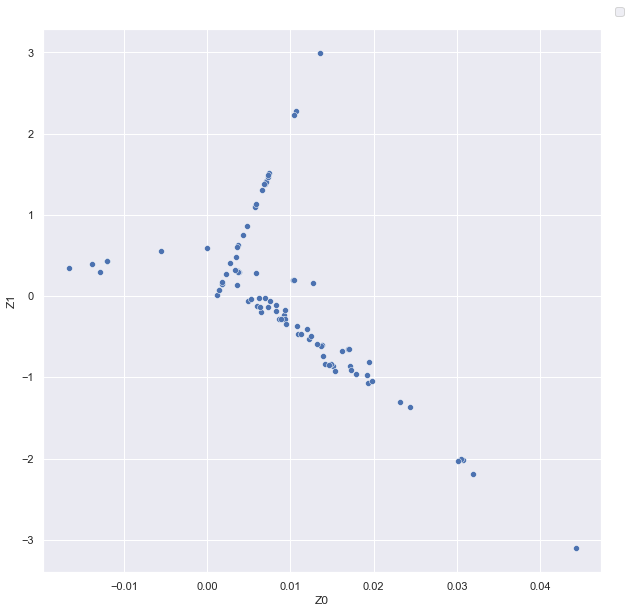

In [26]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='Z0',y='Z1',data=mu_tr_df)
plt.legend(bbox_to_anchor=(1.05, 1.05))